## Forecasting System - Project Demand of Products at a Retail Outlet Based on Historical Data

## Importing required libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
sns.set_style('darkgrid')
import matplotlib

## Reading the data

In [2]:
df = pd.read_excel('hist_data.xlsx')
df

Product  Cost       Year  Monthly_Sales
0                 BEER    42 2019-08-10            208
1        INSTANT SOUPS   161 2021-07-20            890
2               LIQUOR   135 2018-02-08            223
3               SPICES    77 2021-08-31            950
4              SHAMPOO   148 2020-06-10           1300
...                ...   ...        ...            ...
199995        TOMATOES   153 2019-01-29            980
199996           HONEY   201 2021-02-07            104
199997   PEANUT BUTTER    62 2019-12-17             88
199998         COOKIES    45 2020-07-10            148
199999     MOISTURIZER    95 2021-07-14            890

[200000 rows x 4 columns]

In [3]:
df.shape

(200000, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Product        200000 non-null  object        
 1   Cost           200000 non-null  int64         
 2   Year           200000 non-null  datetime64[ns]
 3   Monthly_Sales  200000 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.1+ MB


In [5]:
df = df.set_index(['Year'])

In [6]:
df.index.min(), df.index.max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2021-12-31 00:00:00'))

### Note:
 - The dataset used for this project is a retail store data from 2018 to 2022 containing 200000 entries and this is a time series data.
 - Dataset contains object, integer data types and the year column is already in datetime format.
 - For forecasting, we are using mainly the Sales Data of different product categories.

Year
2018-01-01    746.151364
2018-02-01    728.750456
2018-03-01    725.708442
2018-04-01    723.585480
2018-05-01    731.233040
2018-06-01    739.841285
2018-07-01    729.641473
2018-08-01    715.519565
2018-09-01    739.980349
2018-10-01    729.719467
2018-11-01    744.733076
2018-12-01    736.695131
2019-01-01    721.193448
2019-02-01    723.338739
2019-03-01    730.209248
2019-04-01    719.573366
2019-05-01    726.186344
2019-06-01    731.314639
2019-07-01    733.242310
2019-08-01    733.766231
2019-09-01    730.047433
2019-10-01    727.626303
2019-11-01    723.420535
2019-12-01    721.810240
2020-01-01    737.627901
2020-02-01    736.473214
2020-03-01    732.237767
2020-04-01    732.360700
2020-05-01    721.163519
2020-06-01    744.157529
2020-07-01    738.670213
2020-08-01    736.719870
2020-09-01    724.306380
2020-10-01    723.814037
2020-11-01    716.343758
2020-12-01    722.496714
2021-01-01    735.280009
2021-02-01    730.201619
2021-03-01    732.383718
2021-04-01    743.23

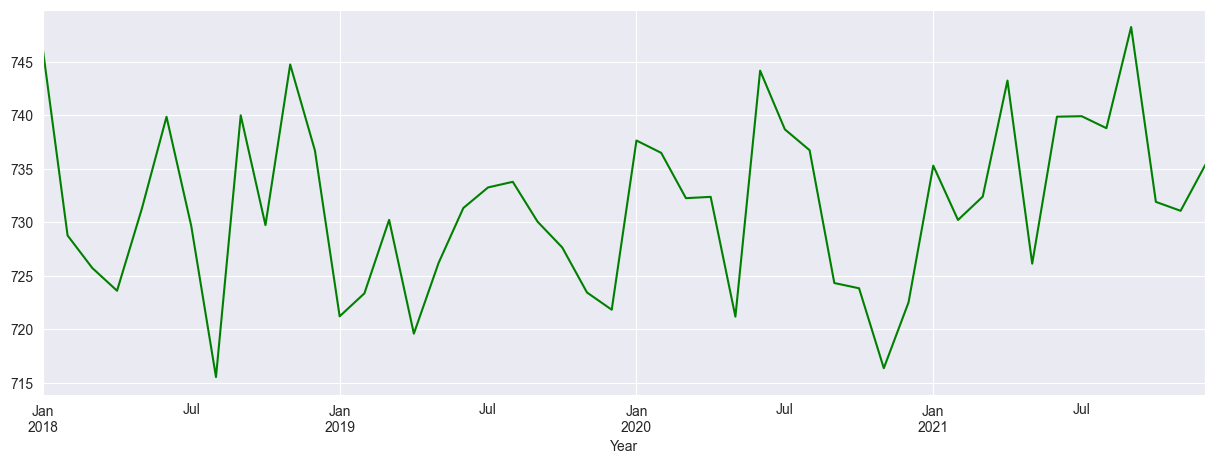

In [7]:
mean_monthlysales = df['Monthly_Sales'].resample('MS').mean()
print(mean_monthlysales)
mean_monthlysales.plot(figsize=(15,5),c='green')
plt.show()

 - Mean monthly sales is maximum in month August of year 2021.
 - Also on month October 2019, May 2020, March 2021, shows higher sales.
 - There is a huge dip in the graph during June 2019 and October 2020 which shows least sales.

## Data Pre-Processing (top 3 and bottom 2 products)

In [8]:
df['Product'].unique()

array(['BEER', 'INSTANT SOUPS', 'LIQUOR', 'SPICES', 'SHAMPOO',
       'MOUTHWASH', 'SPRITE', 'SNICKERS', ' PEANUT BUTTER', 'BREAD',
       'MUFFINS', 'HAND SANITIZERS', 'CONDITIONER', 'PASTA & MACARONI',
       'BUTTER', 'CRACKERS', 'POTATOES', 'APPLES', 'FRUIT JUICE',
       'PEPPERONI', 'SHOWER GEL', 'MILKSHAKE', ' DISH SOAP', 'WINE',
       'FLOWERS', 'CEREAL GRAINS', 'DELI CHEESE', 'SOAP', 'DORITOS',
       'CUPCAKES', 'HAM', 'KIT KAT', 'FROZEN FISH', ' DOG CAT FOOD',
       'BAKING POWDER', 'ICE CREAM', 'SODA', ' SHAVING RAZORS',
       'MOISTURIZER', 'OLIVE OIL', ' DETERGENTS FABRIC SOFTENERS',
       ' BREAKFAST CEREAL', 'SUNFLOWER OIL', 'VINEGAR', 'CHITOS',
       'INSTANT OATMEAL', 'DENTAL FLOSS', 'COKE', 'NOODLES', 'EGGS',
       'FRIED CHICKEN', 'BACON', 'TOOTHPASTE', ' DISPOSABLE CUPS', 'SALT',
       'SEASONINGS', 'APPLESAUCE ', 'TOILET PAPER', 'TOMATOES',
       'BOTTLED WATER', 'DEODORANTS', 'BLOCK CHEESE',
       'FEMININE HYGIENE PRODUCTS', 'SAUSAGES', 'TONER', 'LEMONS

In [9]:
df.isna().sum()

Product          0
Cost             0
Monthly_Sales    0
dtype: int64

In [10]:
df

Product  Cost  Monthly_Sales
Year                                           
2019-08-10            BEER    42            208
2021-07-20   INSTANT SOUPS   161            890
2018-02-08          LIQUOR   135            223
2021-08-31          SPICES    77            950
2020-06-10         SHAMPOO   148           1300
...                    ...   ...            ...
2019-01-29        TOMATOES   153            980
2021-02-07           HONEY   201            104
2019-12-17   PEANUT BUTTER    62             88
2020-07-10         COOKIES    45            148
2021-07-14     MOISTURIZER    95            890

[200000 rows x 3 columns]

- The Dataset does not contain any missing values.

### Toiletpaper

In [11]:
df = pd.read_excel('hist_data.xlsx')
toiletpaper = df.loc[df['Product'] == 'TOILET PAPER']
print(toiletpaper['Year'].min(), toiletpaper['Year'].max())

2018-01-01 00:00:00 2021-12-31 00:00:00


In [12]:
toiletpaper = toiletpaper.sort_values('Year')
toiletpaper

Product  Cost       Year  Monthly_Sales
23259   TOILET PAPER   118 2018-01-01            350
144108  TOILET PAPER   118 2018-01-02            560
39788   TOILET PAPER   118 2018-01-02           1171
29756   TOILET PAPER   118 2018-01-03           1900
20619   TOILET PAPER   118 2018-01-03            560
...              ...   ...        ...            ...
113454  TOILET PAPER   118 2021-12-28            208
42558   TOILET PAPER   118 2021-12-29           1300
25985   TOILET PAPER   118 2021-12-30            780
173985  TOILET PAPER   118 2021-12-31            875
117747  TOILET PAPER   118 2021-12-31            980

[2411 rows x 4 columns]

In [13]:
toiletpaper.isnull().sum()

Product          0
Cost             0
Year             0
Monthly_Sales    0
dtype: int64

In [14]:
toiletpaper = toiletpaper.groupby('Year')['Monthly_Sales'].sum().reset_index()
toiletpaper

Year  Monthly_Sales
0    2018-01-01            350
1    2018-01-02           1731
2    2018-01-03           2460
3    2018-01-04            642
4    2018-01-05           2958
...         ...            ...
1177 2021-12-27            350
1178 2021-12-28            998
1179 2021-12-29           1300
1180 2021-12-30            780
1181 2021-12-31           1855

[1182 rows x 2 columns]

In [15]:
toiletpaper = toiletpaper.set_index('Year')
toiletpaper

Monthly_Sales
Year                     
2018-01-01            350
2018-01-02           1731
2018-01-03           2460
2018-01-04            642
2018-01-05           2958
...                   ...
2021-12-27            350
2021-12-28            998
2021-12-29           1300
2021-12-30            780
2021-12-31           1855

[1182 rows x 1 columns]

In [16]:
toiletpaper.index


DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-07', '2018-01-08', '2018-01-09',
               '2018-01-10', '2018-01-11',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Year', length=1182, freq=None)

Text(0.5, 1.0, 'Toilet Paper sales')

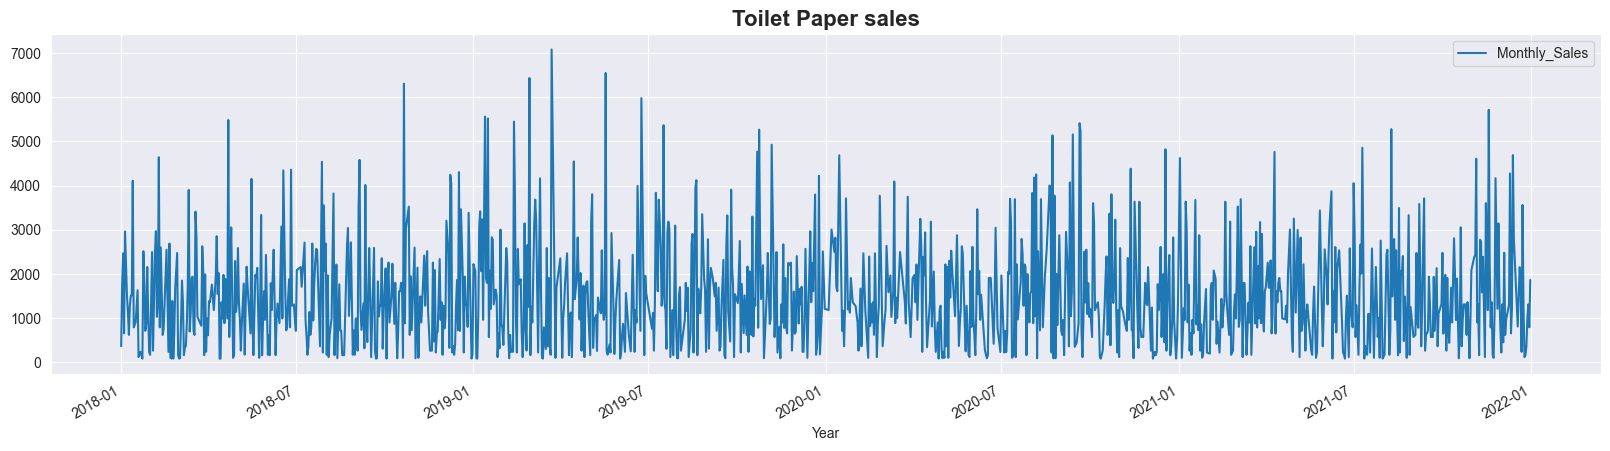

In [17]:
toiletpaper.plot(figsize=(20,5))
plt.title("Toilet Paper sales",fontsize=16, fontweight='bold')

In [18]:
toiletpaper

Monthly_Sales
Year                     
2018-01-01            350
2018-01-02           1731
2018-01-03           2460
2018-01-04            642
2018-01-05           2958
...                   ...
2021-12-27            350
2021-12-28            998
2021-12-29           1300
2021-12-30            780
2021-12-31           1855

[1182 rows x 1 columns]

In [19]:
toiletpaper.index = pd.to_datetime(toiletpaper.index)
y_tp = toiletpaper['Monthly_Sales'].resample('MS').mean()
y_tp

Year
2018-01-01    1265.576923
2018-02-01    1511.952381
2018-03-01    1239.214286
2018-04-01    1496.920000
2018-05-01    1426.846154
2018-06-01    1463.083333
2018-07-01    1630.833333
2018-08-01    1257.038462
2018-09-01    1364.384615
2018-10-01    1662.000000
2018-11-01    1249.800000
2018-12-01    1545.851852
2019-01-01    1874.892857
2019-02-01    1653.541667
2019-03-01    1603.809524
2019-04-01    1434.923077
2019-05-01    1380.880000
2019-06-01    1350.650000
2019-07-01    1832.923077
2019-08-01    1533.576923
2019-09-01    1489.041667
2019-10-01    1687.478261
2019-11-01    1436.407407
2019-12-01    1468.807692
2020-01-01    1848.222222
2020-02-01    1229.545455
2020-03-01    1638.650000
2020-04-01    1501.416667
2020-05-01    1229.730769
2020-06-01    1254.150000
2020-07-01    1553.269231
2020-08-01    2200.217391
2020-09-01    1703.962963
2020-10-01    1455.807692
2020-11-01    1486.375000
2020-12-01    1156.107143
2021-01-01    1289.800000
2021-02-01    1275.227273
2021-03

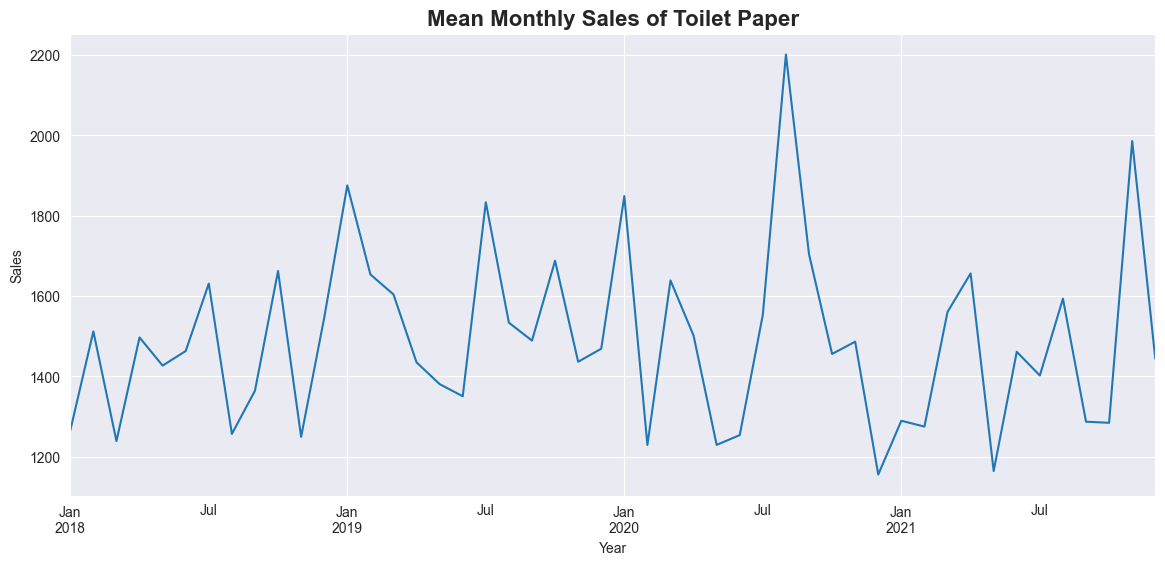

In [20]:
y_tp.plot(figsize=(14,6))
plt.title('Mean Monthly Sales of Toilet Paper', fontsize=16, fontweight='bold')
plt.ylabel("Sales")
plt.show()

- average sales is maximum at July 2020.

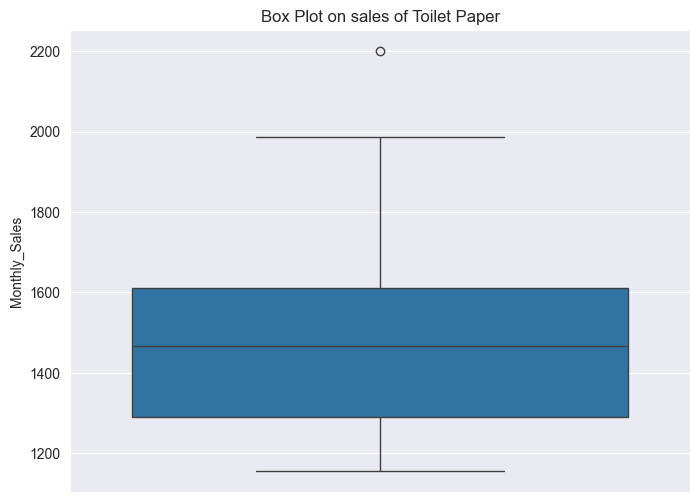

In [21]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(y_tp).set_title('Box Plot on sales of Toilet Paper')
plt.show()

- there is one outlier in the toilet paper sales data

### Chitos

In [22]:
chitos = df.loc[df['Product'] == 'CHITOS']
chitos

Product  Cost       Year  Monthly_Sales
54      CHITOS    40 2018-06-14            980
62      CHITOS    40 2018-08-30           1790
160     CHITOS    40 2020-03-07             78
217     CHITOS    40 2019-03-12           1790
420     CHITOS    40 2020-11-15             78
...        ...   ...        ...            ...
199038  CHITOS    40 2018-06-19             78
199225  CHITOS    40 2019-02-28             78
199812  CHITOS    40 2021-11-12            890
199869  CHITOS    40 2021-05-27           1350
199962  CHITOS    40 2018-03-09            890

[2392 rows x 4 columns]

In [23]:
print(chitos['Year'].min(), chitos['Year'].max())


2018-01-01 00:00:00 2021-12-31 00:00:00


In [24]:
chitos = chitos.sort_values('Year')
chitos

Product  Cost       Year  Monthly_Sales
140421  CHITOS    40 2018-01-01            980
61878   CHITOS    40 2018-01-01            223
6141    CHITOS    40 2018-01-02            890
82706   CHITOS    40 2018-01-03            148
104488  CHITOS    40 2018-01-03            875
...        ...   ...        ...            ...
89688   CHITOS    40 2021-12-28           1790
106362  CHITOS    40 2021-12-29            700
2550    CHITOS    40 2021-12-29           1790
198330  CHITOS    40 2021-12-31            250
134918  CHITOS    40 2021-12-31            560

[2392 rows x 4 columns]

In [25]:
chitos.isnull().sum()


Product          0
Cost             0
Year             0
Monthly_Sales    0
dtype: int64

In [26]:
chitos = chitos.groupby('Year')['Monthly_Sales'].sum().reset_index()
chitos

Year  Monthly_Sales
0    2018-01-01           1203
1    2018-01-02            890
2    2018-01-03           1023
3    2018-01-04           3808
4    2018-01-05            104
...         ...            ...
1186 2021-12-26           1517
1187 2021-12-27           1270
1188 2021-12-28           1790
1189 2021-12-29           2490
1190 2021-12-31            810

[1191 rows x 2 columns]

In [27]:
chitos = chitos.set_index('Year')
chitos


Monthly_Sales
Year                     
2018-01-01           1203
2018-01-02            890
2018-01-03           1023
2018-01-04           3808
2018-01-05            104
...                   ...
2021-12-26           1517
2021-12-27           1270
2021-12-28           1790
2021-12-29           2490
2021-12-31            810

[1191 rows x 1 columns]

In [28]:
chitos.index


DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2021-12-20', '2021-12-21', '2021-12-22', '2021-12-23',
               '2021-12-25', '2021-12-26', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-31'],
              dtype='datetime64[ns]', name='Year', length=1191, freq=None)

Text(0.5, 1.0, 'Chitos Sales')

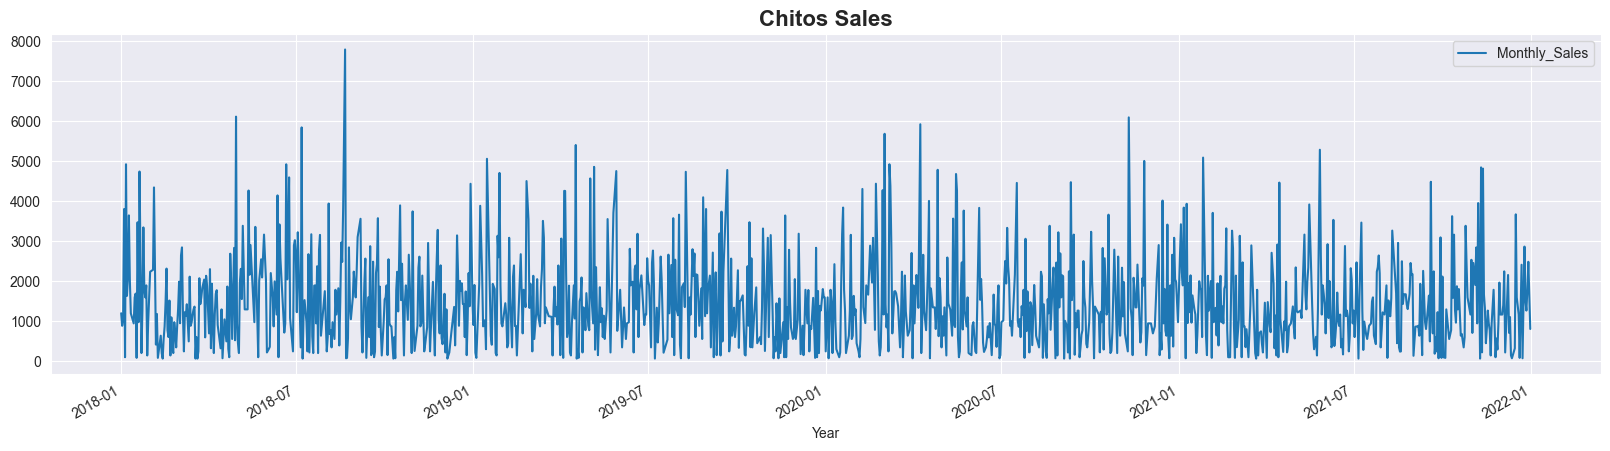

In [29]:
chitos.plot(figsize=(20,5))
plt.title("Chitos Sales", fontsize=16, fontweight='bold')

In [30]:
chitos.index = pd.to_datetime(chitos.index)
y_ch = chitos['Monthly_Sales'].resample('MS').mean()
y_ch

Year
2018-01-01    1866.035714
2018-02-01     962.000000
2018-03-01    1307.482759
2018-04-01    1343.000000
2018-05-01    1902.956522
2018-06-01    1908.000000
2018-07-01    1687.960000
2018-08-01    1647.555556
2018-09-01    1496.440000
2018-10-01    1469.370370
2018-11-01    1309.541667
2018-12-01    1389.730769
2019-01-01    1660.080000
2019-02-01    1622.052632
2019-03-01    1495.320000
2019-04-01    1421.678571
2019-05-01    1708.500000
2019-06-01    1546.238095
2019-07-01    1555.045455
2019-08-01    1829.800000
2019-09-01    1511.500000
2019-10-01    1317.360000
2019-11-01    1160.000000
2019-12-01    1151.166667
2020-01-01    1265.360000
2020-02-01    1675.956522
2020-03-01    1668.555556
2020-04-01    1777.583333
2020-05-01    1498.560000
2020-06-01     944.480000
2020-07-01    1549.703704
2020-08-01    1353.230769
2020-09-01    1262.107143
2020-10-01    1423.458333
2020-11-01    1620.625000
2020-12-01    1441.958333
2021-01-01    1747.240000
2021-02-01    1428.360000
2021-03

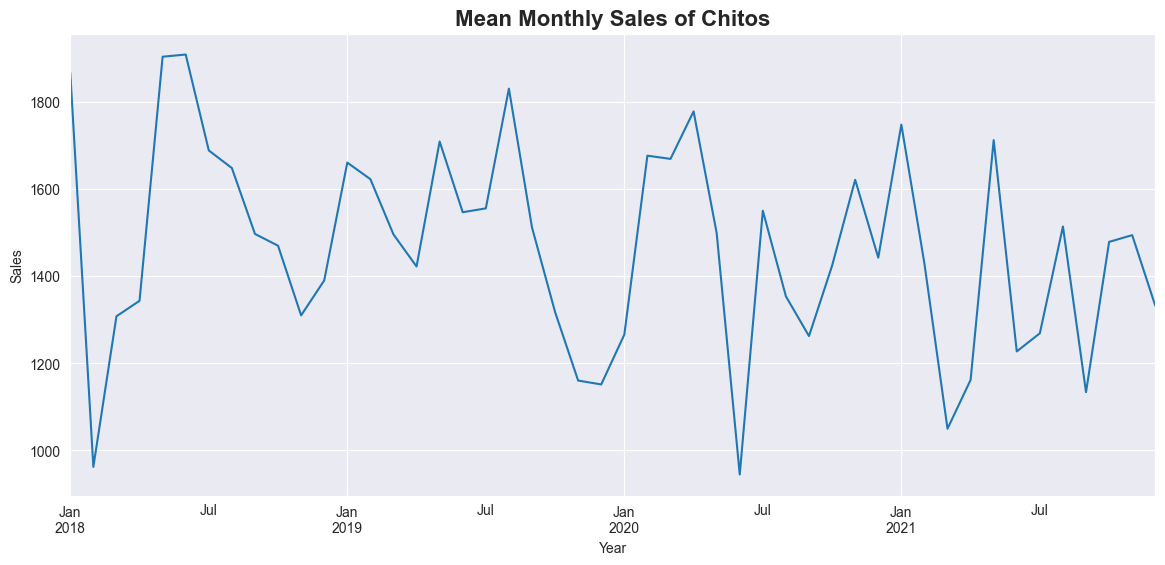

In [31]:
y_ch.plot(figsize=(14,6))
plt.title('Mean Monthly Sales of Chitos', fontsize=16, fontweight='bold')
plt.ylabel("Sales")
plt.show()

- Sales for chitos shows maximum at start of year between april to May and minimum at end of year.

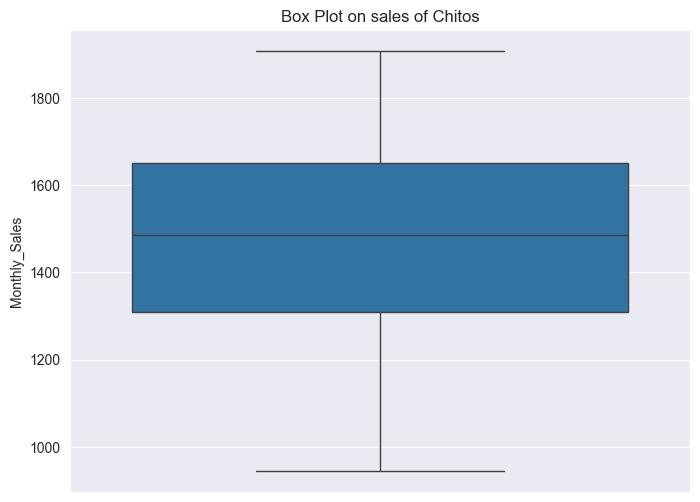

In [32]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(y_ch).set_title('Box Plot on sales of Chitos')
plt.show()

- there are no outliers in chitos sales data

### Peanut Butter

In [33]:
peanutbutter = df.loc[df['Product'] == ' PEANUT BUTTER']
peanutbutter

Product  Cost       Year  Monthly_Sales
8        PEANUT BUTTER    62 2020-04-06            223
27       PEANUT BUTTER    62 2018-02-06            560
55       PEANUT BUTTER    62 2019-11-05             78
127      PEANUT BUTTER    62 2019-10-10            156
151      PEANUT BUTTER    62 2020-08-12            875
...                ...   ...        ...            ...
199859   PEANUT BUTTER    62 2019-09-04            208
199937   PEANUT BUTTER    62 2021-09-07           1900
199956   PEANUT BUTTER    62 2018-09-11            156
199973   PEANUT BUTTER    62 2021-07-29           1790
199997   PEANUT BUTTER    62 2019-12-17             88

[2391 rows x 4 columns]

In [34]:
print(peanutbutter['Year'].min(), peanutbutter['Year'].max())

2018-01-01 00:00:00 2021-12-31 00:00:00


In [35]:
peanutbutter = peanutbutter.sort_values('Year')
peanutbutter

Product  Cost       Year  Monthly_Sales
178668   PEANUT BUTTER    62 2018-01-01            156
85926    PEANUT BUTTER    62 2018-01-01             70
59807    PEANUT BUTTER    62 2018-01-03            350
39520    PEANUT BUTTER    62 2018-01-03            250
53473    PEANUT BUTTER    62 2018-01-03            350
...                ...   ...        ...            ...
97082    PEANUT BUTTER    62 2021-12-29            208
151049   PEANUT BUTTER    62 2021-12-29            700
33835    PEANUT BUTTER    62 2021-12-30           1270
97167    PEANUT BUTTER    62 2021-12-31            560
11525    PEANUT BUTTER    62 2021-12-31            980

[2391 rows x 4 columns]

In [36]:
peanutbutter.isnull().sum()


Product          0
Cost             0
Year             0
Monthly_Sales    0
dtype: int64

In [37]:
peanutbutter = peanutbutter.groupby('Year')['Monthly_Sales'].sum().reset_index()
peanutbutter


Year  Monthly_Sales
0    2018-01-01            226
1    2018-01-03           1388
2    2018-01-04            250
3    2018-01-05           1404
4    2018-01-06           1900
...         ...            ...
1151 2021-12-27            638
1152 2021-12-28             70
1153 2021-12-29           3133
1154 2021-12-30           1270
1155 2021-12-31           1540

[1156 rows x 2 columns]

In [38]:
peanutbutter = peanutbutter.set_index('Year')
peanutbutter


Monthly_Sales
Year                     
2018-01-01            226
2018-01-03           1388
2018-01-04            250
2018-01-05           1404
2018-01-06           1900
...                   ...
2021-12-27            638
2021-12-28             70
2021-12-29           3133
2021-12-30           1270
2021-12-31           1540

[1156 rows x 1 columns]

In [39]:
peanutbutter.index


DatetimeIndex(['2018-01-01', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-06', '2018-01-07', '2018-01-08', '2018-01-10',
               '2018-01-11', '2018-01-12',
               ...
               '2021-12-21', '2021-12-22', '2021-12-23', '2021-12-24',
               '2021-12-25', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Year', length=1156, freq=None)

Text(0.5, 1.0, 'Peanut Butter Sales')

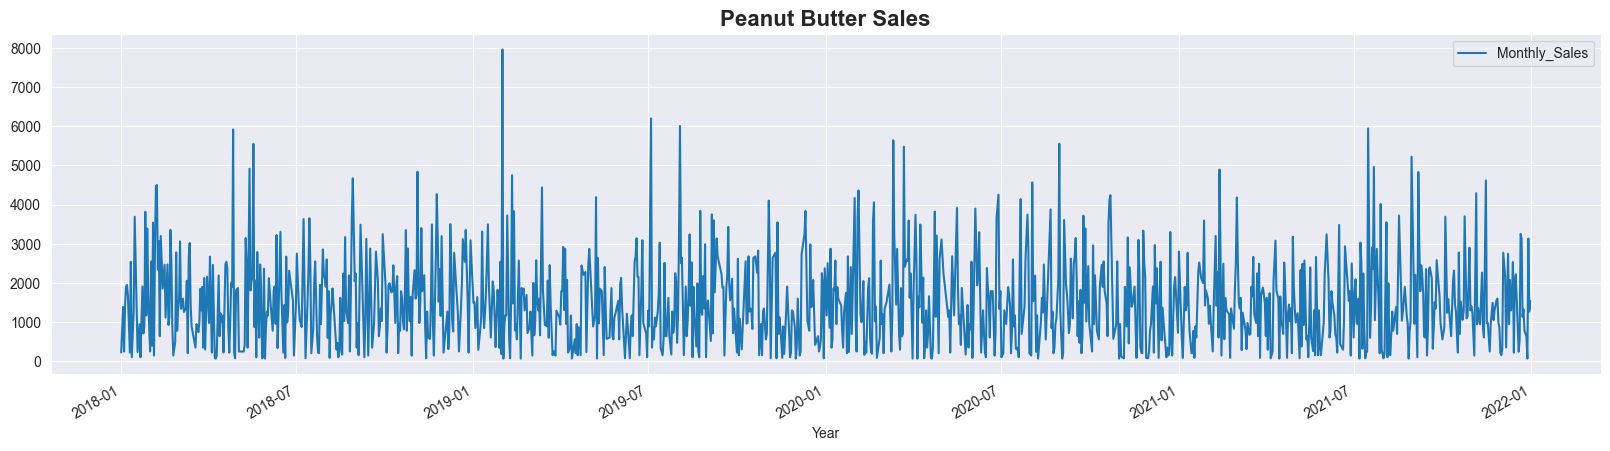

In [40]:
peanutbutter.plot(figsize=(20,5))
plt.title("Peanut Butter Sales", fontsize=16, fontweight='bold')

In [41]:
peanutbutter.index = pd.to_datetime(peanutbutter.index)
y_pb = peanutbutter['Monthly_Sales'].resample('MS').mean()
y_pb

Year
2018-01-01    1364.360000
2018-02-01    2028.416667
2018-03-01    1428.320000
2018-04-01    1378.576923
2018-05-01    1637.280000
2018-06-01    1497.125000
2018-07-01    1653.583333
2018-08-01    1467.192308
2018-09-01    1455.666667
2018-10-01    1475.851852
2018-11-01    1948.384615
2018-12-01    1647.571429
2019-01-01    1681.720000
2019-02-01    1487.869565
2019-03-01    1307.000000
2019-04-01    1260.347826
2019-05-01    1445.476190
2019-06-01    1410.523810
2019-07-01    1367.666667
2019-08-01    1731.821429
2019-09-01    1955.100000
2019-10-01    1354.217391
2019-11-01    1287.565217
2019-12-01    1340.173913
2020-01-01    1520.260870
2020-02-01    1456.240000
2020-03-01    1927.208333
2020-04-01    1586.423077
2020-05-01    1327.650000
2020-06-01    1615.173913
2020-07-01    1341.520000
2020-08-01    1562.500000
2020-09-01    1658.555556
2020-10-01    1782.000000
2020-11-01    1259.038462
2020-12-01    1146.333333
2021-01-01    1468.125000
2021-02-01    1505.363636
2021-03

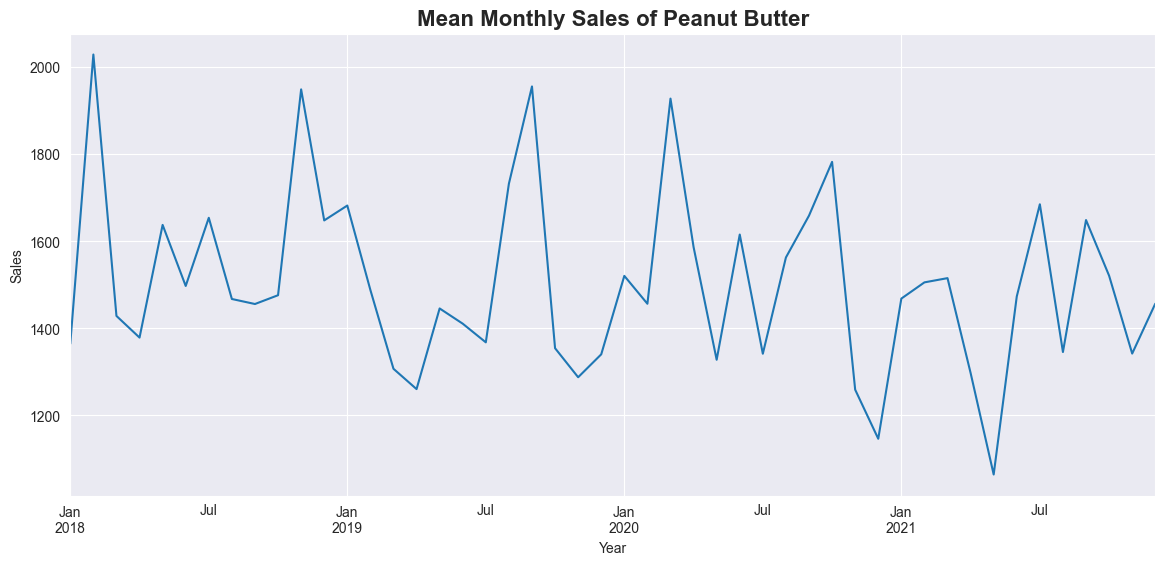

In [42]:
y_pb.plot(figsize=(14,6))
plt.title('Mean Monthly Sales of Peanut Butter', fontsize=16, fontweight='bold')
plt.ylabel("Sales")
plt.show()


- Peanut Butter have highest sales in January 2018.

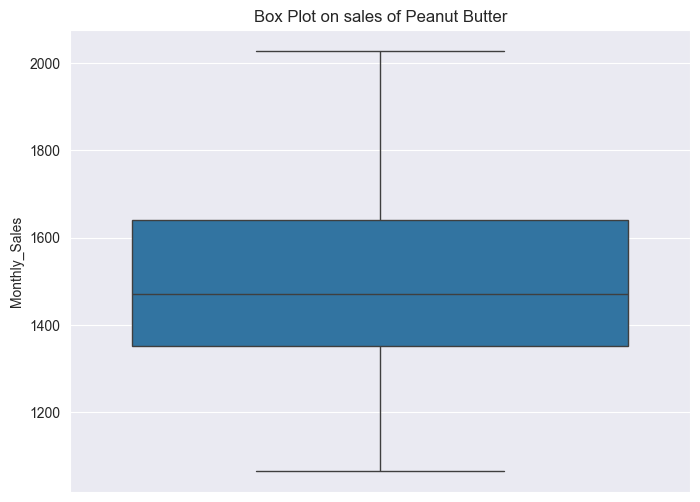

In [43]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(y_pb).set_title('Box Plot on sales of Peanut Butter')
plt.show()

- there are no outliers in Peanut Butter sales data

### Conditioner

In [44]:
conditioner = df.loc[df['Product'] == 'CONDITIONER']
conditioner

Product  Cost       Year  Monthly_Sales
12      CONDITIONER   185 2021-02-14            560
252     CONDITIONER   185 2018-09-18            700
403     CONDITIONER   185 2019-11-10            980
412     CONDITIONER   185 2019-10-28            350
487     CONDITIONER   185 2020-07-06            208
...             ...   ...        ...            ...
199594  CONDITIONER   185 2018-06-01             78
199596  CONDITIONER   185 2020-06-26             78
199707  CONDITIONER   185 2018-08-13           1270
199779  CONDITIONER   185 2020-10-08            780
199791  CONDITIONER   185 2020-11-04            780

[2163 rows x 4 columns]

In [45]:
print(conditioner['Year'].min(), conditioner['Year'].max())

2018-01-01 00:00:00 2021-12-28 00:00:00


In [46]:
conditioner = conditioner.sort_values('Year')
conditioner

Product  Cost       Year  Monthly_Sales
88246   CONDITIONER   185 2018-01-01            350
142362  CONDITIONER   185 2018-01-01           1900
134686  CONDITIONER   185 2018-01-02            700
161422  CONDITIONER   185 2018-01-02            104
65846   CONDITIONER   185 2018-01-02            250
...             ...   ...        ...            ...
93547   CONDITIONER   185 2021-12-25           1790
146679  CONDITIONER   185 2021-12-25            950
190165  CONDITIONER   185 2021-12-25            148
194126  CONDITIONER   185 2021-12-25           1600
120654  CONDITIONER   185 2021-12-28            104

[2163 rows x 4 columns]

In [47]:
conditioner.isnull().sum()


Product          0
Cost             0
Year             0
Monthly_Sales    0
dtype: int64

In [48]:
conditioner = conditioner.groupby('Year')['Monthly_Sales'].sum().reset_index()
conditioner

Year  Monthly_Sales
0    2018-01-01           2250
1    2018-01-02           1054
2    2018-01-03           1444
3    2018-01-05           2625
4    2018-01-06           1171
...         ...            ...
1107 2021-12-21           1846
1108 2021-12-22            250
1109 2021-12-23            208
1110 2021-12-25           4566
1111 2021-12-28            104

[1112 rows x 2 columns]

In [49]:
conditioner = conditioner.set_index('Year')
conditioner

Monthly_Sales
Year                     
2018-01-01           2250
2018-01-02           1054
2018-01-03           1444
2018-01-05           2625
2018-01-06           1171
...                   ...
2021-12-21           1846
2021-12-22            250
2021-12-23            208
2021-12-25           4566
2021-12-28            104

[1112 rows x 1 columns]

In [50]:
conditioner.index


DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-05',
               '2018-01-06', '2018-01-08', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-14',
               ...
               '2021-12-14', '2021-12-16', '2021-12-17', '2021-12-18',
               '2021-12-19', '2021-12-21', '2021-12-22', '2021-12-23',
               '2021-12-25', '2021-12-28'],
              dtype='datetime64[ns]', name='Year', length=1112, freq=None)

Text(0.5, 1.0, 'Conditioner Sales')

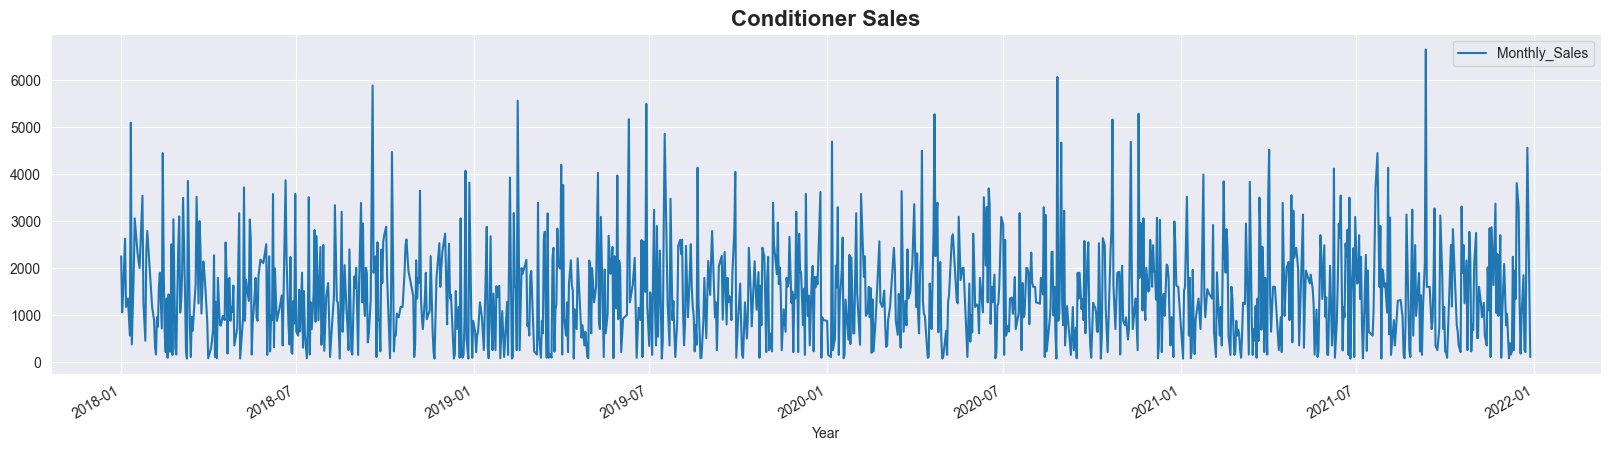

In [51]:
conditioner.plot(figsize=(20,5))
plt.title("Conditioner Sales", fontsize=16, fontweight='bold')

In [52]:
conditioner.index = pd.to_datetime(conditioner.index)
y_co = conditioner['Monthly_Sales'].resample('MS').mean()
y_co

Year
2018-01-01    1978.888889
2018-02-01    1105.750000
2018-03-01    1742.923077
2018-04-01    1026.750000
2018-05-01    1641.650000
2018-06-01    1366.000000
2018-07-01    1210.040000
2018-08-01    1283.227273
2018-09-01    1760.560000
2018-10-01    1540.050000
2018-11-01    1527.130435
2018-12-01    1215.083333
2019-01-01    1022.500000
2019-02-01    1461.428571
2019-03-01    1281.760000
2019-04-01    1219.090909
2019-05-01    1706.080000
2019-06-01    1824.050000
2019-07-01    1509.160000
2019-08-01    1372.851852
2019-09-01    1635.190476
2019-10-01    1216.863636
2019-11-01    1579.833333
2019-12-01    1491.083333
2020-01-01    1316.541667
2020-02-01    1371.105263
2020-03-01    1423.956522
2020-04-01    1658.653846
2020-05-01    1444.421053
2020-06-01    1710.434783
2020-07-01    1428.961538
2020-08-01    1743.041667
2020-09-01    1182.000000
2020-10-01    1504.347826
2020-11-01    1775.166667
2020-12-01    1536.259259
2021-01-01    1247.857143
2021-02-01    1302.681818
2021-03

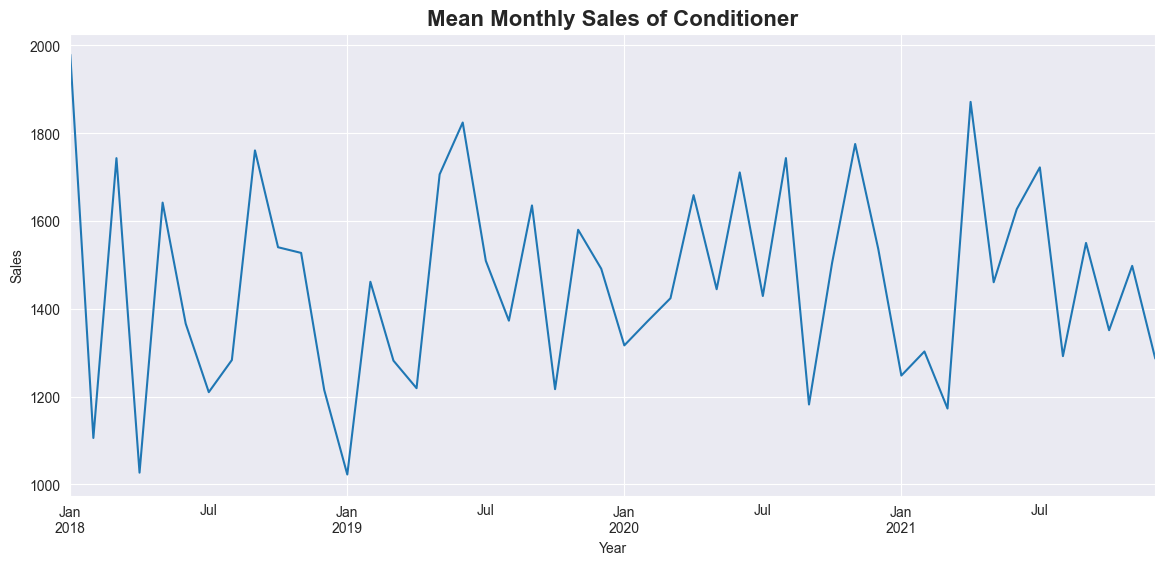

In [53]:
y_co.plot(figsize=(14,6))
plt.title('Mean Monthly Sales of Conditioner', fontsize=16, fontweight='bold')
plt.ylabel("Sales")
plt.show()

- Conditioner have highest sales in March 2021 and also in April-May of 2019.

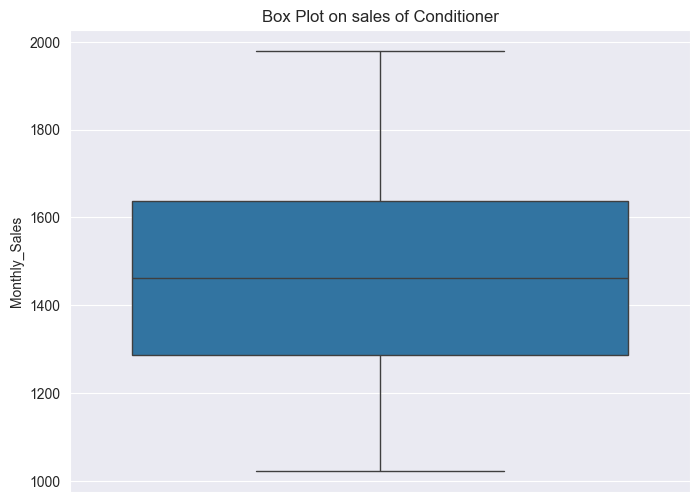

In [54]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(y_co).set_title('Box Plot on sales of Conditioner')
plt.show()

- there are no outliers in conditioner sales data

### Flour

In [55]:
flour = df.loc[df['Product'] == 'FLOUR']
flour

Product  Cost       Year  Monthly_Sales
102      FLOUR   193 2018-03-04            156
103      FLOUR   193 2020-08-18           1350
258      FLOUR   193 2020-05-24            148
265      FLOUR   193 2019-04-24            642
378      FLOUR   193 2018-07-19           1300
...        ...   ...        ...            ...
199588   FLOUR   193 2020-06-27            642
199660   FLOUR   193 2019-12-28           1270
199931   FLOUR   193 2018-02-07           1171
199948   FLOUR   193 2019-03-25            148
199991   FLOUR   193 2019-10-22            700

[2142 rows x 4 columns]

In [56]:
print(flour['Year'].min(), flour['Year'].max())

2018-01-01 00:00:00 2021-12-31 00:00:00


In [57]:
flour = flour.sort_values('Year')
flour

Product  Cost       Year  Monthly_Sales
81638    FLOUR   193 2018-01-01           1900
77718    FLOUR   193 2018-01-02            700
82935    FLOUR   193 2018-01-02            156
111109   FLOUR   193 2018-01-03            950
108487   FLOUR   193 2018-01-03            980
...        ...   ...        ...            ...
31630    FLOUR   193 2021-12-28            104
135121   FLOUR   193 2021-12-30            700
6941     FLOUR   193 2021-12-30            980
189446   FLOUR   193 2021-12-31            890
179269   FLOUR   193 2021-12-31            642

[2142 rows x 4 columns]

In [58]:
flour.isnull().sum()


Product          0
Cost             0
Year             0
Monthly_Sales    0
dtype: int64

In [59]:
flour = flour.groupby('Year')['Monthly_Sales'].sum().reset_index()
flour

Year  Monthly_Sales
0    2018-01-01           1900
1    2018-01-02            856
2    2018-01-03           2780
3    2018-01-04            223
4    2018-01-05           2620
...         ...            ...
1104 2021-12-25           1388
1105 2021-12-27           3421
1106 2021-12-28           2844
1107 2021-12-30           1680
1108 2021-12-31           1532

[1109 rows x 2 columns]

In [60]:
flour = flour.set_index('Year')
flour

Monthly_Sales
Year                     
2018-01-01           1900
2018-01-02            856
2018-01-03           2780
2018-01-04            223
2018-01-05           2620
...                   ...
2021-12-25           1388
2021-12-27           3421
2021-12-28           2844
2021-12-30           1680
2021-12-31           1532

[1109 rows x 1 columns]

In [61]:
flour.index


DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-07', '2018-01-08', '2018-01-10',
               '2018-01-11', '2018-01-12',
               ...
               '2021-12-13', '2021-12-14', '2021-12-16', '2021-12-20',
               '2021-12-23', '2021-12-25', '2021-12-27', '2021-12-28',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Year', length=1109, freq=None)

Text(0.5, 1.0, 'Flour Sales')

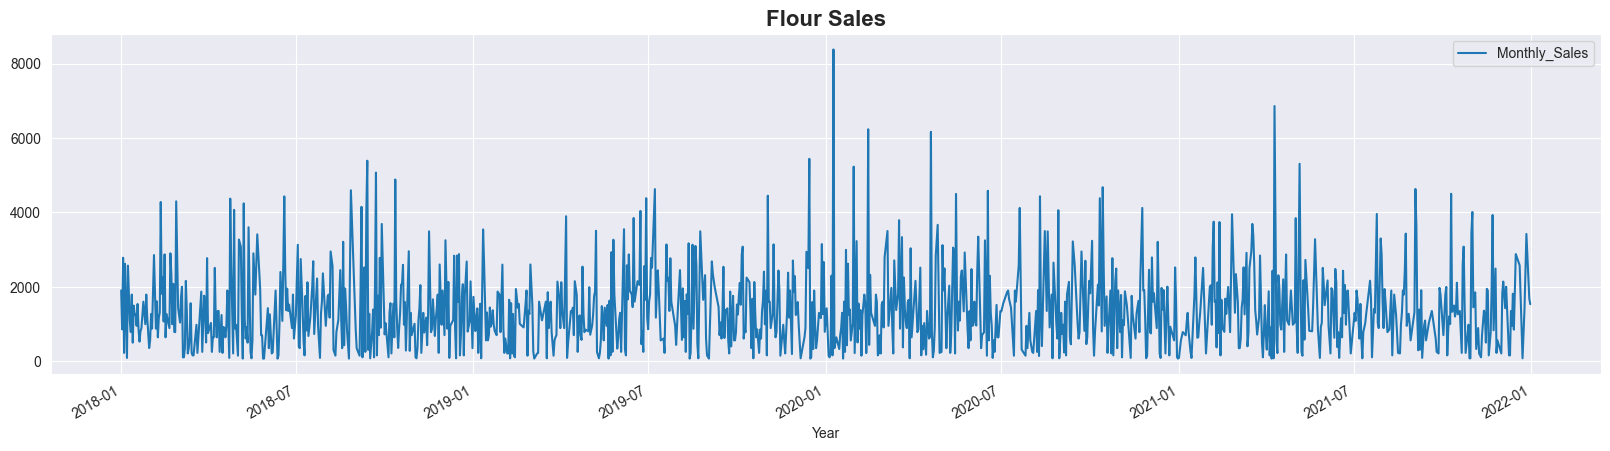

In [62]:
flour.plot(figsize=(20,5))
plt.title("Flour Sales", fontsize=16, fontweight='bold')

In [63]:
flour.index = pd.to_datetime(flour.index)
y_fl = flour['Monthly_Sales'].resample('MS').mean()
y_fl

Year
2018-01-01    1200.230769
2018-02-01    1733.434783
2018-03-01     966.916667
2018-04-01    1220.080000
2018-05-01    1421.590909
2018-06-01    1361.739130
2018-07-01    1411.391304
2018-08-01    1498.350000
2018-09-01    1703.360000
2018-10-01    1327.750000
2018-11-01    1150.840000
2018-12-01    1409.250000
2019-01-01    1286.500000
2019-02-01     918.772727
2019-03-01    1028.904762
2019-04-01    1235.434783
2019-05-01    1203.461538
2019-06-01    1830.333333
2019-07-01    1786.190476
2019-08-01    1527.846154
2019-09-01    1186.652174
2019-10-01    1393.714286
2019-11-01    1489.791667
2019-12-01    1408.791667
2020-01-01    1383.680000
2020-02-01    1365.500000
2020-03-01    1654.478261
2020-04-01    1305.636364
2020-05-01    1695.080000
2020-06-01    1305.333333
2020-07-01    1396.117647
2020-08-01    1439.761905
2020-09-01    1356.304348
2020-10-01    1676.391304
2020-11-01    1282.954545
2020-12-01    1295.750000
2021-01-01     967.352941
2021-02-01    1738.523810
2021-03

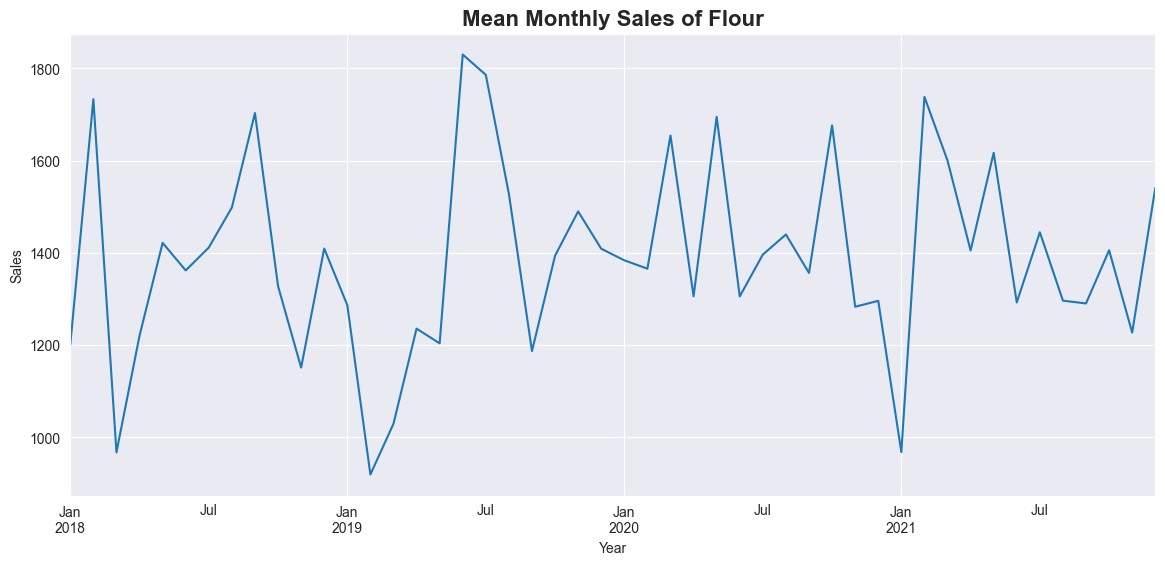

In [64]:
y_fl.plot(figsize=(14,6))
plt.title('Mean Monthly Sales of Flour', fontsize=16, fontweight='bold')
plt.ylabel("Sales")
plt.show()

Flour have highest sales in May 2019.

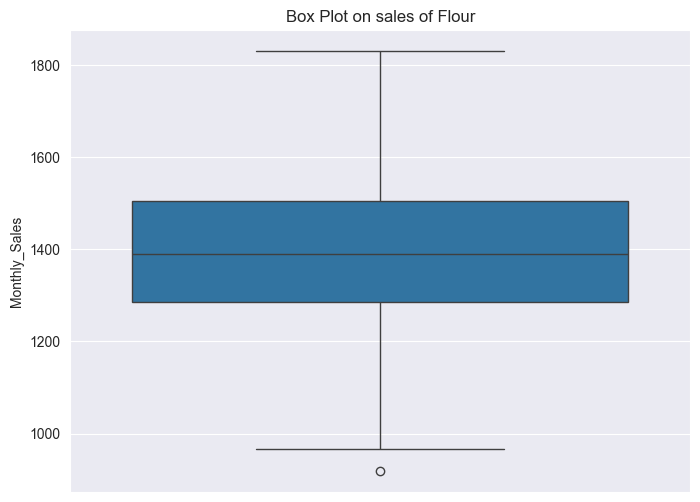

In [65]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(y_fl).set_title('Box Plot on sales of Flour')
plt.show()

- there is one outlier in the flour sales data

## ETS decomposition

### Toilerpaper

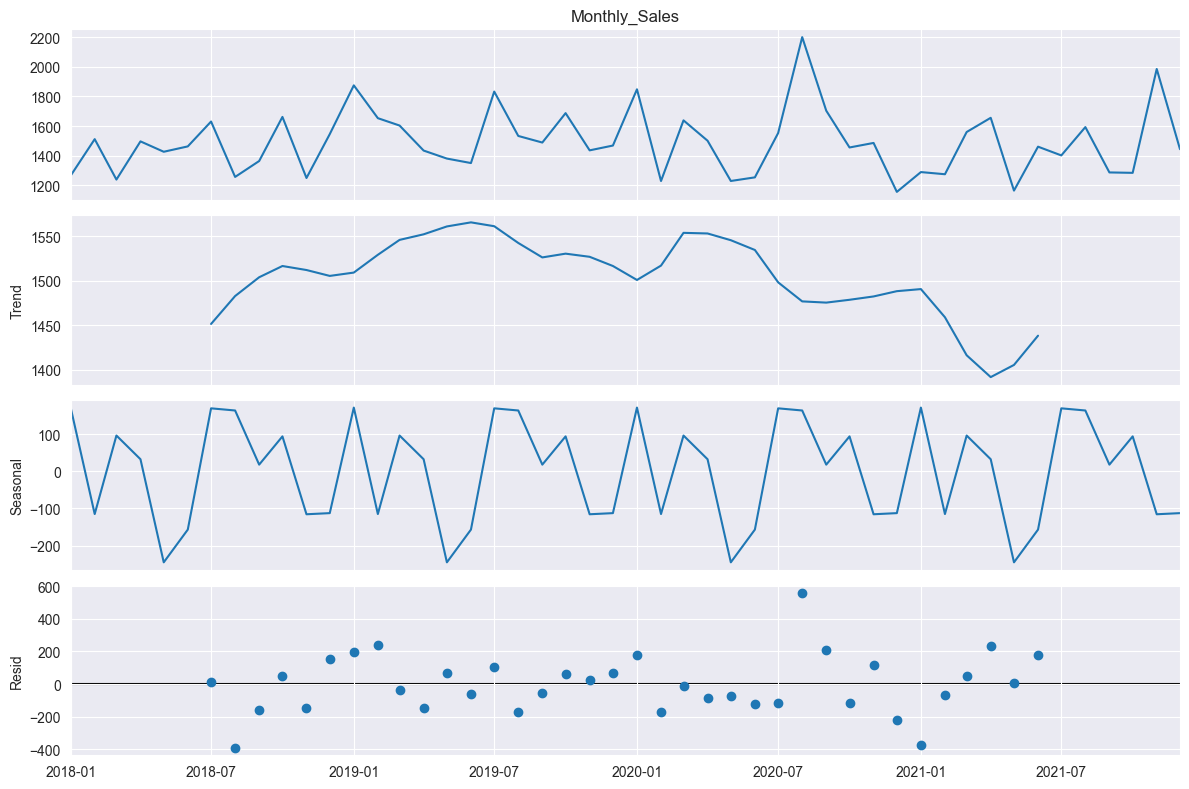

In [66]:
rcParams['figure.figsize'] = 12,8
decomposition_tp = sm.tsa.seasonal_decompose(y_tp, model='additive')
fig = decomposition_tp.plot()
plt.show()

- From the trend graph,there is a rise in curve and reaches a maximum in the first half of 2019 after that there is fall in sales till 2020. Then it gradually rises in the beginning of 2020 and repeats.

### Chitos

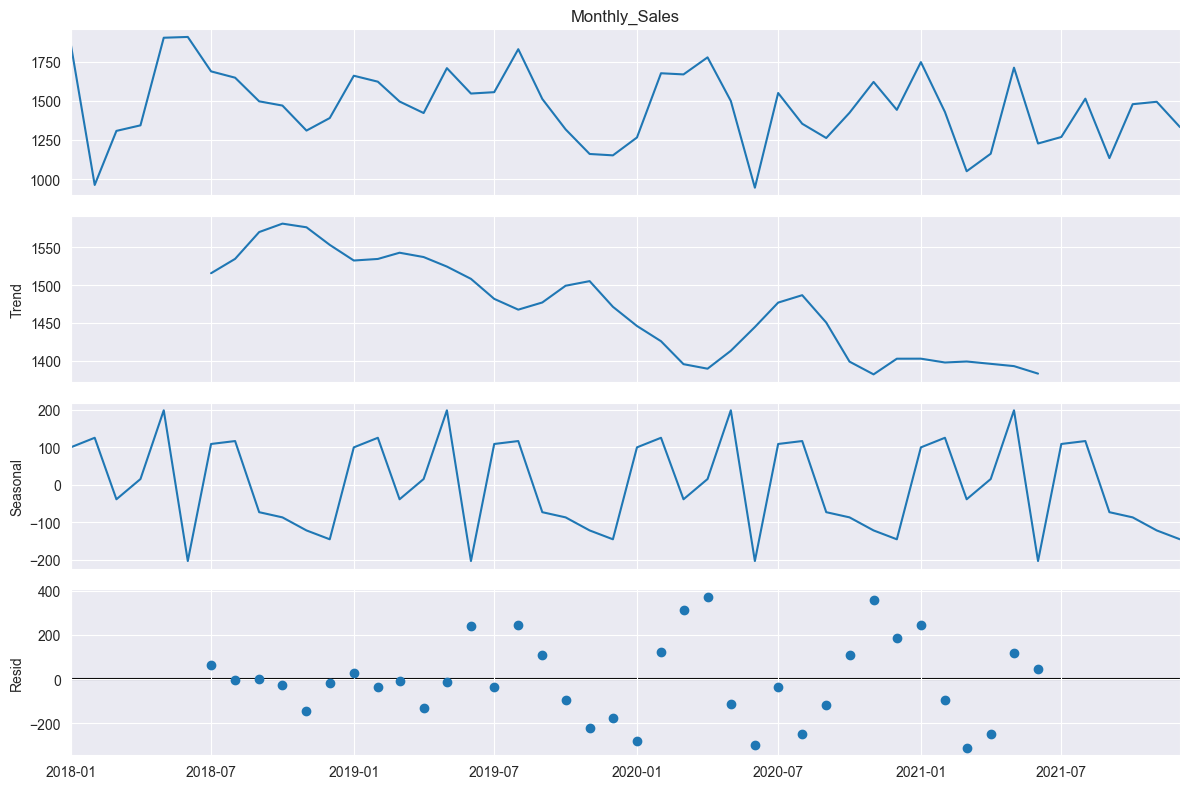

In [67]:
rcParams['figure.figsize'] = 12,8
decomposition_ch = sm.tsa.seasonal_decompose(y_ch, model='additive')
fig = decomposition_ch.plot()
plt.show()

 - Decreasing trend is observed for the sales of chitos in the later half of 2018.

### Peanut Butter

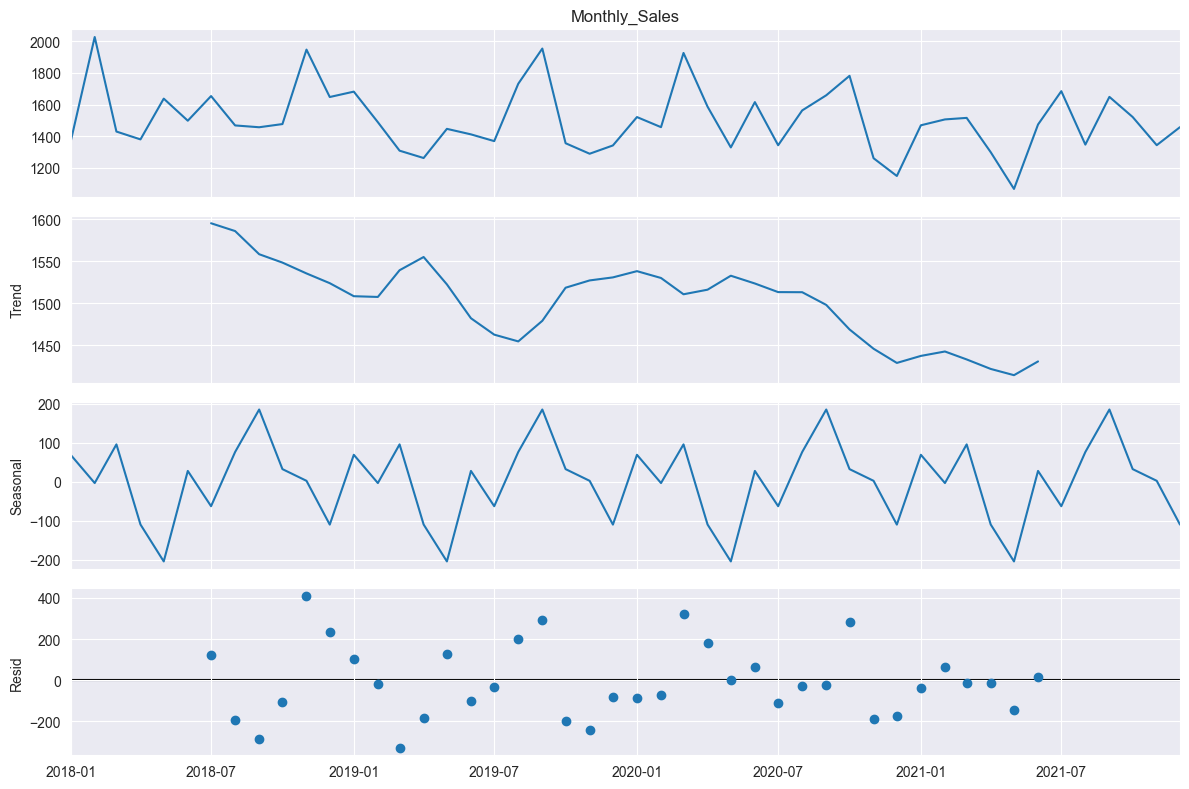

In [68]:
rcParams['figure.figsize'] = 12,8
decomposition_pb = sm.tsa.seasonal_decompose(y_pb, model='additive')
fig = decomposition_pb.plot()
plt.show()

 - Decreasing trend is observed for the sales of peanut butter after later half of 2018 with some slight increase in sales in between, but the overall trend is in a downward direction

### Conditioner

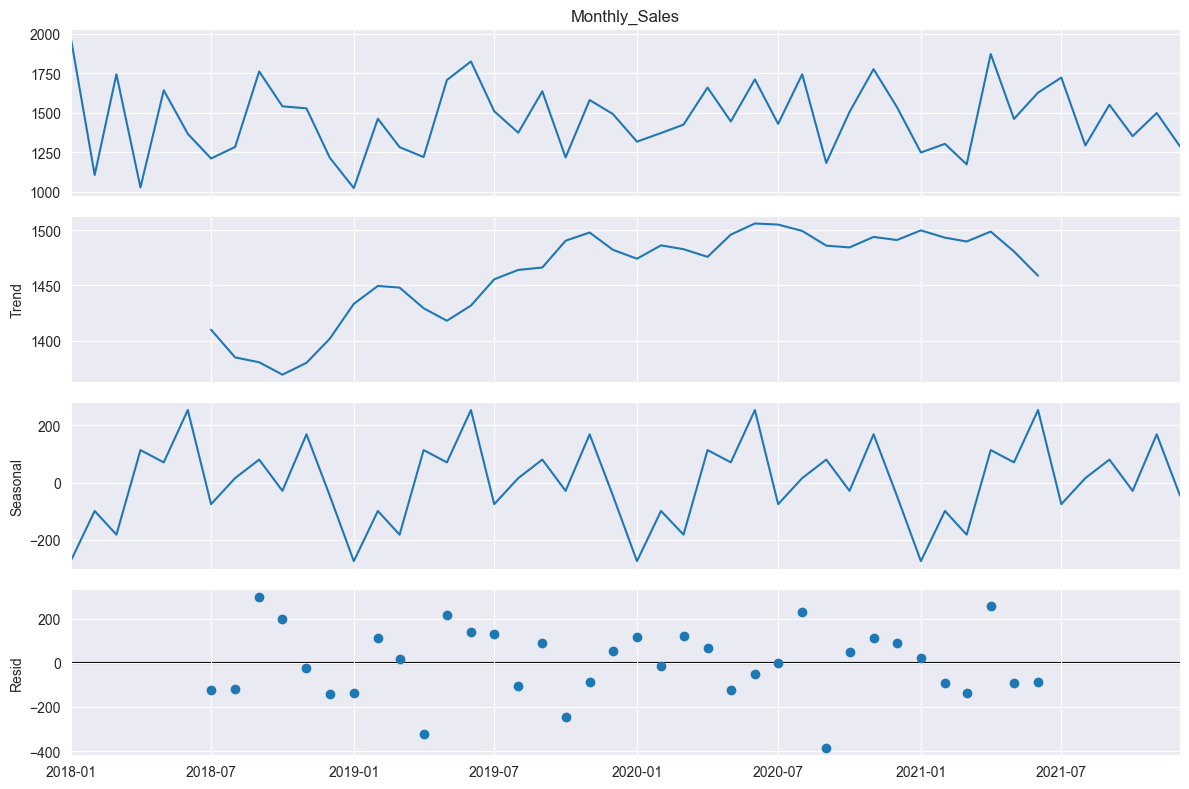

In [69]:
rcParams['figure.figsize'] = 12,8
decomposition_co = sm.tsa.seasonal_decompose(y_co, model='additive')
fig = decomposition_co.plot()
plt.show()

- From the trend graph, there is gradual rise in sales till 2020 with some slight falls in between, the overall trend remains to be in a upward direction.

### Flour

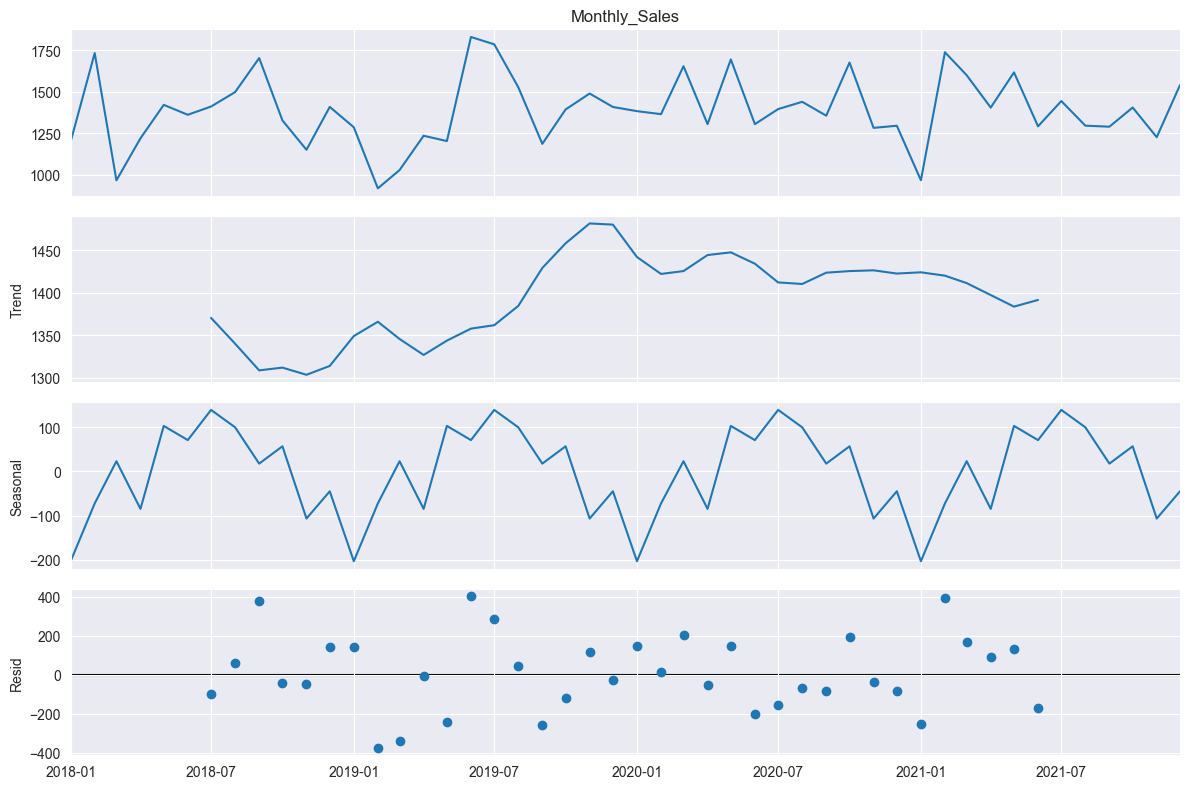

In [70]:
rcParams['figure.figsize'] = 12,8
decomposition_fl = sm.tsa.seasonal_decompose(y_fl, model='additive')
fig = decomposition_fl.plot()
plt.show()

- From the trend graph,there is a rise in curve and reaches a maximum in the later half of 2019 after that there is fall in sales till 2020.

## Test for stationarity

In [71]:
#Augmented dickey-fuller test
#H0 : data is non stationary (unit root =1)
#H1 : data is stationery (unit root <1)

def adfuller_test(series):
    result = adfuller(series)
    labels = ['ADF test statistic', 'p-value', 'Number of observations used', '#lags used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [72]:
adfuller_test(y_tp)

ADF test statistic : -6.69697941923438
p-value : 3.9767707113015465e-09
Number of observations used : 0
#lags used : 47
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [73]:
adfuller_test(y_ch)

ADF test statistic : -5.691572977629727
p-value : 8.048605773917482e-07
Number of observations used : 0
#lags used : 47
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [74]:
adfuller_test(y_pb)

ADF test statistic : -5.822709895728212
p-value : 4.1470013833588027e-07
Number of observations used : 1
#lags used : 46
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [75]:
adfuller_test(y_co)

ADF test statistic : -8.849675594487914
p-value : 1.5854121254606258e-14
Number of observations used : 0
#lags used : 47
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [76]:
adfuller_test(y_fl)

ADF test statistic : -6.381270729571798
p-value : 2.2192785985750544e-08
Number of observations used : 0
#lags used : 47
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


#### Findings:
 - The p-value<0.05, so rejecting null hypothesis and assume a stationery datasets.
 - Here the differencing value (d) is zero.

## Parameter selection

Parameters of the ARIMA model are defined by
 - AR(p)-lag order
 - I(d) -degree of difference
 - MA(q) - order of moving average
    
SARIMAX an extension of ARIMA supports time series data with a seasonal component. it is denoted by order (p,d,q)(P,D,Q)m.
 - P - Seasonal regression
 - D - differencing
 - Q - moving average coefficients
 - m - no.of datapoints in each seasonal cycle

#### Here the approach used to find optimal parameters for SARIMA model is by using sarimax function of statsmodel.


### Toilet Paper

In [77]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod_tp = sm.tsa.statespace.SARIMAX(y_tp,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results_tp = mod_tp.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_tp.aic))
        except:
          continue


ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:823.479337755835
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1366.2474575446015
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:493.9266443768458
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:331.97029557681543
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:513.6433357387264
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1277.5821094607845
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:346.1471838081171


ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:333.8879750913828
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:754.8359772351176
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:2678.9100083627177
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:480.8011515697583
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:318.5435189667237
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:513.1033719048096
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:1377.0128133944504
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:347.21521749038027
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:320.53929603680103
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:659.6751114229028
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1206.7940775630652
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:495.26673316230426
ARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:328.80010725570963
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:501.9238678973845
ARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:1311.000441288002
ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:343.7669665311672
ARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:330.58764702027656
ARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:620.2856742812423
ARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:658

AIC estimates relative quality of model and desired result is to find lowest possible AIC score.
The (p,d,q)(P,D,Q,m) order (0, 1, 1)(0, 1, 1, 12) have lower AIC value of 307.35.

In [78]:
mod_tp = sm.tsa.statespace.SARIMAX(y_tp,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_invertibility=False)
results_tp = mod_tp.fit()
print(results_tp.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8909      0.134     -6.647      0.000      -1.154      -0.628
ma.S.L12      -0.3921      0.304     -1.288      0.198      -0.989       0.205
sigma2      8.136e+04   2.65e+04      3.073      0.002    2.95e+04    1.33e+05


#### Model diagnosis

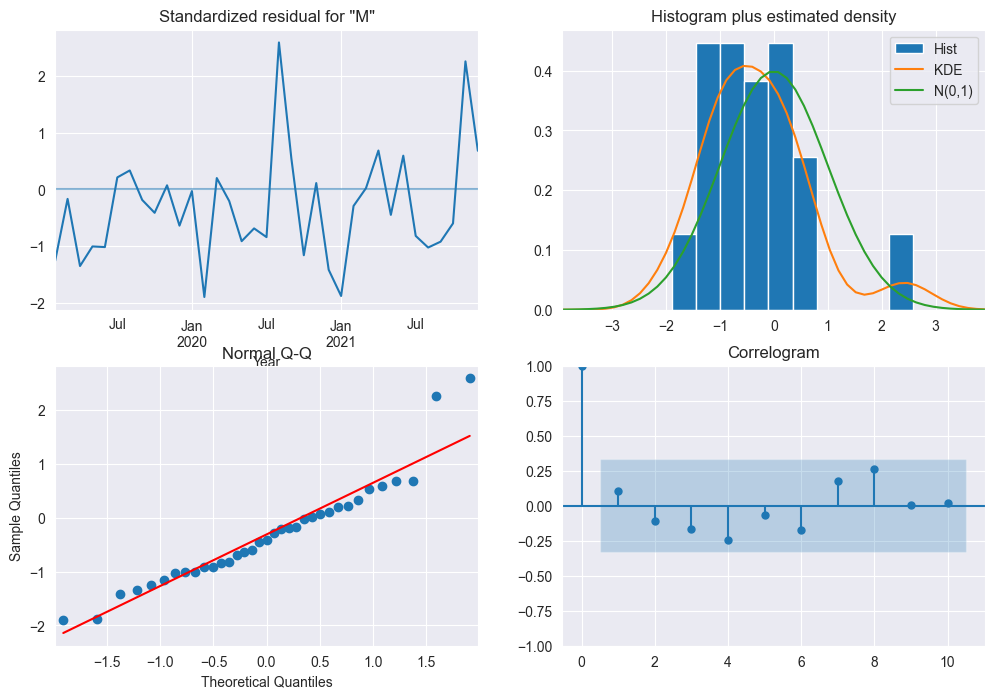

In [79]:
results_tp.plot_diagnostics(figsize=(12, 8))
plt.show()

- From above plots,it is clear that the residuals are almost normally distributed and uncorrelated.

#### Visualising Forecasts

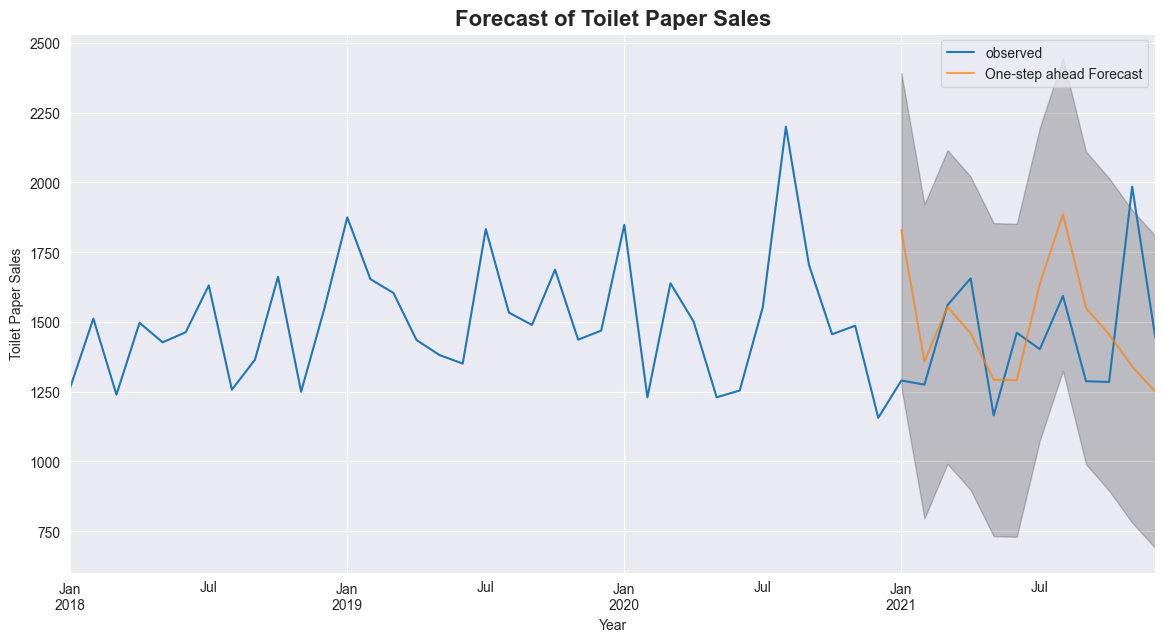

In [80]:
pred = results_tp.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic = False)
pred_ci = pred.conf_int()
ax = y_tp['2018':].plot(label = 'observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast' , alpha = .7, figsize=(14,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha= .2)
plt.title('Forecast of Toilet Paper Sales', fontsize=16, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Toilet Paper Sales')
plt.legend()
plt.show()

In [81]:
y_forecasted = pred.predicted_mean
y_truth = y_tp['2021-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 89555.88
The Root Mean Squared Error of our forecasts is 299.26


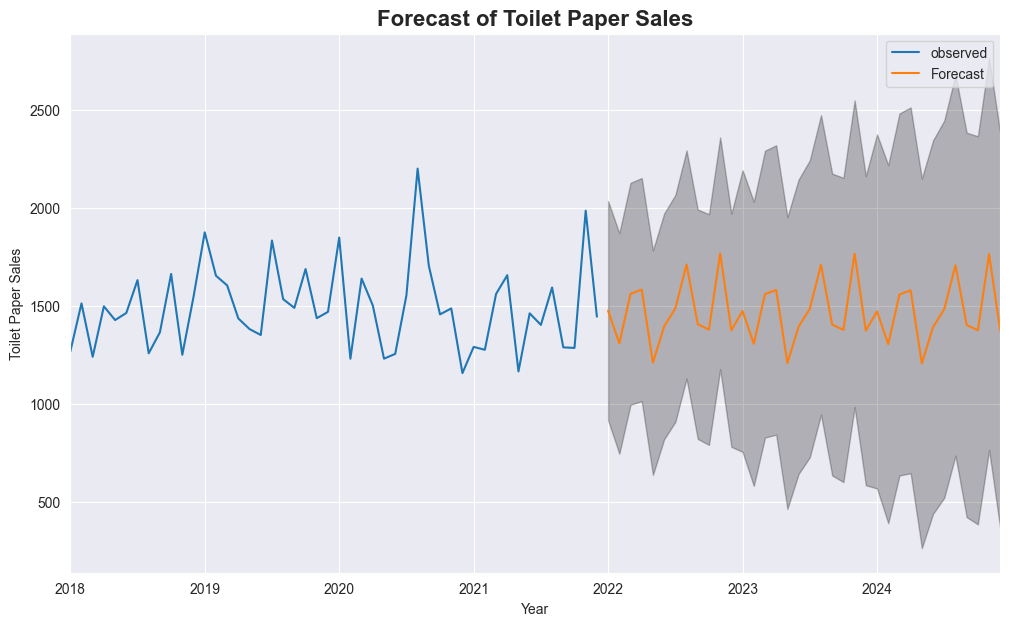

In [82]:

pred_uc = results_tp.get_forecast(steps = 36)
pred_ci = pred_uc.conf_int()
ax = y_tp.plot(label='observed', figsize = (12, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = .25)
plt.title('Forecast of Toilet Paper Sales', fontsize=16, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Toilet Paper Sales')
plt.legend()
plt.show()

- Here also Forecasts shows that the time series model is expected to be stable in the range 1200-1700.

### Chitos

In [83]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod_ch = sm.tsa.statespace.SARIMAX(y_ch,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results_ch = mod_ch.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_ch.aic))
        except:
          continue


ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:821.1855276666354
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1808.5643739017996
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:503.79670515785193
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:331.21257348697935
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:516.9697421222539
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:501.5365944047942
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:348.80101920771915
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:332.7699261285497
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:752.9096434516241
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:2901.2296814785523
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:482.80797553957973
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:313.85249464233004
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:519.6948992207608
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:485.20555099063233
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:348.37800159069263
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:313.8301336360898
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:647.0311625950179
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1403.357622967398
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:49

ARIMA(p,d,q)(P,D,Q)m with order (1,1,1) and seasonal order (0, 1, 1, 12) have lowest AIC score.


In [84]:
mod_ch = sm.tsa.statespace.SARIMAX(y_ch,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_invertibility=False)
results_ch = mod_ch.fit()
print(results_ch.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2841      0.163      1.739      0.082      -0.036       0.604
ma.L1         -1.0000      0.305     -3.274      0.001      -1.599      -0.401
ma.S.L12      -0.6516      0.405     -1.607      0.108      -1.446       0.143
sigma2      6.742e+04   4.53e-06   1.49e+10      0.000    6.74e+04    6.74e+04


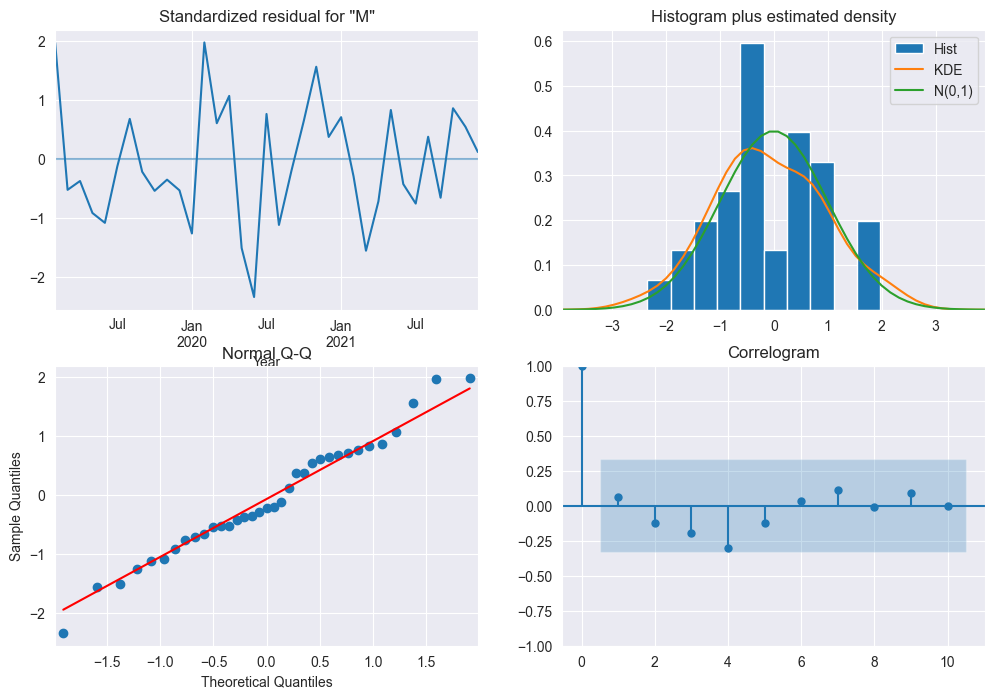

In [85]:
results_ch.plot_diagnostics(figsize=(12, 8))
plt.show()

- Here the residuals are almost normally distributed and correlation plot shows uncorrelated.

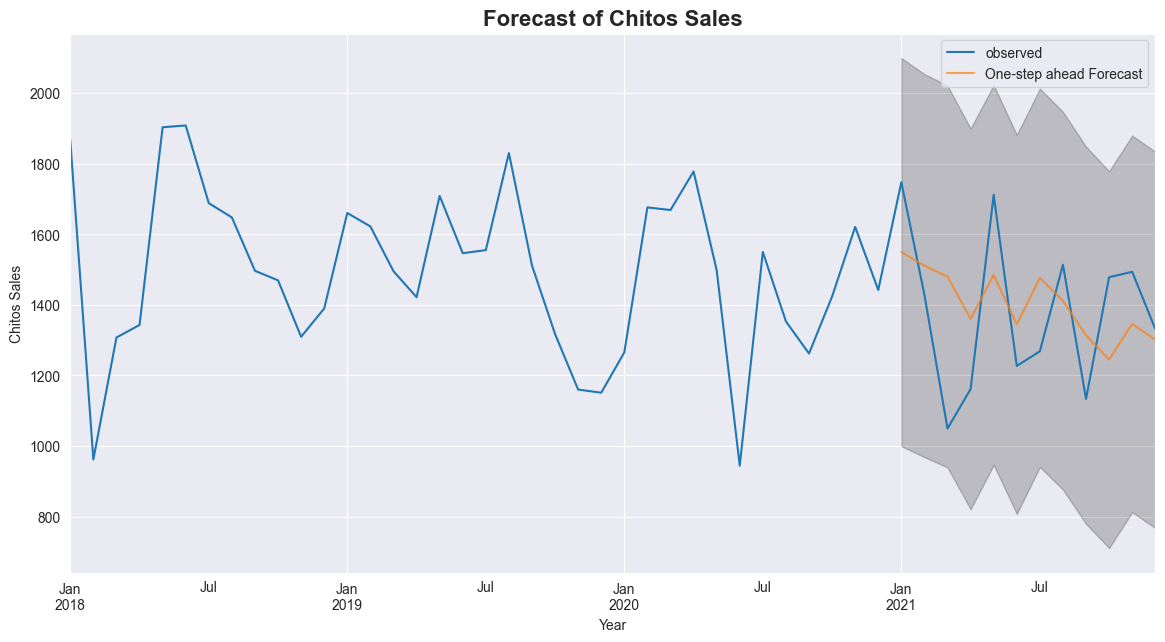

In [86]:
pred = results_ch.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic = False)
pred_ci = pred.conf_int()
ax = y_ch['2018':].plot(label = 'observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast' , alpha = .7, figsize=(14,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha= .2)
plt.title('Forecast of Chitos Sales', fontsize=16, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Chitos Sales')
plt.legend()
plt.show()

In [87]:
y_forecasted = pred.predicted_mean
y_truth = y_ch['2021-01-01' :]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 41633.74
The Root Mean Squared Error of our forecasts is 204.04


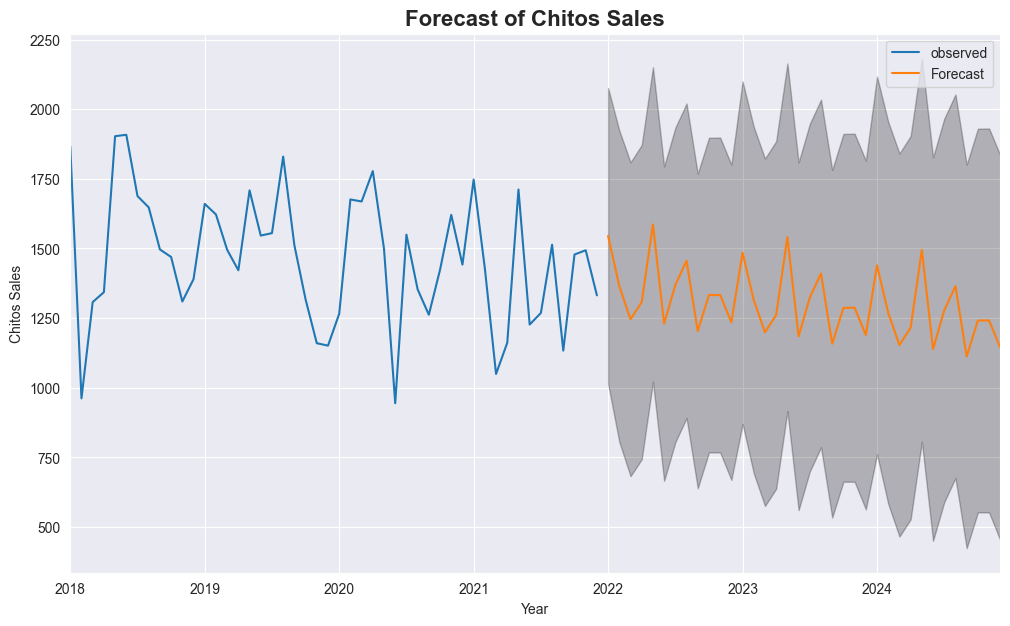

In [88]:
pred_uc = results_ch.get_forecast(steps = 36)
pred_ci = pred_uc.conf_int()
ax = y_ch.plot(label='observed', figsize = (12, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = .25)
plt.title('Forecast of Chitos Sales', fontsize=16, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Chitos Sales')
plt.legend()
plt.show()

- Here, Forecasts shows that the time series model is expected to slightly decrease.

### Peanut Butter

In [89]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod_pb = sm.tsa.statespace.SARIMAX(y_pb,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results_pb = mod_pb.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_pb.aic))
        except:
          continue


ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:824.0181807636943
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1647.7535045875002
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:497.80697477118537
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:319.97229200310414
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:511.7130654343652
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:492.2277414127206
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:334.26581452592063
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:321.80537988988584
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:754.9417670265968
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:2808.7301460016215
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:480.3563830808737
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:307.88035075157626
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:514.1986341829552
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:479.3329516836105
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:336.2347104808832
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:309.87993102035995
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:644.4216848331638
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1328.61903964745
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:497.

ARIMA(p,d,q)(P,D,Q)m with order (0,1,1) and seasonal order (0,1,1,12) have lowest AIC score.

In [90]:
mod_pb = sm.tsa.statespace.SARIMAX(y_pb,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_invertibility=False)
results_pb = mod_pb.fit()
print(results_pb.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000   1445.924     -0.001      0.999   -2834.958    2832.958
ma.S.L12      -1.0002   1445.866     -0.001      0.999   -2834.845    2832.844
sigma2      4.422e+04      0.021   2.13e+06      0.000    4.42e+04    4.42e+04


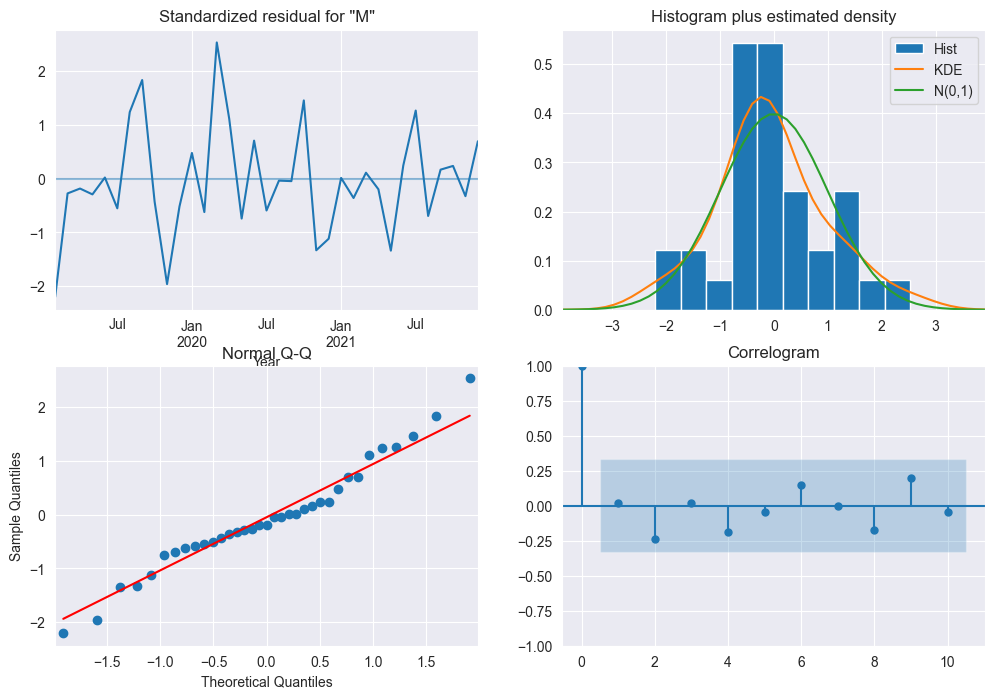

In [91]:
results_pb.plot_diagnostics(figsize=(12, 8))
plt.show()

- Above plots shows that the residuals are normally distributed and uncorrelated.

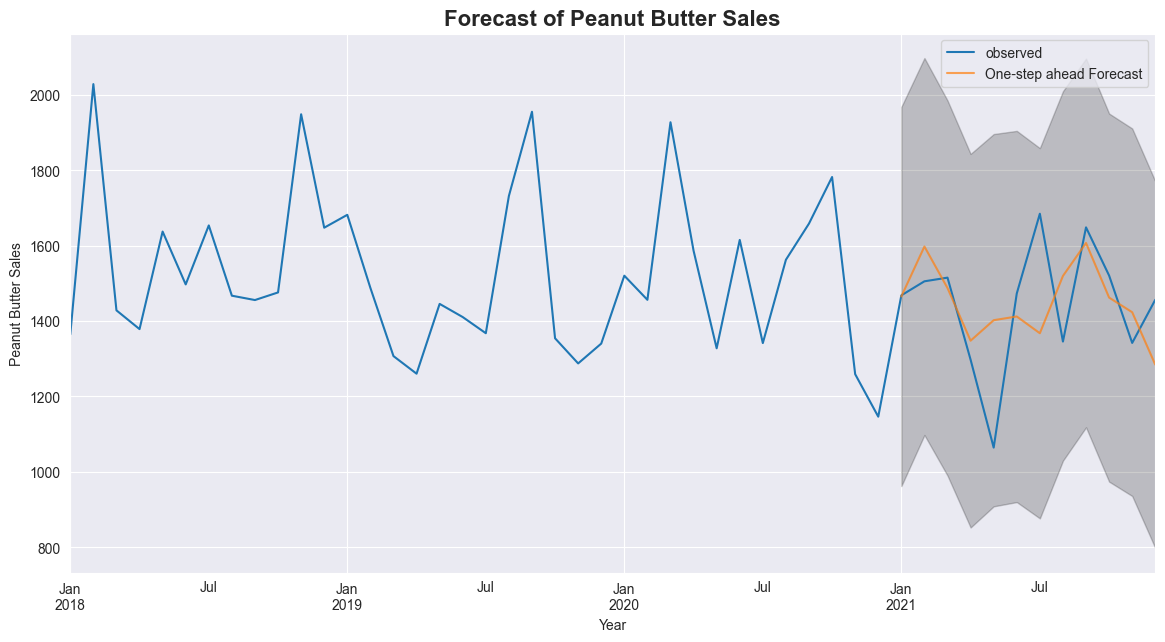

In [92]:
pred = results_pb.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic = False)
pred_ci = pred.conf_int()
ax = y_pb['2018':].plot(label = 'observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast' , alpha = .7, figsize=(14,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha= .2)
plt.title('Forecast of Peanut Butter Sales', fontsize=16, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Peanut Butter Sales')
plt.legend()
plt.show()

In [93]:
y_forecasted = pred.predicted_mean
y_truth = y_pb['2021-01-01' :]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 25163.63
The Root Mean Squared Error of our forecasts is 158.63


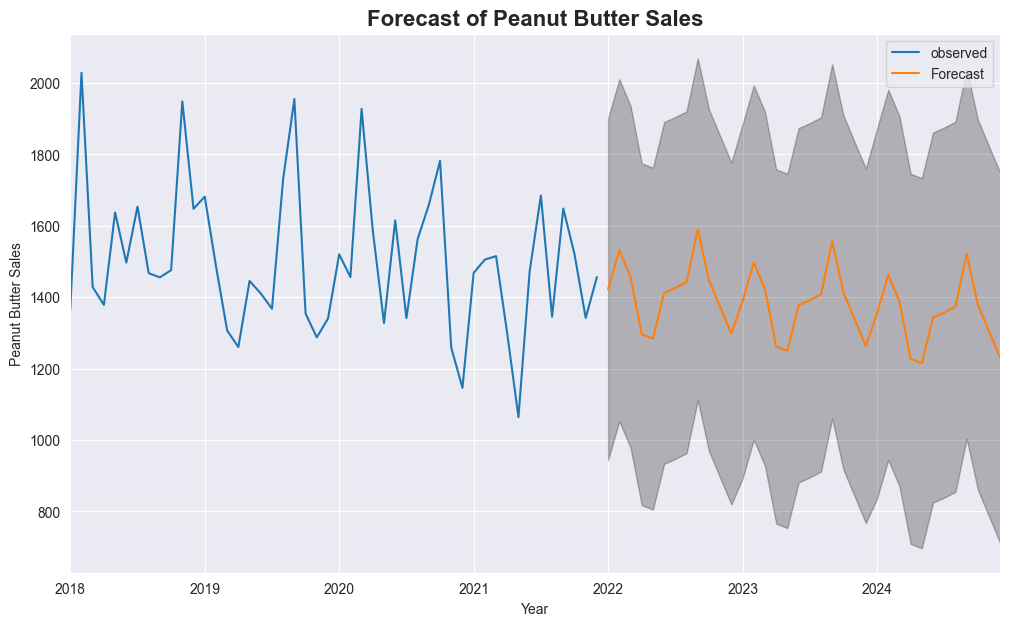

In [94]:
pred_uc = results_pb.get_forecast(steps = 36)
pred_ci = pred_uc.conf_int()
ax = y_pb.plot(label='observed', figsize = (12, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = .25)
plt.title('Forecast of Peanut Butter Sales', fontsize=16, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Peanut Butter Sales')
plt.legend()
plt.show()

- Forecasts shows that the time series model is expected to slightly decrease.

### Conditioner

In [95]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod_co = sm.tsa.statespace.SARIMAX(y_co,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results_co = mod_co.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_co.aic))
        except:
          continue


ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:820.7470157745001
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1616.5927662137276
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:491.9384233432663
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:321.76527312919706
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:517.7919767802242
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:493.8256328773618
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:334.4645861610401
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:323.6618902112431
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:759.3014717756037
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:2839.916144848918
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:477.62168940356185
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:306.0763646548768
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:516.7813126402648
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:479.04356033104233
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:331.2130124396897
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:307.6435648322767
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:664.880188243542
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1069.3853123734696
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:508.320

ARIMA(p,d,q)(P,D,Q)m with order (1,1,1) and seasonal order (0,1,1,12) have lowest AIC score.

In [96]:
mod_co = sm.tsa.statespace.SARIMAX(y_co,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_invertibility=False)
results_co = mod_co.fit()
print(results_co.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3433      0.185     -1.855      0.064      -0.706       0.019
ma.L1         -1.0000      0.367     -2.727      0.006      -1.719      -0.281
ma.S.L12      -0.5403      0.340     -1.591      0.112      -1.206       0.125
sigma2      6.854e+04   5.35e-06   1.28e+10      0.000    6.85e+04    6.85e+04


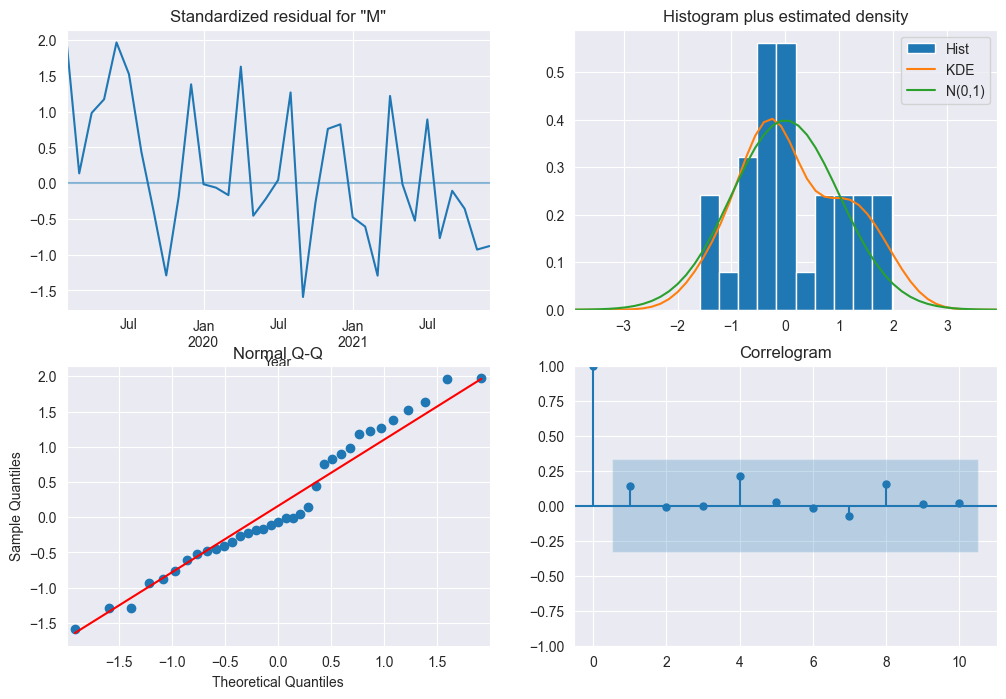

In [97]:
results_co.plot_diagnostics(figsize=(12, 8))
plt.show()

- From above plots,it is clear that the residuals are almost normally distributed and uncorrelated.

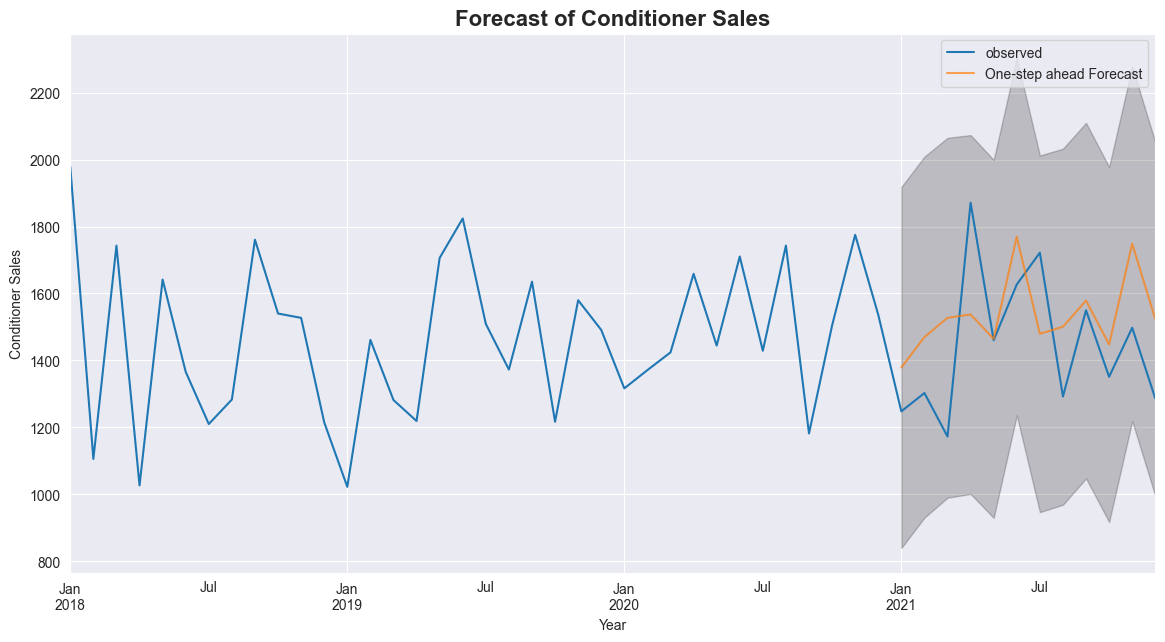

In [98]:
pred = results_co.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic = False)
pred_ci = pred.conf_int()
ax = y_co['2018':].plot(label = 'observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast' , alpha = .7, figsize=(14,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha= .2)
plt.title('Forecast of Conditioner Sales', fontsize=16, fontweight='bold')

ax.set_xlabel('Year')
ax.set_ylabel('Conditioner Sales')
plt.legend()
plt.show()

In [99]:
y_forecasted = pred.predicted_mean
y_truth = y_co['2021-01-01' :]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 44521.87
The Root Mean Squared Error of our forecasts is 211.0


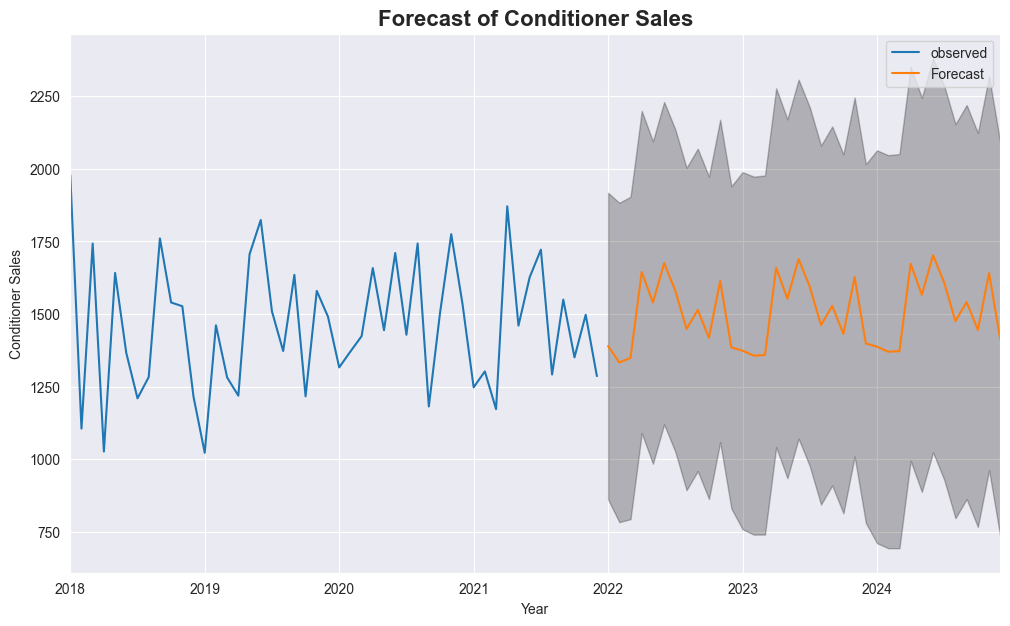

In [100]:
pred_uc = results_co.get_forecast(steps = 36)
pred_ci = pred_uc.conf_int()
ax = y_co.plot(label='observed', figsize = (12, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = .25)
plt.title('Forecast of Conditioner Sales', fontsize=16, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Conditioner Sales')
plt.legend()
plt.show()

- Here Forecasts shows that the time series model is expected to slightly increase.

### Flour

In [101]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod_fl = sm.tsa.statespace.SARIMAX(y_fl,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results_fl = mod_fl.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_fl.aic))
        except:
          continue


ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:816.9544724828095
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:879.1676174422074
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:503.31144840652286
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:323.4858668930672
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:518.5002165534893
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:500.42476529223023
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:338.6858724693665
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:325.1128777972033
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:747.3309435654418
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:2783.6211299484758
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:484.2941842415928
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:313.2154666354426
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:520.2826405225267
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:485.0940309175979
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:340.5419532938454
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:315.214505267091
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:652.2863306460889
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1338.5472340372035
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:506.6181

ARIMA(p,d,q)(P,D,Q)m with order (1,1,1) and seasonal order (0,1,1,12) have lowest AIC score.

In [102]:
mod_fl = sm.tsa.statespace.SARIMAX(y_fl,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_invertibility=False)
results_fl = mod_fl.fit()
print(results_fl.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0865      0.235      0.367      0.713      -0.375       0.548
ma.L1         -1.0000    800.531     -0.001      0.999   -1570.012    1568.012
ma.S.L12      -1.0002    800.528     -0.001      0.999   -1570.007    1568.006
sigma2      5.016e+04      0.003   1.57e+07      0.000    5.02e+04    5.02e+04


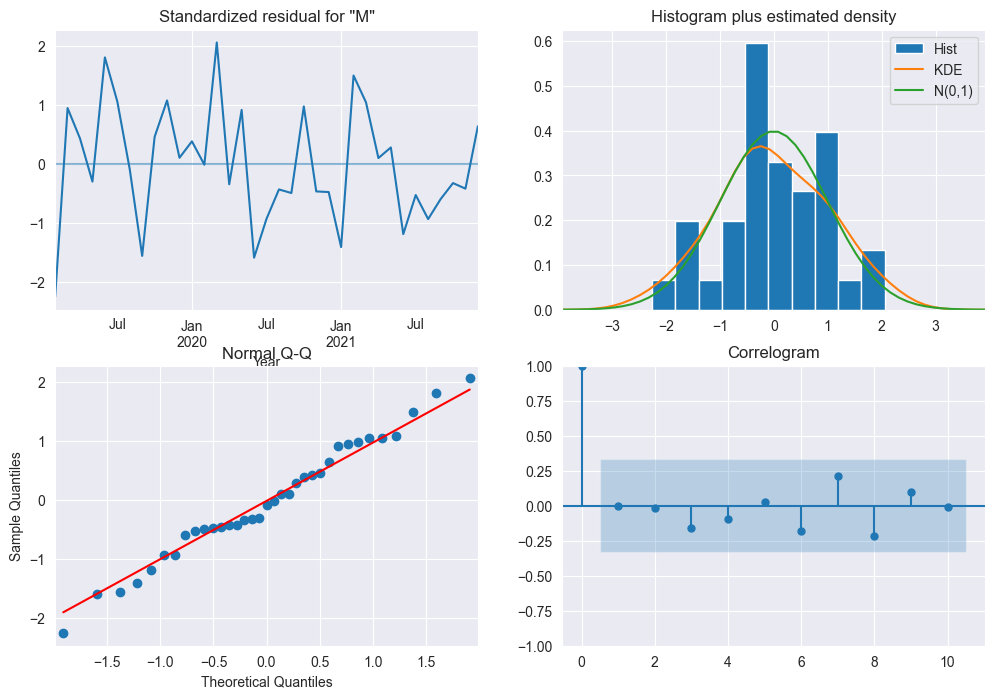

In [103]:
results_fl.plot_diagnostics(figsize=(12, 8))
plt.show()

- From above plots,it is clear that the residuals are normally distributed and uncorrelated.

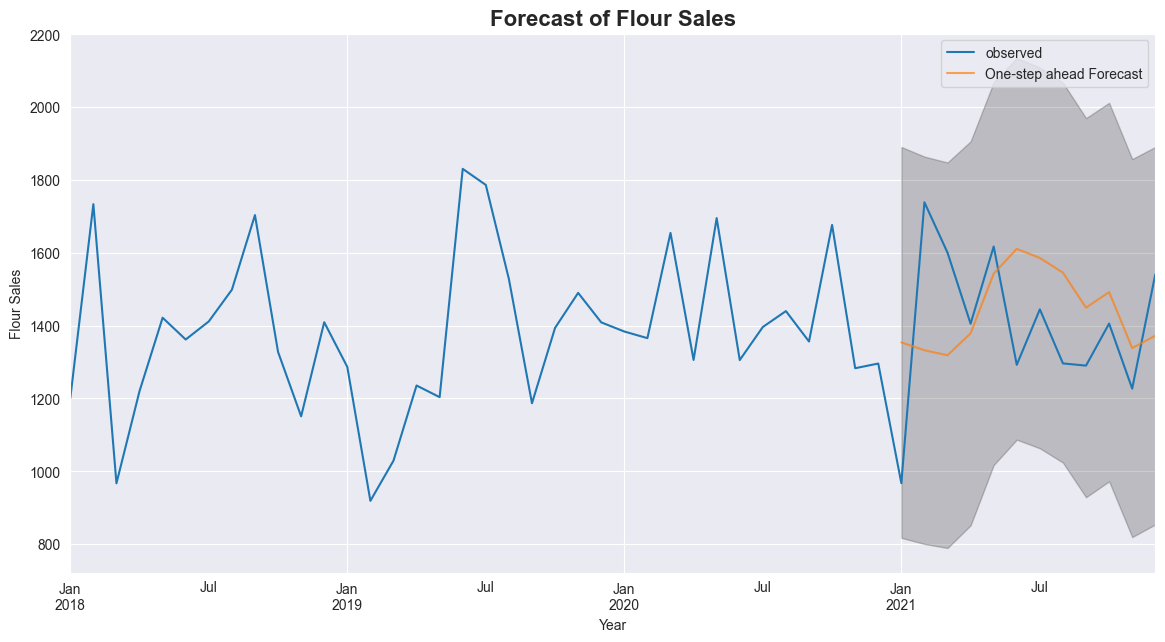

In [104]:
pred = results_fl.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic = False)
pred_ci = pred.conf_int()
ax = y_fl['2018':].plot(label = 'observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast' , alpha = .7, figsize=(14,7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha= .2)
plt.title('Forecast of Flour Sales', fontsize=16, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Flour Sales')
plt.legend()
plt.show()

In [105]:
y_forecasted = pred.predicted_mean
y_truth = y_fl['2021-01-01' :]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 54748.26
The Root Mean Squared Error of our forecasts is 233.98


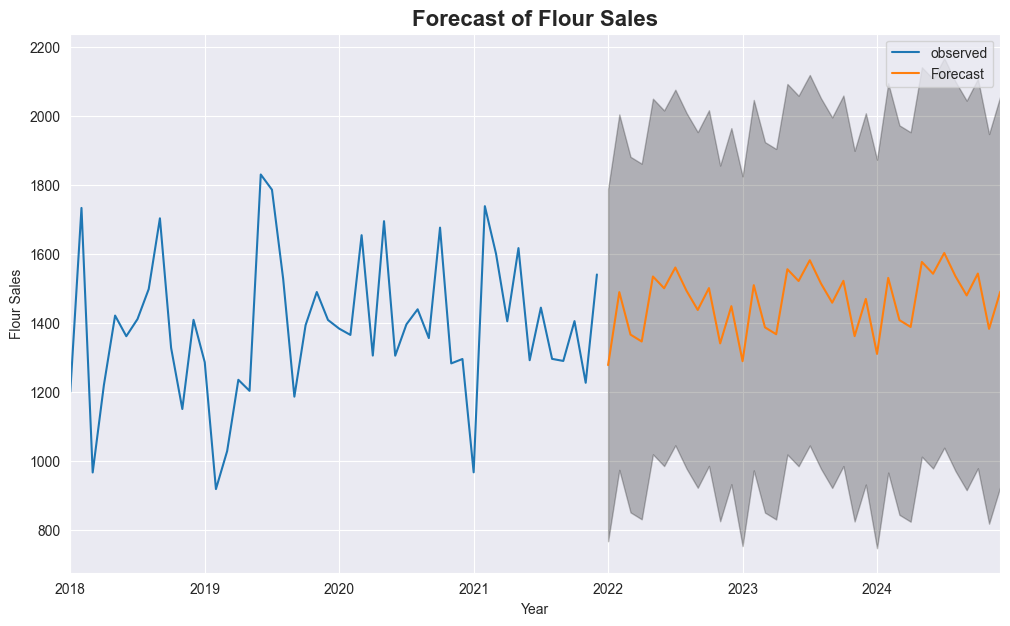

In [106]:
pred_uc = results_fl.get_forecast(steps = 36)
pred_ci = pred_uc.conf_int()
ax = y_fl.plot(label='observed', figsize = (12, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = .25)
plt.title('Forecast of Flour Sales', fontsize=16, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Flour Sales')
plt.legend()
plt.show()

- Forecasts shows that the time series model is expected to slightly increasing.

## Comparing Products over historical sales

### Toiletpaper vs Chitos Sales

In [107]:
toiletpaper = pd.DataFrame({'Year':y_tp.index, 'Monthly_Sales':y_tp.values})
toiletpaper.head()

Year  Monthly_Sales
0 2018-01-01    1265.576923
1 2018-02-01    1511.952381
2 2018-03-01    1239.214286
3 2018-04-01    1496.920000
4 2018-05-01    1426.846154

In [108]:
chitos = pd.DataFrame({'Year':y_ch.index, 'Monthly_Sales': y_ch.values})
chitos.head()

Year  Monthly_Sales
0 2018-01-01    1866.035714
1 2018-02-01     962.000000
2 2018-03-01    1307.482759
3 2018-04-01    1343.000000
4 2018-05-01    1902.956522

In [109]:
store = toiletpaper.merge(chitos,how= 'inner',on='Year')
store.rename(columns={'Monthly_Sales_x': 'toiletpaper_sales', 'Monthly_Sales_y': 'chitos_sales'}, inplace = True)
store.head()

Year  toiletpaper_sales  chitos_sales
0 2018-01-01        1265.576923   1866.035714
1 2018-02-01        1511.952381    962.000000
2 2018-03-01        1239.214286   1307.482759
3 2018-04-01        1496.920000   1343.000000
4 2018-05-01        1426.846154   1902.956522

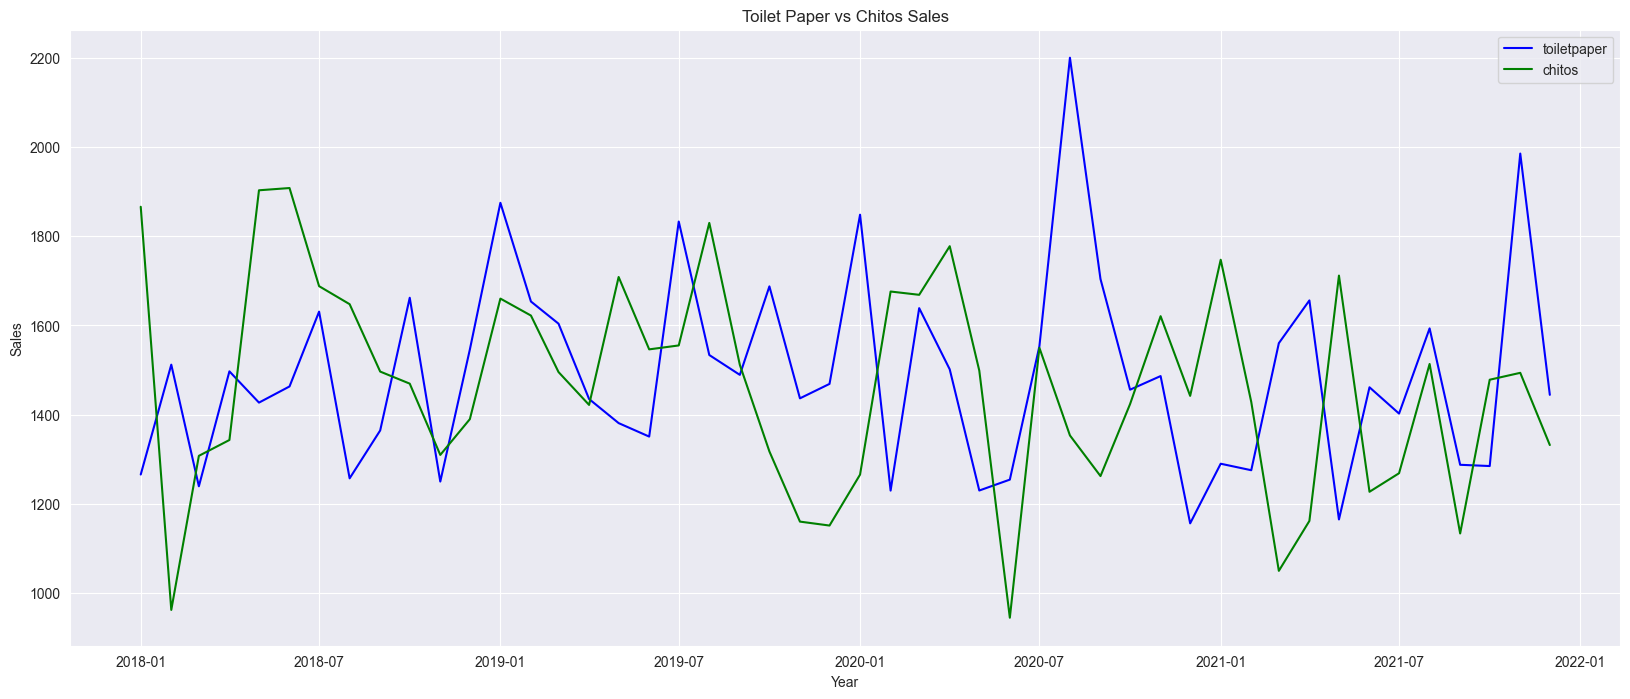

In [110]:
plt.figure(figsize=(20,8))
plt.plot(store['Year'], store['toiletpaper_sales'], 'b-', label = 'toiletpaper')
plt.plot(store['Year'], store['chitos_sales'], 'g-', label = 'chitos')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Toilet Paper vs Chitos Sales')
plt.legend(["toiletpaper","chitos"],loc= "upper right")

 - Sales of both product categories is slightly decreasing over years.
 - For toilet paper, it shows high sales during the month of august 2020 and november 2021.
 - Chitos have high sales during june 2018 and lower sales during june of 2020 and march 2021.

### Peanut Butter vs Conditioner Sales


In [111]:
peanut_butter = pd.DataFrame({'Year':y_pb.index, 'Monthly_Sales':y_pb.values})
peanut_butter.head()

Year  Monthly_Sales
0 2018-01-01    1364.360000
1 2018-02-01    2028.416667
2 2018-03-01    1428.320000
3 2018-04-01    1378.576923
4 2018-05-01    1637.280000

In [112]:
conditioner = pd.DataFrame({'Year':y_co.index, 'Monthly_Sales':y_co.values})
conditioner.head()

Year  Monthly_Sales
0 2018-01-01    1978.888889
1 2018-02-01    1105.750000
2 2018-03-01    1742.923077
3 2018-04-01    1026.750000
4 2018-05-01    1641.650000

In [113]:
store = peanut_butter.merge(conditioner,how= 'inner',on='Year')
store.rename(columns={'Monthly_Sales_x': 'peanut_butter_sales', 'Monthly_Sales_y': 'conditioner_sales'}, inplace = True)
store.head()

Year  peanut_butter_sales  conditioner_sales
0 2018-01-01          1364.360000        1978.888889
1 2018-02-01          2028.416667        1105.750000
2 2018-03-01          1428.320000        1742.923077
3 2018-04-01          1378.576923        1026.750000
4 2018-05-01          1637.280000        1641.650000

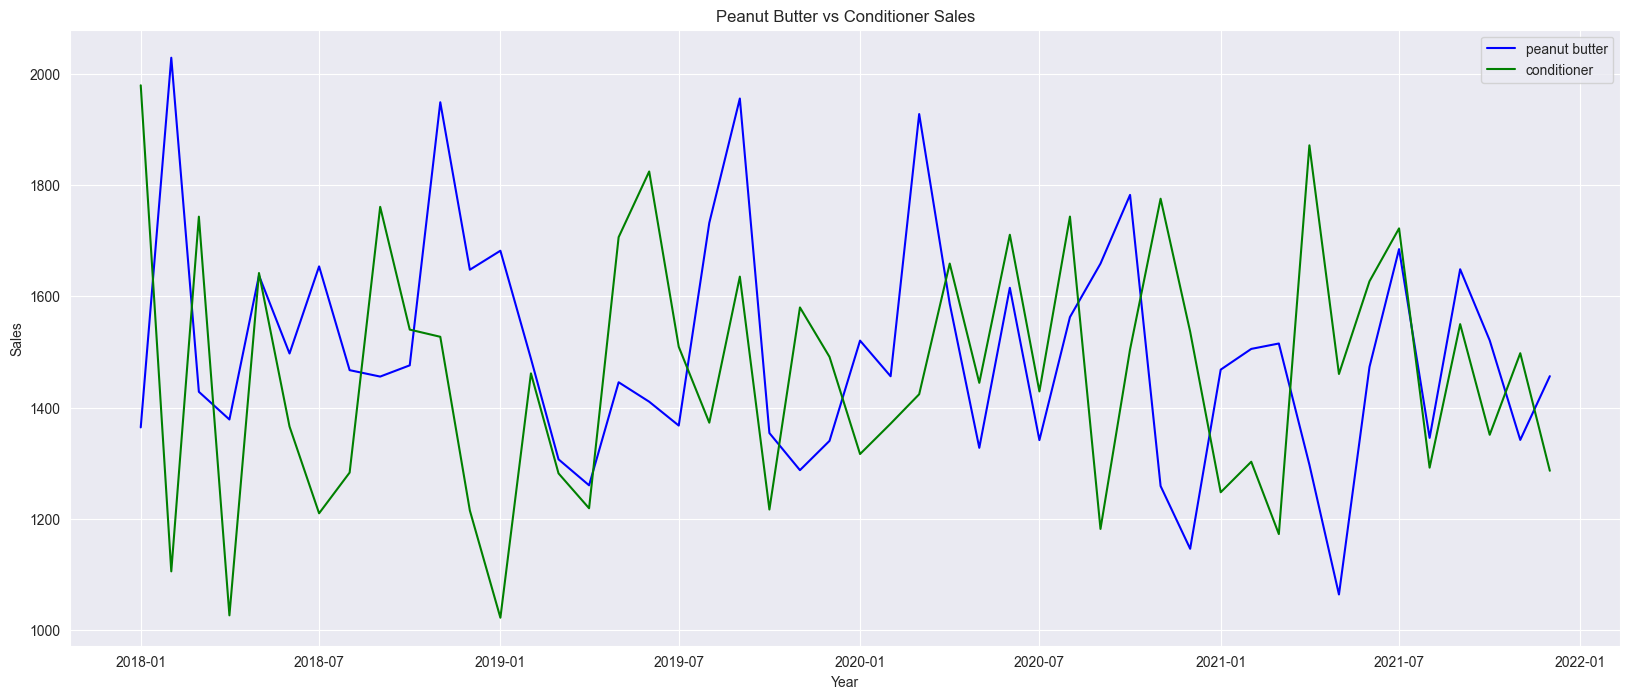

In [114]:
plt.figure(figsize=(20,8))
plt.plot(store['Year'], store['peanut_butter_sales'], 'b-', label = 'peanut_butter')
plt.plot(store['Year'], store['conditioner_sales'], 'g-', label = 'conditioner')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Peanut Butter vs Conditioner Sales')
plt.legend(["peanut butter","conditioner"],loc= "upper right")

 - Higher sales for peanut butter is observed on month of november 2018,september 2019, march of 2020.
 - Higher sales for conditioner was observed on month of june 2019, april 2021.
 - Both of them have lower sales during the end of the year.

### Toilet Paper vs Flour Sales


In [115]:
toiletpaper = pd.DataFrame({'Year':y_tp.index, 'Monthly_Sales': y_tp.values})
toiletpaper.head()

Year  Monthly_Sales
0 2018-01-01    1265.576923
1 2018-02-01    1511.952381
2 2018-03-01    1239.214286
3 2018-04-01    1496.920000
4 2018-05-01    1426.846154

In [116]:
flour = pd.DataFrame({'Year':y_fl.index, 'Monthly_Sales':y_fl.values})
flour.head()

Year  Monthly_Sales
0 2018-01-01    1200.230769
1 2018-02-01    1733.434783
2 2018-03-01     966.916667
3 2018-04-01    1220.080000
4 2018-05-01    1421.590909

In [117]:
store = toiletpaper.merge(flour,how= 'inner',on='Year')
store.rename(columns={'Monthly_Sales_x': 'toiletpaper_sales', 'Monthly_Sales_y': 'flour_sales'}, inplace = True)
store.head()

Year  toiletpaper_sales  flour_sales
0 2018-01-01        1265.576923  1200.230769
1 2018-02-01        1511.952381  1733.434783
2 2018-03-01        1239.214286   966.916667
3 2018-04-01        1496.920000  1220.080000
4 2018-05-01        1426.846154  1421.590909

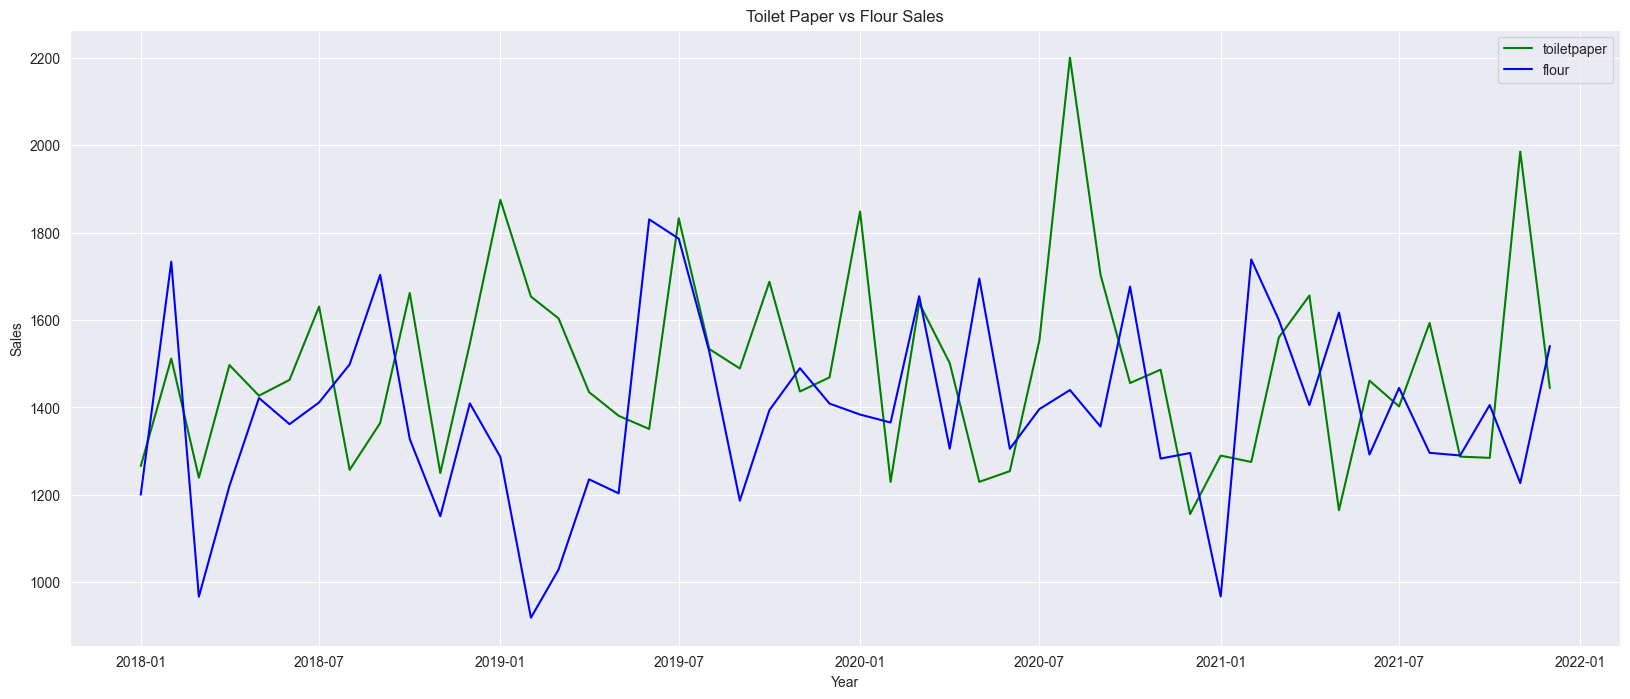

In [118]:
plt.figure(figsize=(20,8))
plt.plot(store['Year'], store['toiletpaper_sales'], 'g-', label = 'toiletpaper')
plt.plot(store['Year'], store['flour_sales'], 'b-', label = 'flour')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Toilet Paper vs Flour Sales')
plt.legend(["toiletpaper","flour"],loc= "upper right")

 - Sales of toiletpaper is increasing over years and that of flour is stable.
 - For toiletpaper, it shows high sales during the month of august 2020 and november 2021.
 - Flour has high sales during september 2014 and lower sales during june of 2019.


### Conditioner vs Flour Sales

In [119]:
conditioner = pd.DataFrame({'Year':y_co.index, 'Monthly_Sales':y_co.values})
conditioner.head()

Year  Monthly_Sales
0 2018-01-01    1978.888889
1 2018-02-01    1105.750000
2 2018-03-01    1742.923077
3 2018-04-01    1026.750000
4 2018-05-01    1641.650000

In [120]:
flour = pd.DataFrame({'Year':y_fl.index, 'Monthly_Sales': y_fl.values})
flour.head()

Year  Monthly_Sales
0 2018-01-01    1200.230769
1 2018-02-01    1733.434783
2 2018-03-01     966.916667
3 2018-04-01    1220.080000
4 2018-05-01    1421.590909

In [121]:
store = conditioner.merge(flour,how= 'inner',on='Year')
store.rename(columns={'Monthly_Sales_x': 'conditioner_sales', 'Monthly_Sales_y': 'flour_sales'}, inplace = True)
store.head()


Year  conditioner_sales  flour_sales
0 2018-01-01        1978.888889  1200.230769
1 2018-02-01        1105.750000  1733.434783
2 2018-03-01        1742.923077   966.916667
3 2018-04-01        1026.750000  1220.080000
4 2018-05-01        1641.650000  1421.590909

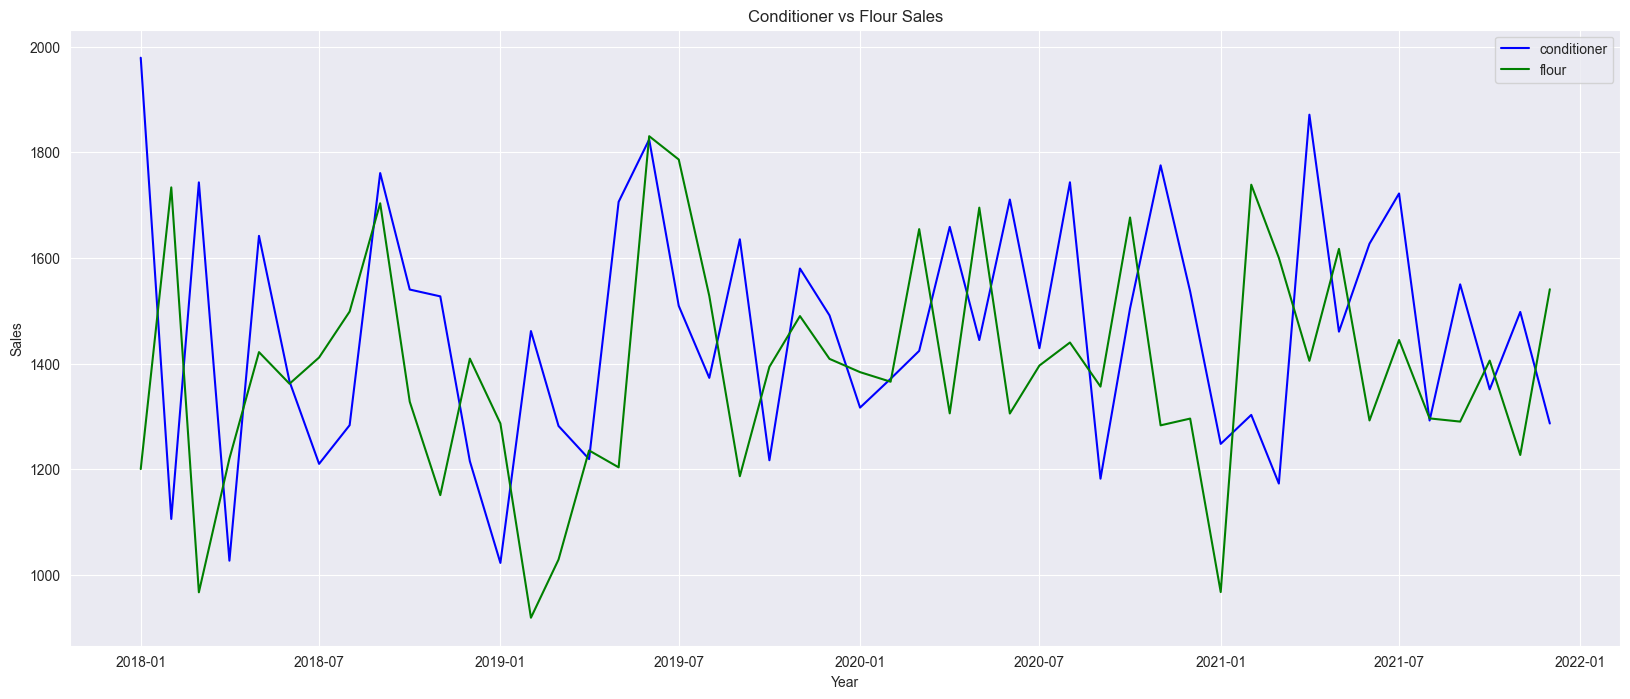

In [122]:
plt.figure(figsize=(20,8))
plt.plot(store['Year'], store['conditioner_sales'], 'b-', label = 'conditioner')
plt.plot(store['Year'], store['flour_sales'], 'g-', label = 'flour')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Conditioner vs Flour Sales')
plt.legend(["conditioner","flour"],loc= "upper right")

 - Higher sales for conditioner is observed on month of june 2019, april in 2021.
 - Higher sales for flour was observed on month of june 2019, february 2021.
 - Both of them have lower sales during the start of the year.

## Forecasting Products using Fbprophet library

### Toilet Paper


In [123]:
toiletpaper = toiletpaper.rename(columns={'Year':'ds', 'Monthly_Sales': 'y'})
toiletpaper

ds            y
0  2018-01-01  1265.576923
1  2018-02-01  1511.952381
2  2018-03-01  1239.214286
3  2018-04-01  1496.920000
4  2018-05-01  1426.846154
5  2018-06-01  1463.083333
6  2018-07-01  1630.833333
7  2018-08-01  1257.038462
8  2018-09-01  1364.384615
9  2018-10-01  1662.000000
10 2018-11-01  1249.800000
11 2018-12-01  1545.851852
12 2019-01-01  1874.892857
13 2019-02-01  1653.541667
14 2019-03-01  1603.809524
15 2019-04-01  1434.923077
16 2019-05-01  1380.880000
17 2019-06-01  1350.650000
18 2019-07-01  1832.923077
19 2019-08-01  1533.576923
20 2019-09-01  1489.041667
21 2019-10-01  1687.478261
22 2019-11-01  1436.407407
23 2019-12-01  1468.807692
24 2020-01-01  1848.222222
25 2020-02-01  1229.545455
26 2020-03-01  1638.650000
27 2020-04-01  1501.416667
28 2020-05-01  1229.730769
29 2020-06-01  1254.150000
30 2020-07-01  1553.269231
31 2020-08-01  2200.217391
32 2020-09-01  1703.962963
33 2020-10-01  1455.807692
34 2020-11-01  1486.375000
35 2020-12-01  1156.107143
36 2021-01-01  1289.800000
37 2021-02-01  1275.227273
38 2021-03-01  1560.148148
39 2021-04-01  1656.000000
40 2021-05-01  1164.809524
41 2021-06-01  1461.208333
42 2021-07-01  1402.240000
43 2021-08-01  1593.269231
44 2021-09-01  1287.416667
45 2021-10-01  1284.607143
46 2021-11-01  1985.296296
47 2021-12-01  1444.230769

In [125]:
import prophet
toiletpaper_model = prophet.Prophet(interval_width=0.95) 
toiletpaper_model.fit(toiletpaper)

toiletpaper_forecast = toiletpaper_model.make_future_dataframe(periods=36, freq='MS')
toiletpaper_forecast = toiletpaper_model.predict(toiletpaper_forecast)
toiletpaper_forecast

14:12:50 - cmdstanpy - INFO - Chain [1] start processing


14:12:50 - cmdstanpy - INFO - Chain [1] done processing


ds        trend   yhat_lower   yhat_upper  trend_lower  \
0  2018-01-01  1457.421800  1172.821601  1760.893955  1457.421800   
1  2018-02-01  1457.521498  1166.058029  1771.403430  1457.521498   
2  2018-03-01  1457.611547  1170.344033  1756.744057  1457.611547   
3  2018-04-01  1457.711245  1192.866577  1811.263691  1457.711245   
4  2018-05-01  1457.807727  1056.628218  1625.787712  1457.807727   
..        ...          ...          ...          ...          ...   
79 2024-08-01  1465.062441  1651.969514  2269.367809  1465.048537   
80 2024-09-01  1465.160553  1237.269017  1834.375906  1465.146091   
81 2024-10-01  1465.255500  1080.897417  1670.252409  1465.240482   
82 2024-11-01  1465.353612  1404.364365  2030.031490  1465.337913   
83 2024-12-01  1465.448559  1018.748286  1641.167042  1465.432099   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0   1457.421800       26.852113             26.852113             26.852113   
1   1457.521498       -6.624287             -6.624287             -6.624287   
2   1457.611547        4.253685              4.253685              4.253685   
3   1457.711245       33.584276             33.584276             33.584276   
4   1457.807727     -121.936274           -121.936274           -121.936274   
..          ...             ...                   ...                   ...   
79  1465.075693      493.367013            493.367013            493.367013   
80  1465.174520       63.171557             63.171557             63.171557   
81  1465.270152      -92.341739            -92.341739            -92.341739   
82  1465.369068      254.850999            254.850999            254.850999   
83  1465.464813     -137.505450           -137.505450           -137.505450   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0    26.852113     26.852113     26.852113                   0.0   
1    -6.624287     -6.624287     -6.624287                   0.0   
2     4.253685      4.253685      4.253685                   0.0   
3    33.584276     33.584276     33.584276                   0.0   
4  -121.936274   -121.936274   -121.936274                   0.0   
..         ...           ...           ...                   ...   
79  493.367013    493.367013    493.367013                   0.0   
80   63.171557     63.171557     63.171557                   0.0   
81  -92.341739    -92.341739    -92.341739                   0.0   
82  254.850999    254.850999    254.850999                   0.0   
83 -137.505450   -137.505450   -137.505450                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                          0.0                         0.0  1484.273913  
1                          0.0                         0.0  1450.897210  
2                          0.0                         0.0  1461.865232  
3                          0.0                         0.0  1491.295520  
4                          0.0                         0.0  1335.871453  
..                         ...                         ...          ...  
79                         0.0                         0.0  1958.429454  
80                         0.0                         0.0  1528.332110  
81                         0.0                         0.0  1372.913761  
82                         0.0                         0.0  1720.204611  
83                         0.0                         0.0  1327.943109  

[84 rows x 16 columns]

In [126]:
toiletpaper_forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

<Figure size 2000x1000 with 0 Axes>

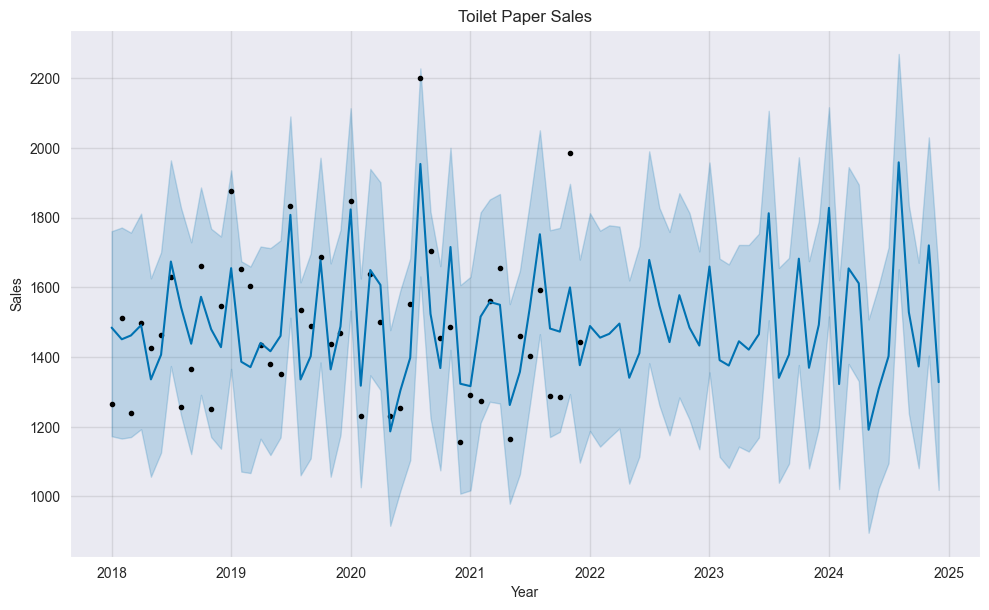

In [127]:

plt.figure(figsize=(20, 10))
toiletpaper_model.plot(toiletpaper_forecast, xlabel='Year', ylabel='Sales')
plt.title('Toilet Paper Sales')
plt.show()


Above plot is forecasting of toilet paper sales for the next three years and it shows increasing trend in sales for the upcoming years.


*   High sales is predicted on June, December of 2023 and June in 2024.
*   Low sales is expected at the beginning of year around January.


In [128]:
plot_components_plotly(toiletpaper_model , toiletpaper_forecast)

- The trend plot shows linearly increasing demand of toilet paper from 2018 to 2025.
- Higher seasonality on August 11, November 14 is predicted from the plot.
- Lower seasonality predicted on January 15, July 18.

### Chitos


In [129]:
chitos = chitos.rename(columns={'Year': 'ds', 'Monthly_Sales': 'y'})
chitos

ds            y
0  2018-01-01  1866.035714
1  2018-02-01   962.000000
2  2018-03-01  1307.482759
3  2018-04-01  1343.000000
4  2018-05-01  1902.956522
5  2018-06-01  1908.000000
6  2018-07-01  1687.960000
7  2018-08-01  1647.555556
8  2018-09-01  1496.440000
9  2018-10-01  1469.370370
10 2018-11-01  1309.541667
11 2018-12-01  1389.730769
12 2019-01-01  1660.080000
13 2019-02-01  1622.052632
14 2019-03-01  1495.320000
15 2019-04-01  1421.678571
16 2019-05-01  1708.500000
17 2019-06-01  1546.238095
18 2019-07-01  1555.045455
19 2019-08-01  1829.800000
20 2019-09-01  1511.500000
21 2019-10-01  1317.360000
22 2019-11-01  1160.000000
23 2019-12-01  1151.166667
24 2020-01-01  1265.360000
25 2020-02-01  1675.956522
26 2020-03-01  1668.555556
27 2020-04-01  1777.583333
28 2020-05-01  1498.560000
29 2020-06-01   944.480000
30 2020-07-01  1549.703704
31 2020-08-01  1353.230769
32 2020-09-01  1262.107143
33 2020-10-01  1423.458333
34 2020-11-01  1620.625000
35 2020-12-01  1441.958333
36 2021-01-01  1747.240000
37 2021-02-01  1428.360000
38 2021-03-01  1049.583333
39 2021-04-01  1161.521739
40 2021-05-01  1711.652174
41 2021-06-01  1226.892857
42 2021-07-01  1268.481481
43 2021-08-01  1513.500000
44 2021-09-01  1133.384615
45 2021-10-01  1478.173913
46 2021-11-01  1493.629630
47 2021-12-01  1331.695652

In [130]:
chitos_model = prophet.Prophet(interval_width=0.95)  
chitos_model.fit(chitos)
chitos_forecast = chitos_model.make_future_dataframe(periods=36, freq='MS')
chitos_forecast = chitos_model.predict(chitos_forecast)
chitos_forecast

14:12:52 - cmdstanpy - INFO - Chain [1] start processing


14:12:52 - cmdstanpy - INFO - Chain [1] done processing


ds        trend   yhat_lower   yhat_upper  trend_lower  \
0  2018-01-01  1676.479464  1416.981541  2067.305782  1676.479464   
1  2018-02-01  1671.910426  1075.760571  1728.120109  1671.910426   
2  2018-03-01  1667.783553  1116.273691  1765.803306  1667.783553   
3  2018-04-01  1663.214514  1097.006067  1745.502704  1663.214514   
4  2018-05-01  1658.792864  1432.716542  2092.396282  1658.792864   
..        ...          ...          ...          ...          ...   
79 2024-08-01  1322.157926   923.013115  1579.780313  1322.157839   
80 2024-09-01  1317.588888   677.828053  1343.601750  1317.588798   
81 2024-10-01  1313.167239   873.044181  1551.021741  1313.167145   
82 2024-11-01  1308.598201  1003.877278  1649.588887  1308.598103   
83 2024-12-01  1304.176551   782.712019  1407.101190  1304.176450   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0   1676.479464       71.078533             71.078533             71.078533   
1   1671.910426     -277.740328           -277.740328           -277.740328   
2   1667.783553     -216.346644           -216.346644           -216.346644   
3   1663.214514     -231.239705           -231.239705           -231.239705   
4   1658.792864      112.588072            112.588072            112.588072   
..          ...             ...                   ...                   ...   
79  1322.158024      -74.390837            -74.390837            -74.390837   
80  1317.588991     -309.906558           -309.906558           -309.906558   
81  1313.167345      -99.829015            -99.829015            -99.829015   
82  1308.598311       -4.970174             -4.970174             -4.970174   
83  1304.176666     -216.764726           -216.764726           -216.764726   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0    71.078533     71.078533     71.078533                   0.0   
1  -277.740328   -277.740328   -277.740328                   0.0   
2  -216.346644   -216.346644   -216.346644                   0.0   
3  -231.239705   -231.239705   -231.239705                   0.0   
4   112.588072    112.588072    112.588072                   0.0   
..         ...           ...           ...                   ...   
79  -74.390837    -74.390837    -74.390837                   0.0   
80 -309.906558   -309.906558   -309.906558                   0.0   
81  -99.829015    -99.829015    -99.829015                   0.0   
82   -4.970174     -4.970174     -4.970174                   0.0   
83 -216.764726   -216.764726   -216.764726                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                          0.0                         0.0  1747.557997  
1                          0.0                         0.0  1394.170098  
2                          0.0                         0.0  1451.436908  
3                          0.0                         0.0  1431.974809  
4                          0.0                         0.0  1771.380936  
..                         ...                         ...          ...  
79                         0.0                         0.0  1247.767089  
80                         0.0                         0.0  1007.682331  
81                         0.0                         0.0  1213.338224  
82                         0.0                         0.0  1303.628027  
83                         0.0                         0.0  1087.411825  

[84 rows x 16 columns]

In [131]:
chitos_forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

<Figure size 2000x1000 with 0 Axes>

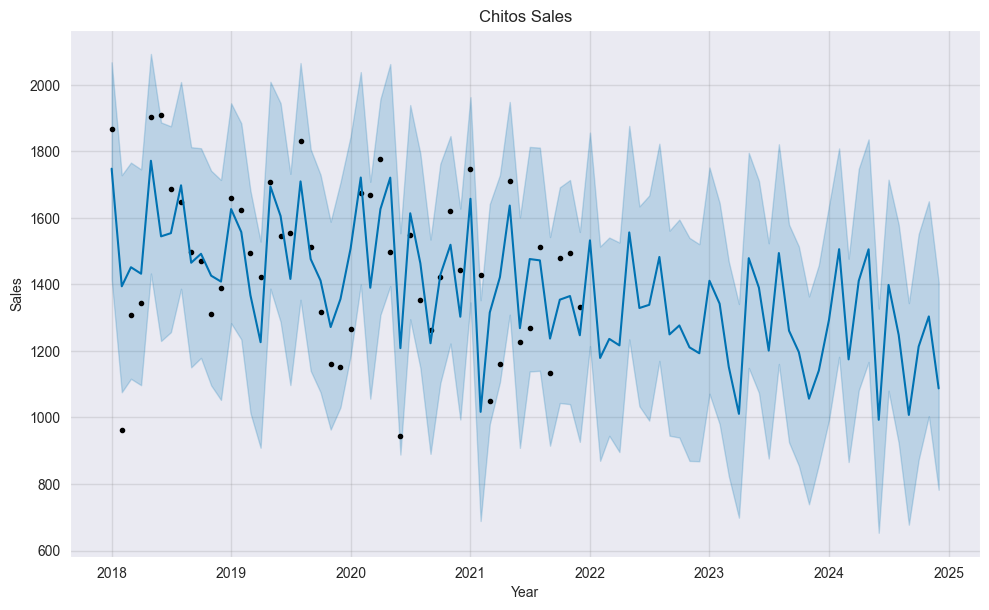

In [132]:
plt.figure(figsize=(20, 10))
chitos_model.plot(chitos_forecast, xlabel='Year', ylabel='Sales')
plt.title('Chitos Sales')
plt.show()

Above plot is forecasting of chitos sales for the next three years and it shows decreasing trend in sales for the upcoming years.


*   High sales is predicted on April 2022, April, July of 2023 and January in 2024.
*   Low sales is expected at the beginning of year around January, February.


In [133]:
plot_components_plotly(chitos_model , chitos_forecast)

- The trend plot shows linearly decreasing demand of chitos from 2018 to 2025.
- Higher seasonality on January 19, May 18 is predicted from the plot.
- Lower seasonality predicted on February 12, March 21.

### Peanut Butter


In [134]:
peanut_butter = peanut_butter.rename(columns={'Year': 'ds', 'Monthly_Sales': 'y'})
peanut_butter

ds            y
0  2018-01-01  1364.360000
1  2018-02-01  2028.416667
2  2018-03-01  1428.320000
3  2018-04-01  1378.576923
4  2018-05-01  1637.280000
5  2018-06-01  1497.125000
6  2018-07-01  1653.583333
7  2018-08-01  1467.192308
8  2018-09-01  1455.666667
9  2018-10-01  1475.851852
10 2018-11-01  1948.384615
11 2018-12-01  1647.571429
12 2019-01-01  1681.720000
13 2019-02-01  1487.869565
14 2019-03-01  1307.000000
15 2019-04-01  1260.347826
16 2019-05-01  1445.476190
17 2019-06-01  1410.523810
18 2019-07-01  1367.666667
19 2019-08-01  1731.821429
20 2019-09-01  1955.100000
21 2019-10-01  1354.217391
22 2019-11-01  1287.565217
23 2019-12-01  1340.173913
24 2020-01-01  1520.260870
25 2020-02-01  1456.240000
26 2020-03-01  1927.208333
27 2020-04-01  1586.423077
28 2020-05-01  1327.650000
29 2020-06-01  1615.173913
30 2020-07-01  1341.520000
31 2020-08-01  1562.500000
32 2020-09-01  1658.555556
33 2020-10-01  1782.000000
34 2020-11-01  1259.038462
35 2020-12-01  1146.333333
36 2021-01-01  1468.125000
37 2021-02-01  1505.363636
38 2021-03-01  1515.076923
39 2021-04-01  1297.423077
40 2021-05-01  1064.240000
41 2021-06-01  1473.047619
42 2021-07-01  1684.629630
43 2021-08-01  1345.500000
44 2021-09-01  1648.440000
45 2021-10-01  1520.629630
46 2021-11-01  1341.909091
47 2021-12-01  1456.407407

In [135]:
peanut_butter_model = prophet.Prophet(interval_width=0.95) 
peanut_butter_model.fit(peanut_butter)
peanut_butter_forecast = peanut_butter_model.make_future_dataframe(periods=36, freq='MS')
peanut_butter_forecast = peanut_butter_model.predict(peanut_butter_forecast)
peanut_butter_forecast

14:12:53 - cmdstanpy - INFO - Chain [1] start processing


14:12:53 - cmdstanpy - INFO - Chain [1] done processing


ds        trend   yhat_lower   yhat_upper  trend_lower  \
0  2018-01-01  1614.025341  1218.376212  1817.059972  1614.025341   
1  2018-02-01  1610.786384  1402.629644  1956.343126  1610.786384   
2  2018-03-01  1607.860875  1239.897030  1824.698099  1607.860875   
3  2018-04-01  1604.621919  1105.951947  1731.046199  1604.621919   
4  2018-05-01  1601.487445  1210.652749  1776.786936  1601.487445   
..        ...          ...          ...          ...          ...   
79 2024-08-01  1362.849500   994.226513  1596.493474  1362.849409   
80 2024-09-01  1359.610544  1178.308587  1739.753838  1359.610450   
81 2024-10-01  1356.476070  1308.770343  1893.094907  1356.475971   
82 2024-11-01  1353.237114   959.671946  1528.693963  1353.237010   
83 2024-12-01  1350.102640   806.861398  1401.898650  1350.102532   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0   1614.025341      -87.554374            -87.554374            -87.554374   
1   1610.786384       68.070898             68.070898             68.070898   
2   1607.860875      -69.411237            -69.411237            -69.411237   
3   1604.621919     -182.714851           -182.714851           -182.714851   
4   1601.487445     -106.622099           -106.622099           -106.622099   
..          ...             ...                   ...                   ...   
79  1362.849598      -59.694543            -59.694543            -59.694543   
80  1359.610647      101.456949            101.456949            101.456949   
81  1356.476179      262.660191            262.660191            262.660191   
82  1353.237227     -125.260199           -125.260199           -125.260199   
83  1350.102758     -225.826857           -225.826857           -225.826857   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0   -87.554374    -87.554374    -87.554374                   0.0   
1    68.070898     68.070898     68.070898                   0.0   
2   -69.411237    -69.411237    -69.411237                   0.0   
3  -182.714851   -182.714851   -182.714851                   0.0   
4  -106.622099   -106.622099   -106.622099                   0.0   
..         ...           ...           ...                   ...   
79  -59.694543    -59.694543    -59.694543                   0.0   
80  101.456949    101.456949    101.456949                   0.0   
81  262.660191    262.660191    262.660191                   0.0   
82 -125.260199   -125.260199   -125.260199                   0.0   
83 -225.826857   -225.826857   -225.826857                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                          0.0                         0.0  1526.470966  
1                          0.0                         0.0  1678.857282  
2                          0.0                         0.0  1538.449638  
3                          0.0                         0.0  1421.907068  
4                          0.0                         0.0  1494.865345  
..                         ...                         ...          ...  
79                         0.0                         0.0  1303.154958  
80                         0.0                         0.0  1461.067493  
81                         0.0                         0.0  1619.136261  
82                         0.0                         0.0  1227.976914  
83                         0.0                         0.0  1124.275783  

[84 rows x 16 columns]

In [136]:
peanut_butter_forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

<Figure size 2000x1000 with 0 Axes>

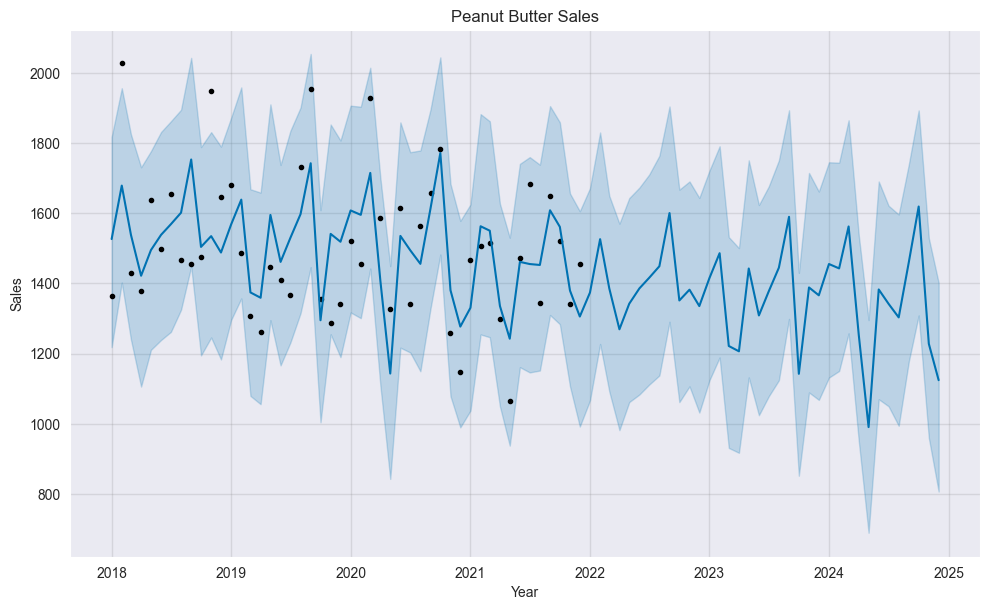

In [137]:
plt.figure(figsize=(20, 10))
peanut_butter_model.plot(peanut_butter_forecast, xlabel='Year', ylabel='Sales')
plt.title('Peanut Butter Sales')
plt.show()

Above plot is forecasting of peanut butter sales for the next three years and it shows stable, but slighly lower trend in sales comparatively for the upcoming years.


*   High sales is predicted on May 2022, July 2023 and June in 2024.
*   Low sales is expected at the beginning of year around February.


In [138]:
plot_components_plotly(peanut_butter_model , peanut_butter_forecast)

- The trend plot shows linearly decreasing demand of peanut butter from 2018 to 2025.
- Higher seasonality on Marxh 12, April 18, October 14 is predicted from the plot.
- Lower seasonality predicted on May 13, September 19.

### Conditioner


In [139]:
conditioner = conditioner.rename(columns={'Year': 'ds', 'Monthly_Sales': 'y'})
conditioner

ds            y
0  2018-01-01  1978.888889
1  2018-02-01  1105.750000
2  2018-03-01  1742.923077
3  2018-04-01  1026.750000
4  2018-05-01  1641.650000
5  2018-06-01  1366.000000
6  2018-07-01  1210.040000
7  2018-08-01  1283.227273
8  2018-09-01  1760.560000
9  2018-10-01  1540.050000
10 2018-11-01  1527.130435
11 2018-12-01  1215.083333
12 2019-01-01  1022.500000
13 2019-02-01  1461.428571
14 2019-03-01  1281.760000
15 2019-04-01  1219.090909
16 2019-05-01  1706.080000
17 2019-06-01  1824.050000
18 2019-07-01  1509.160000
19 2019-08-01  1372.851852
20 2019-09-01  1635.190476
21 2019-10-01  1216.863636
22 2019-11-01  1579.833333
23 2019-12-01  1491.083333
24 2020-01-01  1316.541667
25 2020-02-01  1371.105263
26 2020-03-01  1423.956522
27 2020-04-01  1658.653846
28 2020-05-01  1444.421053
29 2020-06-01  1710.434783
30 2020-07-01  1428.961538
31 2020-08-01  1743.041667
32 2020-09-01  1182.000000
33 2020-10-01  1504.347826
34 2020-11-01  1775.166667
35 2020-12-01  1536.259259
36 2021-01-01  1247.857143
37 2021-02-01  1302.681818
38 2021-03-01  1172.750000
39 2021-04-01  1871.047619
40 2021-05-01  1460.318182
41 2021-06-01  1626.851852
42 2021-07-01  1721.869565
43 2021-08-01  1292.095238
44 2021-09-01  1549.857143
45 2021-10-01  1351.120000
46 2021-11-01  1497.640000
47 2021-12-01  1286.476190

In [140]:
conditioner_model = prophet.Prophet(interval_width=0.95)  # Create an instance of the Prophet class
conditioner_model.fit(conditioner)
conditioner_forecast = conditioner_model.make_future_dataframe(periods=36, freq='MS')
conditioner_forecast = conditioner_model.predict(conditioner_forecast)
conditioner_forecast

14:12:54 - cmdstanpy - INFO - Chain [1] start processing


14:12:54 - cmdstanpy - INFO - Chain [1] done processing


ds        trend   yhat_lower   yhat_upper  trend_lower  \
0  2018-01-01  1483.966799  1088.230764  1747.753226  1483.966799   
1  2018-02-01  1484.280852   929.296801  1621.924920  1484.280852   
2  2018-03-01  1484.564513  1085.082380  1764.129397  1484.564513   
3  2018-04-01  1484.878566   989.184221  1689.903462  1484.878566   
4  2018-05-01  1485.182489  1255.190514  1962.863922  1485.182489   
..        ...          ...          ...          ...          ...   
79 2024-08-01  1508.244762  1230.214899  1936.789675  1508.231471   
80 2024-09-01  1508.557291   939.126532  1635.440125  1508.543707   
81 2024-10-01  1508.859739  1141.586524  1861.523720  1508.845386   
82 2024-11-01  1509.172268  1343.248367  2029.540375  1509.157108   
83 2024-12-01  1509.474715  1047.440361  1720.450489  1509.459221   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0   1483.966799      -74.941512            -74.941512            -74.941512   
1   1484.280852     -224.145873           -224.145873           -224.145873   
2   1484.564513      -59.953491            -59.953491            -59.953491   
3   1484.878566     -142.911934           -142.911934           -142.911934   
4   1485.182489      127.807992            127.807992            127.807992   
..          ...             ...                   ...                   ...   
79  1508.256715       87.310475             87.310475             87.310475   
80  1508.569552     -209.827702           -209.827702           -209.827702   
81  1508.872716       -7.826590             -7.826590             -7.826590   
82  1509.185916      158.930083            158.930083            158.930083   
83  1509.488966     -116.739373           -116.739373           -116.739373   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0   -74.941512    -74.941512    -74.941512                   0.0   
1  -224.145873   -224.145873   -224.145873                   0.0   
2   -59.953491    -59.953491    -59.953491                   0.0   
3  -142.911934   -142.911934   -142.911934                   0.0   
4   127.807992    127.807992    127.807992                   0.0   
..         ...           ...           ...                   ...   
79   87.310475     87.310475     87.310475                   0.0   
80 -209.827702   -209.827702   -209.827702                   0.0   
81   -7.826590     -7.826590     -7.826590                   0.0   
82  158.930083    158.930083    158.930083                   0.0   
83 -116.739373   -116.739373   -116.739373                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                          0.0                         0.0  1409.025287  
1                          0.0                         0.0  1260.134979  
2                          0.0                         0.0  1424.611022  
3                          0.0                         0.0  1341.966632  
4                          0.0                         0.0  1612.990481  
..                         ...                         ...          ...  
79                         0.0                         0.0  1595.555237  
80                         0.0                         0.0  1298.729589  
81                         0.0                         0.0  1501.033149  
82                         0.0                         0.0  1668.102351  
83                         0.0                         0.0  1392.735342  

[84 rows x 16 columns]

In [141]:
conditioner_forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

<Figure size 2000x1000 with 0 Axes>

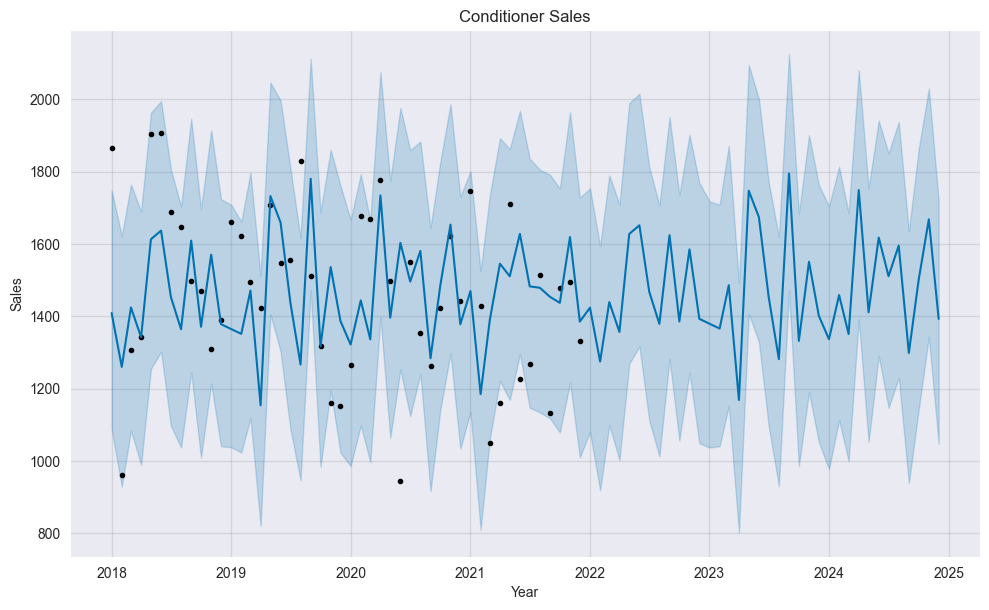

In [142]:
plt.figure(figsize=(20, 10))
chitos_model.plot(conditioner_forecast, xlabel='Year', ylabel='Sales')
plt.title('Conditioner Sales')
plt.show()

Above plot is forecasting of conditioner sales for the next three years and it shows increasing trend in sales for the upcoming years.


*   High sales is predicted on April, July of 2023 and March in 2024.
*   Low sales is expected at the beginning of year around February.


In [143]:
plot_components_plotly(conditioner_model , conditioner_forecast)

- The trend plot shows linearly increasing demand of conditioner from 2018 to 2025.
- Higher seasonality on April 15, August 18 is predicted from the plot.
- Lower seasonality predicted on March 19, September 14.

### Flour


In [144]:
flour = chitos.rename(columns={'Year': 'ds', 'Monthly_Sales': 'y'})
flour

ds            y
0  2018-01-01  1866.035714
1  2018-02-01   962.000000
2  2018-03-01  1307.482759
3  2018-04-01  1343.000000
4  2018-05-01  1902.956522
5  2018-06-01  1908.000000
6  2018-07-01  1687.960000
7  2018-08-01  1647.555556
8  2018-09-01  1496.440000
9  2018-10-01  1469.370370
10 2018-11-01  1309.541667
11 2018-12-01  1389.730769
12 2019-01-01  1660.080000
13 2019-02-01  1622.052632
14 2019-03-01  1495.320000
15 2019-04-01  1421.678571
16 2019-05-01  1708.500000
17 2019-06-01  1546.238095
18 2019-07-01  1555.045455
19 2019-08-01  1829.800000
20 2019-09-01  1511.500000
21 2019-10-01  1317.360000
22 2019-11-01  1160.000000
23 2019-12-01  1151.166667
24 2020-01-01  1265.360000
25 2020-02-01  1675.956522
26 2020-03-01  1668.555556
27 2020-04-01  1777.583333
28 2020-05-01  1498.560000
29 2020-06-01   944.480000
30 2020-07-01  1549.703704
31 2020-08-01  1353.230769
32 2020-09-01  1262.107143
33 2020-10-01  1423.458333
34 2020-11-01  1620.625000
35 2020-12-01  1441.958333
36 2021-01-01  1747.240000
37 2021-02-01  1428.360000
38 2021-03-01  1049.583333
39 2021-04-01  1161.521739
40 2021-05-01  1711.652174
41 2021-06-01  1226.892857
42 2021-07-01  1268.481481
43 2021-08-01  1513.500000
44 2021-09-01  1133.384615
45 2021-10-01  1478.173913
46 2021-11-01  1493.629630
47 2021-12-01  1331.695652

In [145]:
flour_model = prophet.Prophet(interval_width=0.95) 
flour_model.fit(flour)
flour_forecast = flour_model.make_future_dataframe(periods=36, freq='MS')
flour_forecast = flour_model.predict(flour_forecast)
flour_forecast

14:12:55 - cmdstanpy - INFO - Chain [1] start processing


14:12:55 - cmdstanpy - INFO - Chain [1] done processing


ds        trend   yhat_lower   yhat_upper  trend_lower  \
0  2018-01-01  1676.479464  1427.028900  2087.800338  1676.479464   
1  2018-02-01  1671.910426  1057.339763  1701.771455  1671.910426   
2  2018-03-01  1667.783553  1135.378034  1782.632454  1667.783553   
3  2018-04-01  1663.214514  1117.049280  1781.423829  1663.214514   
4  2018-05-01  1658.792864  1472.306714  2106.184169  1658.792864   
..        ...          ...          ...          ...          ...   
79 2024-08-01  1322.157926   907.216026  1587.301983  1322.157828   
80 2024-09-01  1317.588888   687.758500  1339.083024  1317.588786   
81 2024-10-01  1313.167239   881.415038  1530.733096  1313.167134   
82 2024-11-01  1308.598201   991.026876  1634.835349  1308.598092   
83 2024-12-01  1304.176551   790.221719  1426.227619  1304.176438   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0   1676.479464       71.078533             71.078533             71.078533   
1   1671.910426     -277.740328           -277.740328           -277.740328   
2   1667.783553     -216.346644           -216.346644           -216.346644   
3   1663.214514     -231.239705           -231.239705           -231.239705   
4   1658.792864      112.588072            112.588072            112.588072   
..          ...             ...                   ...                   ...   
79  1322.158030      -74.390837            -74.390837            -74.390837   
80  1317.588997     -309.906558           -309.906558           -309.906558   
81  1313.167351      -99.829015            -99.829015            -99.829015   
82  1308.598317       -4.970174             -4.970174             -4.970174   
83  1304.176670     -216.764726           -216.764726           -216.764726   

        yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0    71.078533     71.078533     71.078533                   0.0   
1  -277.740328   -277.740328   -277.740328                   0.0   
2  -216.346644   -216.346644   -216.346644                   0.0   
3  -231.239705   -231.239705   -231.239705                   0.0   
4   112.588072    112.588072    112.588072                   0.0   
..         ...           ...           ...                   ...   
79  -74.390837    -74.390837    -74.390837                   0.0   
80 -309.906558   -309.906558   -309.906558                   0.0   
81  -99.829015    -99.829015    -99.829015                   0.0   
82   -4.970174     -4.970174     -4.970174                   0.0   
83 -216.764726   -216.764726   -216.764726                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                          0.0                         0.0  1747.557997  
1                          0.0                         0.0  1394.170098  
2                          0.0                         0.0  1451.436908  
3                          0.0                         0.0  1431.974809  
4                          0.0                         0.0  1771.380936  
..                         ...                         ...          ...  
79                         0.0                         0.0  1247.767089  
80                         0.0                         0.0  1007.682331  
81                         0.0                         0.0  1213.338224  
82                         0.0                         0.0  1303.628027  
83                         0.0                         0.0  1087.411825  

[84 rows x 16 columns]

In [146]:
flour_forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

<Figure size 2000x1000 with 0 Axes>

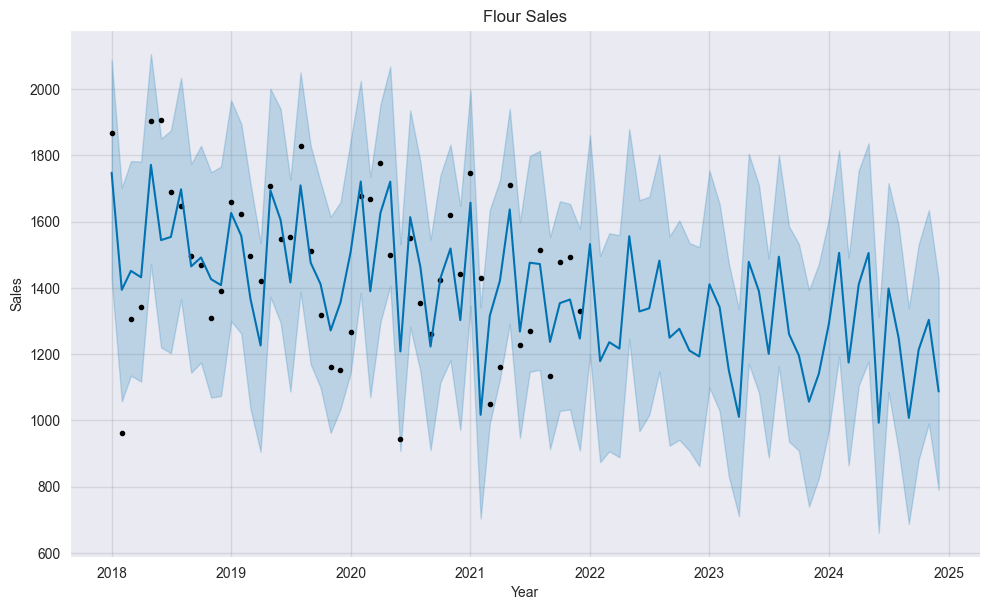

In [147]:
plt.figure(figsize=(20, 10))
chitos_model.plot(flour_forecast, xlabel='Year', ylabel='Sales')
plt.title('Flour Sales')
plt.show()

Above plot is forecasting of flour sales for the next three years and it shows decreasing trend in sales for the upcoming years.


*   High sales is predicted on April 2022, April 2023 and Jan in 2024.
*   Low sales is expected at the beginning of year around January, February.


In [148]:
plot_components_plotly(flour_model , flour_forecast)

- The trend plot shows linearly decreasing demand of flour from 2018 to 2025.
- Higher seasonality on January 18 is predicted from the plot.
- Lower seasonality predicted on February 12, March 20.

## Comparing Forecast and Trend Visualization

### Toilet Paper vs Chitos


In [149]:
chitos_names = ['chitos_%s' % column for column in chitos_forecast.columns]
toiletpaper_names = ['toiletpaper%s' % column for column in toiletpaper_forecast.columns]


merge_chitos_forecast = chitos_forecast.copy()
merge_toiletpaper_forecast = toiletpaper_forecast.copy()


merge_chitos_forecast.columns = chitos_names
merge_toiletpaper_forecast.columns = toiletpaper_names


forecast1 = pd.merge(merge_chitos_forecast, merge_toiletpaper_forecast, how = 'inner', left_on = 'chitos_ds', right_on = 'toiletpaperds')

forecast1 = forecast1.rename(columns={'chitos_ds': 'Date'}).drop('toiletpaperds', axis=1)
forecast1.head()


Date  chitos_trend  chitos_yhat_lower  chitos_yhat_upper  \
0 2018-01-01   1676.479464        1416.981541        2067.305782   
1 2018-02-01   1671.910426        1075.760571        1728.120109   
2 2018-03-01   1667.783553        1116.273691        1765.803306   
3 2018-04-01   1663.214514        1097.006067        1745.502704   
4 2018-05-01   1658.792864        1432.716542        2092.396282   

   chitos_trend_lower  chitos_trend_upper  chitos_additive_terms  \
0         1676.479464         1676.479464              71.078533   
1         1671.910426         1671.910426            -277.740328   
2         1667.783553         1667.783553            -216.346644   
3         1663.214514         1663.214514            -231.239705   
4         1658.792864         1658.792864             112.588072   

   chitos_additive_terms_lower  chitos_additive_terms_upper  chitos_yearly  \
0                    71.078533                    71.078533      71.078533   
1                  -277.740328                  -277.740328    -277.740328   
2                  -216.346644                  -216.346644    -216.346644   
3                  -231.239705                  -231.239705    -231.239705   
4                   112.588072                   112.588072     112.588072   

   ...  toiletpaperadditive_terms  toiletpaperadditive_terms_lower  \
0  ...                  26.852113                        26.852113   
1  ...                  -6.624287                        -6.624287   
2  ...                   4.253685                         4.253685   
3  ...                  33.584276                        33.584276   
4  ...                -121.936274                      -121.936274   

   toiletpaperadditive_terms_upper  toiletpaperyearly  \
0                        26.852113          26.852113   
1                        -6.624287          -6.624287   
2                         4.253685           4.253685   
3                        33.584276          33.584276   
4                      -121.936274        -121.936274   

   toiletpaperyearly_lower  toiletpaperyearly_upper  \
0                26.852113                26.852113   
1                -6.624287                -6.624287   
2                 4.253685                 4.253685   
3                33.584276                33.584276   
4              -121.936274              -121.936274   

   toiletpapermultiplicative_terms  toiletpapermultiplicative_terms_lower  \
0                              0.0                                    0.0   
1                              0.0                                    0.0   
2                              0.0                                    0.0   
3                              0.0                                    0.0   
4                              0.0                                    0.0   

   toiletpapermultiplicative_terms_upper  toiletpaperyhat  
0                                    0.0      1484.273913  
1                                    0.0      1450.897210  
2                                    0.0      1461.865232  
3                                    0.0      1491.295520  
4                                    0.0      1335.871453  

[5 rows x 31 columns]

Text(0.5, 1.0, 'Toilet Paper v/s Chitos Sales Forecast')

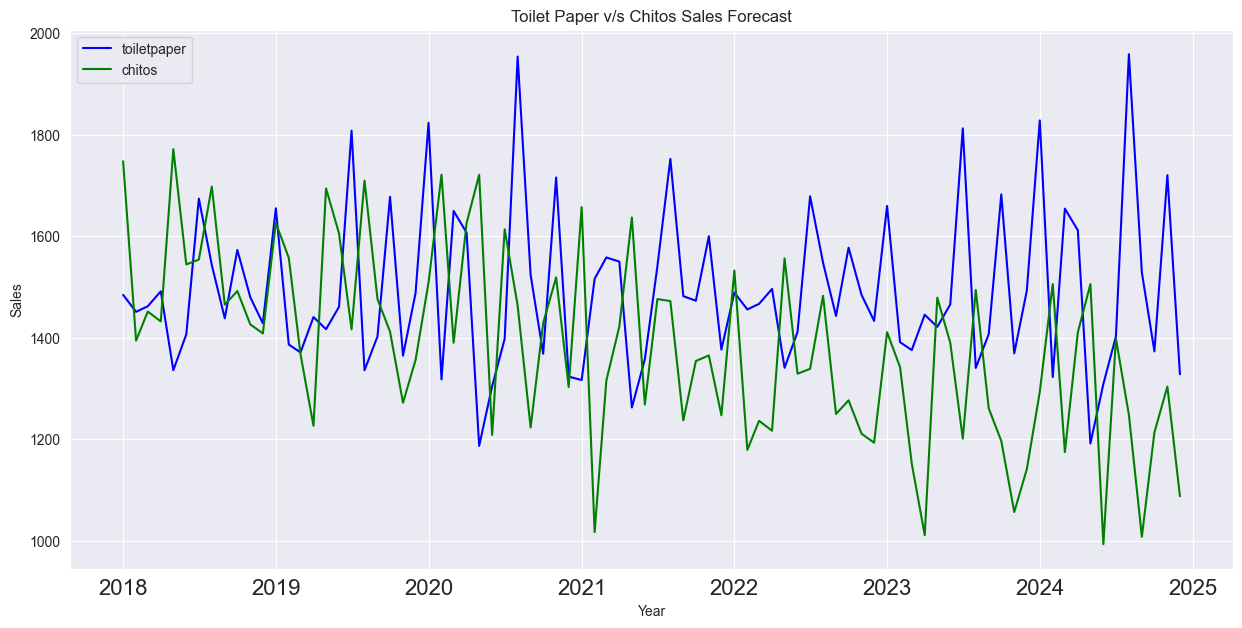

In [150]:
plt.figure(figsize=(15, 7))
plt.plot(forecast1['Date'], forecast1['toiletpaperyhat'], 'b-')
plt.plot(forecast1['Date'], forecast1['chitos_yhat'], 'g-')
plt.legend(['toiletpaper','chitos'])
plt.xlabel('Year')
plt.ylabel('Sales')
plt.tick_params(axis='x', labelsize=16)
plt.title('Toilet Paper v/s Chitos Sales Forecast')

Text(0.5, 1.0, 'Toilet paper and Chitos Sales Trend')

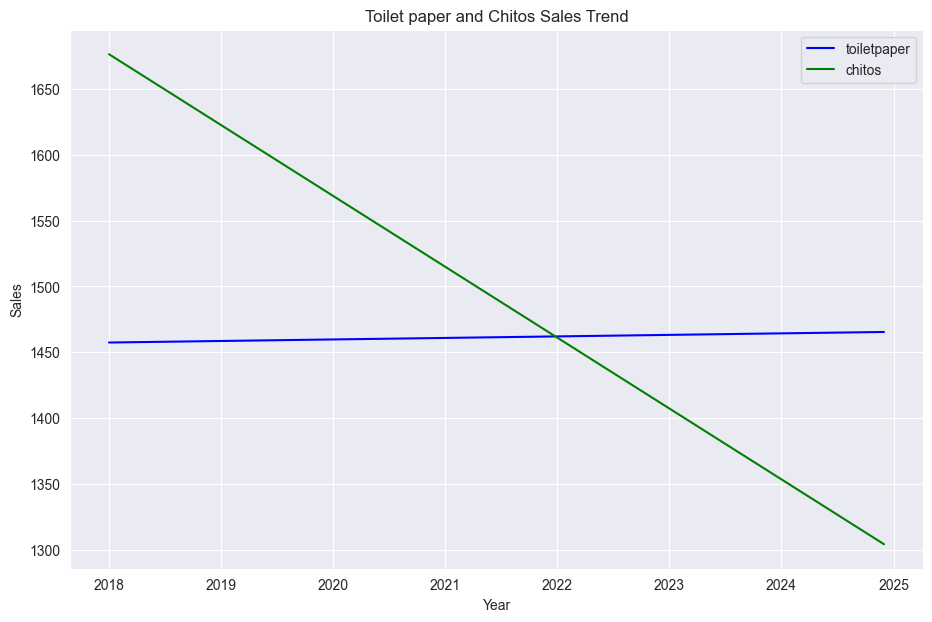

In [151]:
plt.figure(figsize=(11, 7))
plt.plot(forecast1['Date'], forecast1['toiletpapertrend'], 'b-')
plt.plot(forecast1['Date'], forecast1['chitos_trend'], 'g-')

plt.legend(['toiletpaper','chitos'])
plt.xlabel('Year'); plt.ylabel('Sales')
plt.title('Toilet paper and Chitos Sales Trend')

- Above plots show the comparison of forecasts of products Toilet Paper and Chitos and their trends respectively.
- Toilet Paper sales are increasing hence an uptrend while Chitos sales are expected to decrease denoting a downtrend.

### Peanut Butter vs Chitos


In [152]:
peanut_butter_names = ['peanut_butter%s' % column for column in peanut_butter_forecast.columns]
chitos_names = ['chitos%s' % column for column in chitos_forecast.columns]

merge_peanut_butter_forecast = peanut_butter_forecast.copy()
merge_chitos_forecast = chitos_forecast.copy()

merge_peanut_butter_forecast.columns = peanut_butter_names
merge_chitos_forecast.columns = chitos_names

forecast2 = pd.merge(merge_peanut_butter_forecast, merge_chitos_forecast, how = 'inner', left_on = 'peanut_butterds', right_on = 'chitosds')

forecast2 = forecast2.rename(columns={'peanut_butterds': 'Date'}).drop('chitosds', axis=1)
forecast2.head()

Date  peanut_buttertrend  peanut_butteryhat_lower  \
0 2018-01-01         1614.025341              1218.376212   
1 2018-02-01         1610.786384              1402.629644   
2 2018-03-01         1607.860875              1239.897030   
3 2018-04-01         1604.621919              1105.951947   
4 2018-05-01         1601.487445              1210.652749   

   peanut_butteryhat_upper  peanut_buttertrend_lower  \
0              1817.059972               1614.025341   
1              1956.343126               1610.786384   
2              1824.698099               1607.860875   
3              1731.046199               1604.621919   
4              1776.786936               1601.487445   

   peanut_buttertrend_upper  peanut_butteradditive_terms  \
0               1614.025341                   -87.554374   
1               1610.786384                    68.070898   
2               1607.860875                   -69.411237   
3               1604.621919                  -182.714851   
4               1601.487445                  -106.622099   

   peanut_butteradditive_terms_lower  peanut_butteradditive_terms_upper  \
0                         -87.554374                         -87.554374   
1                          68.070898                          68.070898   
2                         -69.411237                         -69.411237   
3                        -182.714851                        -182.714851   
4                        -106.622099                        -106.622099   

   peanut_butteryearly  ...  chitosadditive_terms  chitosadditive_terms_lower  \
0           -87.554374  ...             71.078533                   71.078533   
1            68.070898  ...           -277.740328                 -277.740328   
2           -69.411237  ...           -216.346644                 -216.346644   
3          -182.714851  ...           -231.239705                 -231.239705   
4          -106.622099  ...            112.588072                  112.588072   

   chitosadditive_terms_upper  chitosyearly  chitosyearly_lower  \
0                   71.078533     71.078533           71.078533   
1                 -277.740328   -277.740328         -277.740328   
2                 -216.346644   -216.346644         -216.346644   
3                 -231.239705   -231.239705         -231.239705   
4                  112.588072    112.588072          112.588072   

   chitosyearly_upper  chitosmultiplicative_terms  \
0           71.078533                         0.0   
1         -277.740328                         0.0   
2         -216.346644                         0.0   
3         -231.239705                         0.0   
4          112.588072                         0.0   

   chitosmultiplicative_terms_lower  chitosmultiplicative_terms_upper  \
0                               0.0                               0.0   
1                               0.0                               0.0   
2                               0.0                               0.0   
3                               0.0                               0.0   
4                               0.0                               0.0   

    chitosyhat  
0  1747.557997  
1  1394.170098  
2  1451.436908  
3  1431.974809  
4  1771.380936  

[5 rows x 31 columns]

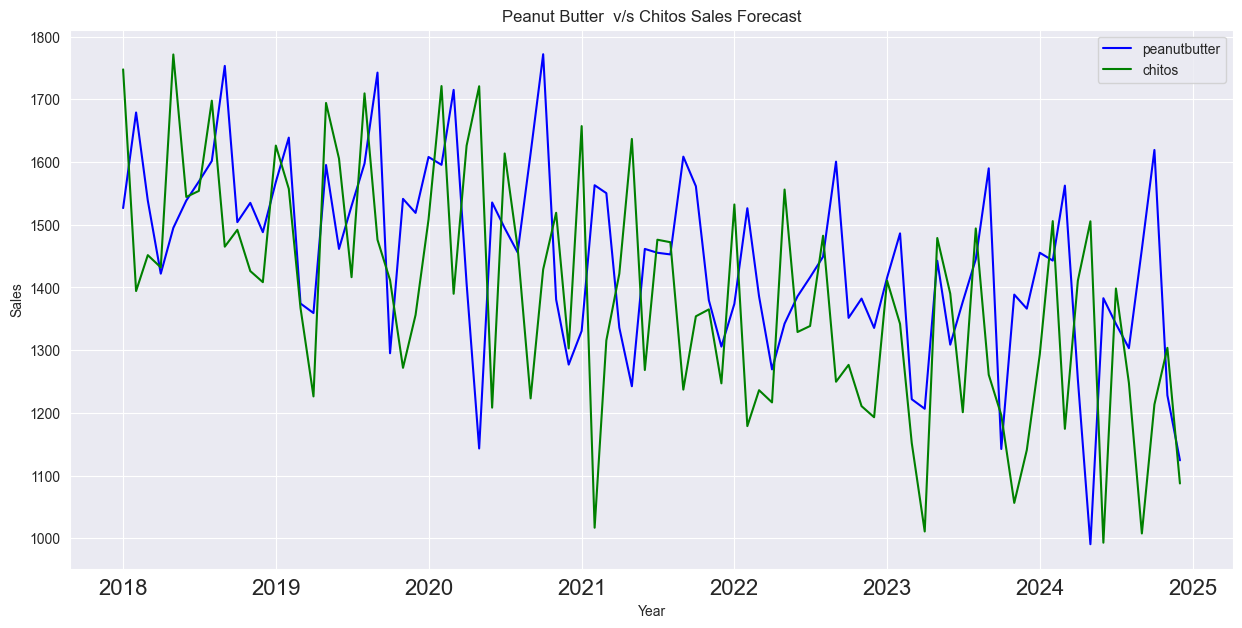

In [153]:
plt.figure(figsize=(15, 7))
plt.plot(forecast2['Date'], forecast2['peanut_butteryhat'], 'b-')
plt.plot(forecast2['Date'], forecast2['chitosyhat'], 'g-')
plt.legend(['peanutbutter','chitos'])
plt.xlabel('Year')
plt.ylabel('Sales')
plt.tick_params(axis='x', labelsize=16)
plt.title('Peanut Butter  v/s Chitos Sales Forecast');

Text(0.5, 1.0, 'Peanut Butter and Chitos Sales Trend')

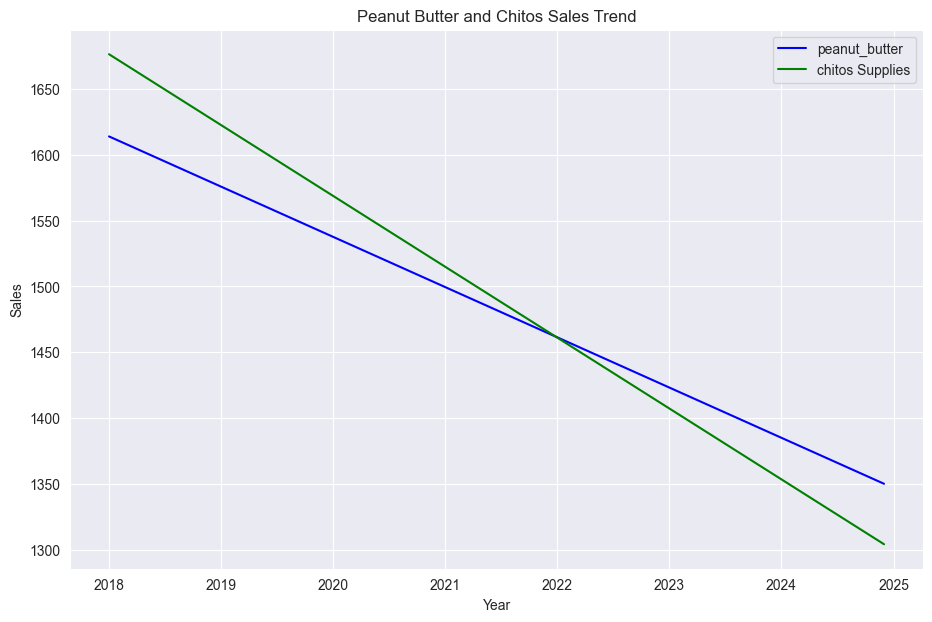

In [154]:
plt.figure(figsize=(11, 7))
plt.plot(forecast2['Date'], forecast2['peanut_buttertrend'], 'b-')
plt.plot(forecast2['Date'], forecast2['chitostrend'], 'g-')

plt.legend(['peanut_butter','chitos Supplies'])
plt.xlabel('Year'); plt.ylabel('Sales')
plt.title('Peanut Butter and Chitos Sales Trend')

- Above plots show the comparison of forecasts of products Peanut Butter and Chitos and their trends respectively.
- Sales of both are expected to decrease hence a downtrend.

### Conditioner vs Flour


In [155]:
flour_names = ['flour_%s' % column for column in flour_forecast.columns]
conditioner_names = ['conditioner%s' % column for column in conditioner_forecast.columns]


merge_flour_forecast = flour_forecast.copy()
merge_conditioner_forecast = conditioner_forecast.copy()


merge_flour_forecast.columns = flour_names
merge_conditioner_forecast.columns = conditioner_names


forecast3 = pd.merge(merge_flour_forecast, merge_conditioner_forecast, how = 'inner', left_on = 'flour_ds', right_on = 'conditionerds')

forecast3 = forecast3.rename(columns={'flour_ds': 'Date'}).drop('conditionerds', axis=1)
forecast3.head()

Date  flour_trend  flour_yhat_lower  flour_yhat_upper  \
0 2018-01-01  1676.479464       1427.028900       2087.800338   
1 2018-02-01  1671.910426       1057.339763       1701.771455   
2 2018-03-01  1667.783553       1135.378034       1782.632454   
3 2018-04-01  1663.214514       1117.049280       1781.423829   
4 2018-05-01  1658.792864       1472.306714       2106.184169   

   flour_trend_lower  flour_trend_upper  flour_additive_terms  \
0        1676.479464        1676.479464             71.078533   
1        1671.910426        1671.910426           -277.740328   
2        1667.783553        1667.783553           -216.346644   
3        1663.214514        1663.214514           -231.239705   
4        1658.792864        1658.792864            112.588072   

   flour_additive_terms_lower  flour_additive_terms_upper  flour_yearly  ...  \
0                   71.078533                   71.078533     71.078533  ...   
1                 -277.740328                 -277.740328   -277.740328  ...   
2                 -216.346644                 -216.346644   -216.346644  ...   
3                 -231.239705                 -231.239705   -231.239705  ...   
4                  112.588072                  112.588072    112.588072  ...   

   conditioneradditive_terms  conditioneradditive_terms_lower  \
0                 -74.941512                       -74.941512   
1                -224.145873                      -224.145873   
2                 -59.953491                       -59.953491   
3                -142.911934                      -142.911934   
4                 127.807992                       127.807992   

   conditioneradditive_terms_upper  conditioneryearly  \
0                       -74.941512         -74.941512   
1                      -224.145873        -224.145873   
2                       -59.953491         -59.953491   
3                      -142.911934        -142.911934   
4                       127.807992         127.807992   

   conditioneryearly_lower  conditioneryearly_upper  \
0               -74.941512               -74.941512   
1              -224.145873              -224.145873   
2               -59.953491               -59.953491   
3              -142.911934              -142.911934   
4               127.807992               127.807992   

   conditionermultiplicative_terms  conditionermultiplicative_terms_lower  \
0                              0.0                                    0.0   
1                              0.0                                    0.0   
2                              0.0                                    0.0   
3                              0.0                                    0.0   
4                              0.0                                    0.0   

   conditionermultiplicative_terms_upper  conditioneryhat  
0                                    0.0      1409.025287  
1                                    0.0      1260.134979  
2                                    0.0      1424.611022  
3                                    0.0      1341.966632  
4                                    0.0      1612.990481  

[5 rows x 31 columns]

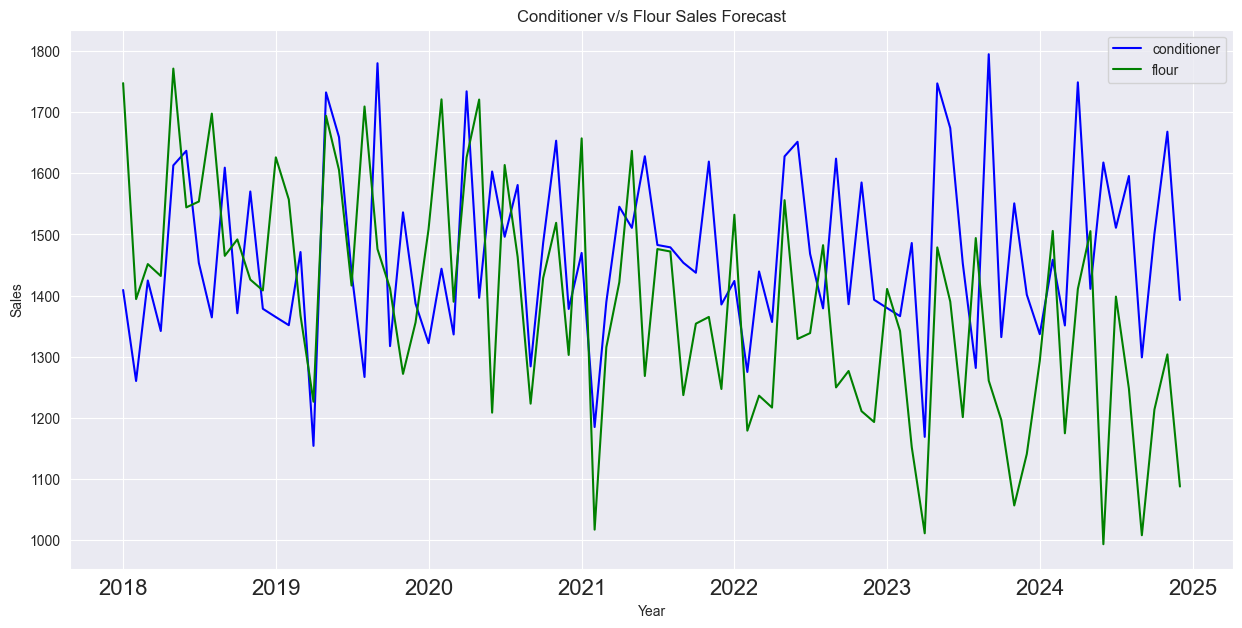

In [156]:
plt.figure(figsize=(15, 7))
plt.plot(forecast3['Date'], forecast3['conditioneryhat'], 'b-')
plt.plot(forecast3['Date'], forecast3['flour_yhat'], 'g-')
plt.legend(['conditioner','flour'])
plt.xlabel('Year')
plt.ylabel('Sales')
plt.tick_params(axis='x', labelsize=16)
plt.title('Conditioner v/s Flour Sales Forecast');

Text(0.5, 1.0, 'Conditioner and Flour Sales Trend')

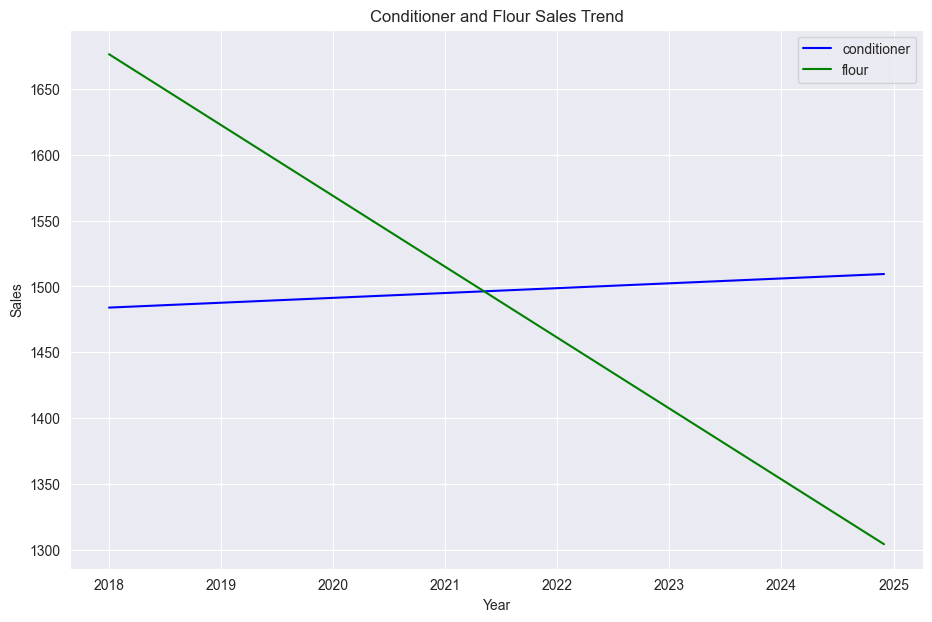

In [157]:
plt.figure(figsize=(11, 7))
plt.plot(forecast3['Date'], forecast3['conditionertrend'], 'b-')
plt.plot(forecast3['Date'], forecast3['flour_trend'], 'g-')

plt.legend(['conditioner','flour'])
plt.xlabel('Year'); plt.ylabel('Sales')
plt.title('Conditioner and Flour Sales Trend')

- Above plots show the comparison of forecasts of products Conditioner and Flour and their trends respectively.
- Conditioner sales are increasing hence denoting an uptrend while Flour sales are expected to decrease denoting a downtrend.

### Toilet Paper vs Conditioner

In [158]:
conditioner_names = ['conditioner%s' % column for column in conditioner_forecast.columns]
toiletpaper_names = ['toiletpaper%s' % column for column in toiletpaper_forecast.columns]


merge_conditioner_forecast = conditioner_forecast.copy()
merge_toiletpaper_forecast = toiletpaper_forecast.copy()


merge_conditioner_forecast.columns = conditioner_names
merge_toiletpaper_forecast.columns = toiletpaper_names


forecast4 = pd.merge(merge_conditioner_forecast, merge_toiletpaper_forecast, how = 'inner', left_on = 'conditionerds', right_on = 'toiletpaperds')

forecast4 = forecast4.rename(columns={'conditionerds': 'Date'}).drop('toiletpaperds', axis=1)
forecast4.head()


Date  conditionertrend  conditioneryhat_lower  conditioneryhat_upper  \
0 2018-01-01       1483.966799            1088.230764            1747.753226   
1 2018-02-01       1484.280852             929.296801            1621.924920   
2 2018-03-01       1484.564513            1085.082380            1764.129397   
3 2018-04-01       1484.878566             989.184221            1689.903462   
4 2018-05-01       1485.182489            1255.190514            1962.863922   

   conditionertrend_lower  conditionertrend_upper  conditioneradditive_terms  \
0             1483.966799             1483.966799                 -74.941512   
1             1484.280852             1484.280852                -224.145873   
2             1484.564513             1484.564513                 -59.953491   
3             1484.878566             1484.878566                -142.911934   
4             1485.182489             1485.182489                 127.807992   

   conditioneradditive_terms_lower  conditioneradditive_terms_upper  \
0                       -74.941512                       -74.941512   
1                      -224.145873                      -224.145873   
2                       -59.953491                       -59.953491   
3                      -142.911934                      -142.911934   
4                       127.807992                       127.807992   

   conditioneryearly  ...  toiletpaperadditive_terms  \
0         -74.941512  ...                  26.852113   
1        -224.145873  ...                  -6.624287   
2         -59.953491  ...                   4.253685   
3        -142.911934  ...                  33.584276   
4         127.807992  ...                -121.936274   

   toiletpaperadditive_terms_lower  toiletpaperadditive_terms_upper  \
0                        26.852113                        26.852113   
1                        -6.624287                        -6.624287   
2                         4.253685                         4.253685   
3                        33.584276                        33.584276   
4                      -121.936274                      -121.936274   

   toiletpaperyearly  toiletpaperyearly_lower  toiletpaperyearly_upper  \
0          26.852113                26.852113                26.852113   
1          -6.624287                -6.624287                -6.624287   
2           4.253685                 4.253685                 4.253685   
3          33.584276                33.584276                33.584276   
4        -121.936274              -121.936274              -121.936274   

   toiletpapermultiplicative_terms  toiletpapermultiplicative_terms_lower  \
0                              0.0                                    0.0   
1                              0.0                                    0.0   
2                              0.0                                    0.0   
3                              0.0                                    0.0   
4                              0.0                                    0.0   

   toiletpapermultiplicative_terms_upper  toiletpaperyhat  
0                                    0.0      1484.273913  
1                                    0.0      1450.897210  
2                                    0.0      1461.865232  
3                                    0.0      1491.295520  
4                                    0.0      1335.871453  

[5 rows x 31 columns]

Text(0.5, 1.0, 'Toilet Paper v/s Conditioner Sales Forecast')

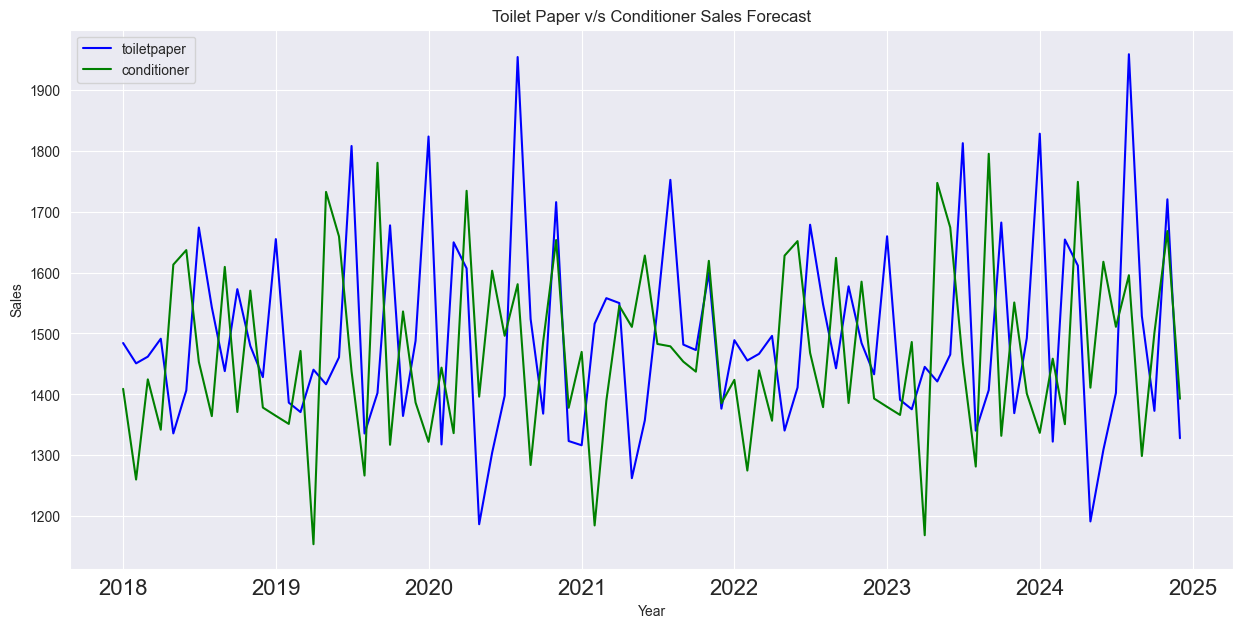

In [159]:
plt.figure(figsize=(15, 7))
plt.plot(forecast4['Date'], forecast4['toiletpaperyhat'], 'b-')
plt.plot(forecast4['Date'], forecast4['conditioneryhat'], 'g-')
plt.legend(['toiletpaper','conditioner'])
plt.xlabel('Year'); plt.ylabel('Sales')
plt.tick_params(axis='x', labelsize=16)
plt.title('Toilet Paper v/s Conditioner Sales Forecast')


Text(0.5, 1.0, 'Toilet Paper and Conditioner Trend')

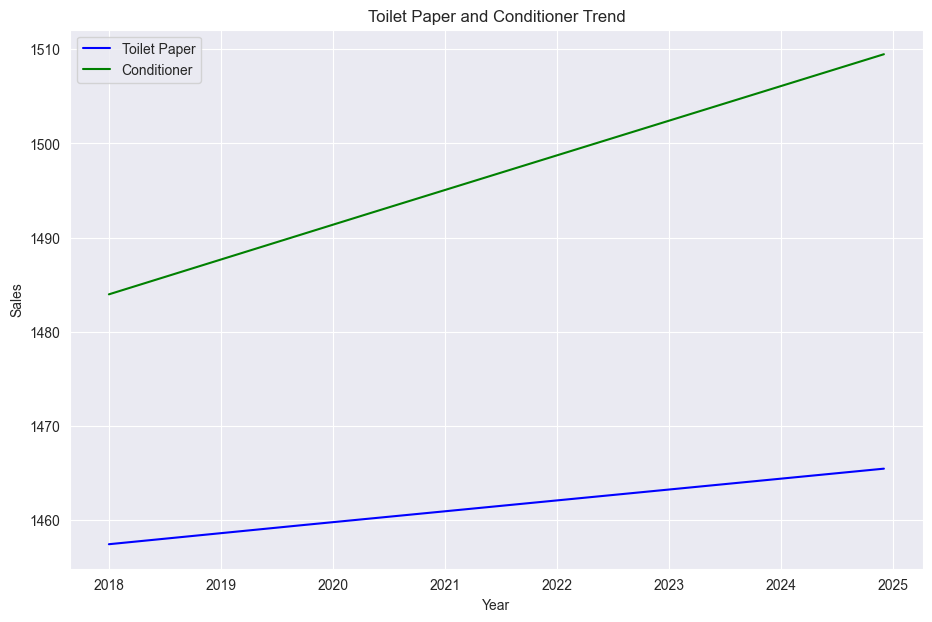

In [160]:
plt.figure(figsize=(11, 7))
plt.plot(forecast4['Date'], forecast4['toiletpapertrend'], 'b-')
plt.plot(forecast4['Date'], forecast4['conditionertrend'], 'g-')

plt.legend(['Toilet Paper','Conditioner'])
plt.xlabel('Year'); plt.ylabel('Sales')
plt.title('Toilet Paper and Conditioner Trend')


- Above plots show the comparison of forecasts of products Toilet Paper and Conditioner and their trends respectively.
- Sales of both are increasing hence denoting an uptrend.


### **Conclusion:**
 - Demand of Toiler Paper is increasing as predicted by SARIMA model and Fbprophet.
 - Demand of Chitos is predicted as steadily decreasing.
 - Demand of Peanut Butter is predicted as steadily decreasing.
 - Demand of Conditioner is predicted as increasing.
 - Demand of Flour is predicted as steadily decreasing.
 - Suitable Business strategies have to be implemented to improve sales of product Peanut Butter.